# Prerequisites

## Import packages

In [1]:
import pandas as pd
import pymc3 as pm
import bambi as bmb
from bambi import Prior
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np
import scipy as sp

In [2]:
#Packages versions
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jun 20 2021

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

pymc3     : 3.11.2
matplotlib: 3.3.4
seaborn   : 0.11.1
bambi     : 0.5.0
numpy     : 1.19.2
scipy     : 1.6.2
pandas    : 1.2.4
arviz     : 0.11.2

Watermark: 2.2.0



## Import Data

### Quantitive data

In [3]:
#Change the path if necessary
df = pd.read_csv("data_all.csv") #Read data

#Tidy up data frame
df.drop(['VP','FPSmax','FPSmin','FPSmean','FPSsd'], axis=1, inplace=True) #drop irrelevant columns
df = df.astype({"Condition": 'category',"ID": 'category',"Speed": 'category'}) #set categorical variables
df['Condition'] = df['Condition'].cat.reorder_categories(['REAL','CAVE','HMD','AR','CBLab','CBRemote'], ordered=True) #reorder condition

#Center gap sizes from [1,5] to [-2,2]
df['GapC'] = df['Gap'] - 3 

#Exclude the one remote participant with many treated data points (c.f. Section Data Exclusion)
#df = df.drop(df[df.ID == '27_CBRemote'].index) 

### Questionnaires

Q1: How safe would it have been to cross the street?

Q2: How likely would a collision have been?

Q3: How dangerous would a collision have been?

Q4: How similar to real world traffic was your behavior in cases when you crossed the street?

Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?

Q6: Compared to usual, my choices were safe / unsafe

Q7: Compared to usual, deciding to cross the street was easy / difficult

Q8: Compared to usual, making a decision took longer / shorter

In [4]:
#Change the path if necessary
df_subjectives = pd.read_csv("questionnaires_all.csv", encoding="cp1252") #Read data

#Tidy up data frame
df_subjectives = df_subjectives.astype({"Condition": 'category',"ID": 'category'}) #set categorical variables
df_subjectives['Condition'] = df_subjectives['Condition'].cat.reorder_categories(['REAL','CAVE','HMD','AR','CBLab','CBRemote'], ordered=True) #reorder condition

## Figure aesthetics

In [5]:
#fontcolor = "black"
#whiskercolor = "black"
plt.rcParams.update({
    #"figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # rgba
    #"axes.facecolor":    (1.0, 1.0, 1.0, 0.0),  
    #"savefig.facecolor": (1.0, 1.0, 1.0, 0.0),
    #"legend.framealpha": 0.0,
    #"text.color": fontcolor,
    #"axes.labelcolor": fontcolor,
    #"xtick.color": fontcolor,
    #"ytick.color": fontcolor,
    #"axes.edgecolor": fontcolor,
    "boxplot.notch":  True #show notches for boxplots
})
sns.set_palette("viridis",6) #set color palette for plots

#Add Black to color palette 
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

## Helper functions

In [6]:
#transformation of the coefficients from log odds to probabilities
def plogis(x):
    return np.exp(x) / (1+np.exp(x))

#Set random seed
RANDOM_SEED = 3301

#Set order for condition for plots and outputs
Conditions = ['REAL','CAVE','HMD','AR','CBLab','CBRemote']

#Create Dummy codes for Simulator Conditions
dummies = pd.get_dummies(df_subjectives['Condition'])

#Function to show HDIs of later comparisons
def printHDIs(q):  
    HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                           np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                           np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                           np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                           np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                           np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                                 ['ROPE',df_subjectives[q].std()*-0.1,df_subjectives[q].std()*0.1]]),
                 columns=['Comparison', 'lowHDI', 'highHDI'])
    HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
    HDIs["Result"] = ""
    for index, row in HDIs.iterrows():
        result = 'inconclusive'
        if (row.lowHDI>df_subjectives[q].std()*-0.1 and row.highHDI < df_subjectives[q].std()*0.1):
            result = 'equal'
        if (row.lowHDI>df_subjectives[q].std()*0.1):
            result = 'larger'
        if (row.highHDI<df_subjectives[q].std()*-0.1):
            result = 'smaller'
        HDIs.iat[index, 3] = result
    display(HDIs.round(3))

# Exploratory Data Analysis

## Gap Acceptance

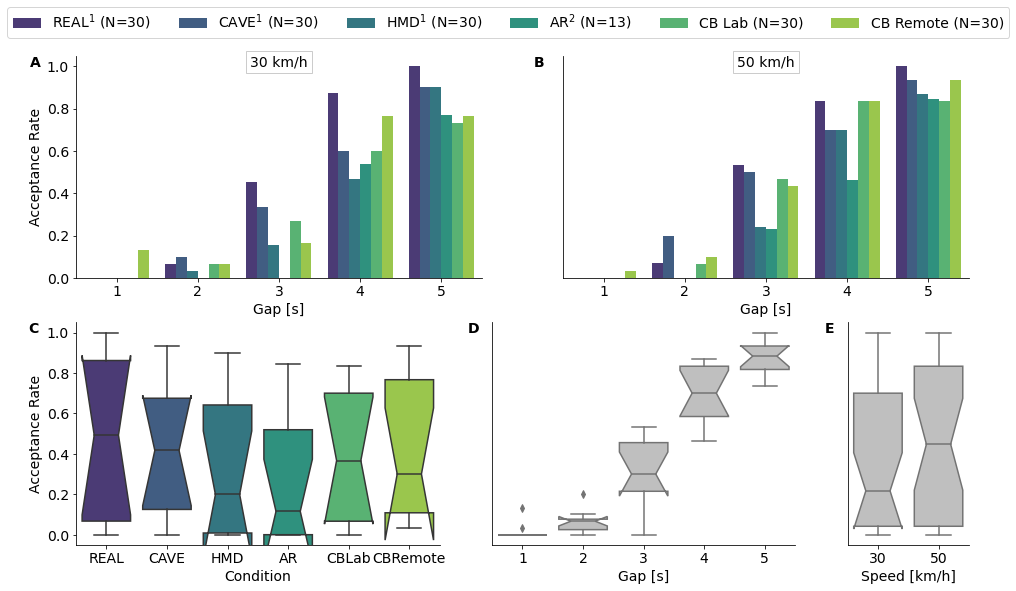

In [7]:
#Creating dataframe with acceptance rates for combinations of speed, condition and gap size
columns = ['Condition','Speed','Gap [s]','Acceptance Rate'] #define columns
df_gap_acceptance = pd.DataFrame(columns = columns) #create empty dataframe
for Speed in [30,50]: #loop over both levels of speed
    for Condition in ['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']: #loop over all conditions
        for Gap in range(1,6): #loop over all gap sizes from 1 to 5
            #Calculate acceptance rates and store in empty dataframe
            df_gap_acceptance.loc[len(df_gap_acceptance)] = [Condition,Speed,Gap, df.loc[(df['Condition'] == Condition) & 
                                                                                         (df['Speed'] == Speed) & (df['Gap'] == Gap)]
                                                             .Crossing.value_counts(normalize=True,sort=False, dropna=False).get(1, 0)]

### Plot ###
fig = plt.figure(figsize=(16,9)) #init figure
plt.rcParams.update({'font.size': 14}) #increase font size

#Init grid to store subplots
gs0 = gridspec.GridSpec(2, 1, figure=fig) 
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[0, 1])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1], width_ratios = [6,5,2])
ax3 = fig.add_subplot(gs01[0, 0])
ax4 = fig.add_subplot(gs01[0, 1])
ax5 = fig.add_subplot(gs01[0, 2])

#Subplot A
sns.barplot(x='Gap [s]', y='Acceptance Rate', ax = ax1,hue='Condition',
            data=df_gap_acceptance.loc[df_gap_acceptance['Speed'] == 30]);
ax1.get_legend().remove()
ax1.text(2, 1, '30 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.2))

#Subplot B
sns.barplot(x='Gap [s]', y='Acceptance Rate', ax = ax2,hue='Condition',
            data=df_gap_acceptance.loc[df_gap_acceptance['Speed'] == 50]);
ax2.get_legend().remove()
ax2.yaxis.set_visible(False)
ax2.text(2, 1, '50 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.2))

#Subplot C
sns.boxplot(ax = ax3,x='Condition', y='Acceptance Rate', data=df_gap_acceptance);

#Subplot D
sns.boxplot(ax = ax4,x='Gap [s]', y='Acceptance Rate', data=df_gap_acceptance, color = '#bfbfbf');
ax4.yaxis.set_visible(False)

#Subplot E
sns.boxplot(ax = ax5,x='Speed', y='Acceptance Rate', data=df_gap_acceptance, color = '#bfbfbf');
ax5.yaxis.set_visible(False)
ax5.set_xlabel('Speed [km/h]')

#Create Legend
plt.legend(bbox_to_anchor=(-2.8, 2.35), loc='center', prop={'size': 14},
           ncol=6,handles = ax1.get_legend_handles_labels()[0], 
           labels=['REAL$^{1}$ (N=30)', 'CAVE$^{1}$ (N=30)', 'HMD$^{1}$ (N=30)', 
                   'AR$^{2}$ (N=13)', 'CB Lab (N=30)', 'CB Remote (N=30)'])

#Create labels for subfigures
ax1.text(-1, 1, 'A', horizontalalignment='center',weight="bold")
ax2.text(-0.8, 1, 'B', horizontalalignment='center',weight="bold")
ax3.text(-1.2, 1, 'C', horizontalalignment='center',weight="bold")
ax4.text(-0.8, 1, 'D', horizontalalignment='center',weight="bold")
ax5.text(-0.8, 1, 'E', horizontalalignment='center',weight="bold")

#Remove top and right frame
sns.despine()

In [8]:
#Output acceptance rates for each condition
df_gap_acceptance.iloc[:,3] = pd.to_numeric(df_gap_acceptance.iloc[:,3], errors='coerce')
df_gap_acceptance.groupby('Condition')['Acceptance Rate'].describe()

count      mean       std       min       25%       50%       75%  \
Condition                                                                      
AR          10.0  0.284615  0.342190  0.000000  0.000000  0.115385  0.519231   
CAVE        10.0  0.426667  0.353047  0.000000  0.125000  0.416667  0.675000   
CBLab       10.0  0.386667  0.347904  0.000000  0.066667  0.366667  0.700000   
CBRemote    10.0  0.423333  0.364827  0.033333  0.108333  0.300000  0.766667   
HMD         10.0  0.336430  0.368304  0.000000  0.008333  0.198815  0.641667   
REAL        10.0  0.482488  0.424615  0.000000  0.067241  0.492473  0.861559   

                max  
Condition            
AR         0.846154  
CAVE       0.933333  
CBLab      0.833333  
CBRemote   0.933333  
HMD        0.900000  
REAL       1.000000

## Crossing Initiation Time

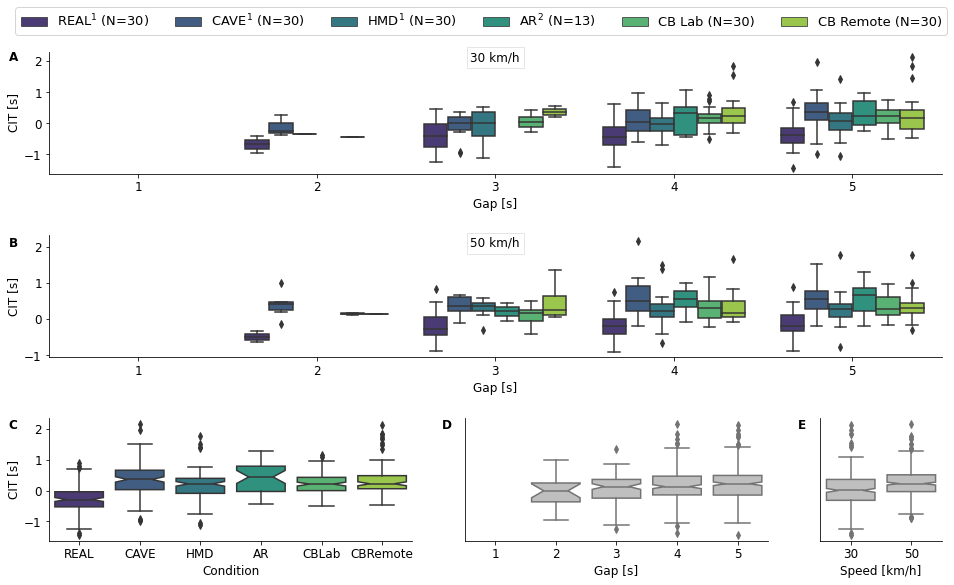

In [9]:
### Plot ###
fig = plt.figure(figsize=(16,9)) #Init figure
plt.rcParams.update({'font.size': 12}) #Update font size

#Init grid to store subplots
gs0 = gridspec.GridSpec(3, 1, figure=fig,hspace=0.5)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0, 0])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax2 = fig.add_subplot(gs01[0, 0])

gs02 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2], width_ratios = [6,5,2])
ax3 = fig.add_subplot(gs02[0, 0])
ax4 = fig.add_subplot(gs02[0, 1])
ax5 = fig.add_subplot(gs02[0, 2])

#Subplot A
sns.boxplot(x='Gap', y='CrossingInitiationTime', ax = ax1,hue='Condition',
            data=df.loc[df['Speed'] == 30],notch = False);
ax1.set_xlabel('Gap [s]')
ax1.get_legend().remove()
ax1.text(2, 2, '30 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.1))
ax1.set_ylabel('CIT [s]')

#Subplot B
sns.boxplot(x='Gap', y='CrossingInitiationTime', ax = ax2,hue='Condition',
            data=df.loc[df['Speed'] == 50],notch = False);
ax2.get_legend().remove()
ax2.text(2, 2, '50 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.1))
ax2.set_xlabel('Gap [s]')
ax2.set_ylabel('CIT [s]')

#Subplot C
sns.boxplot(ax = ax3,x='Condition', y='CrossingInitiationTime', data=df, order=['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']);
ax3.set_ylabel('CIT [s]')

#Subplot D
sns.boxplot(ax = ax4,x='Gap', y='CrossingInitiationTime', data=df, color = '#bfbfbf');
ax4.yaxis.set_visible(False)
ax4.set_xlabel('Gap [s]')

#Subplot E
sns.boxplot(ax = ax5,x='Speed', y='CrossingInitiationTime', data=df, color = '#bfbfbf');
ax5.yaxis.set_visible(False)
ax5.set_xlabel('Speed [km/h]')

#Create Legend
plt.legend(bbox_to_anchor=(-2.8, 4.25), loc='center', prop={'size': 13},
           ncol=6,handles = ax1.get_legend_handles_labels()[0], 
           labels=['REAL$^{1}$ (N=30)', 'CAVE$^{1}$ (N=30)', 'HMD$^{1}$ (N=30)', 
                   'AR$^{2}$ (N=13)', 'CB Lab (N=30)', 'CB Remote (N=30)'])
#Labels for subfigures
ax1.text(-0.7, 2, 'A', horizontalalignment='center',weight="bold")
ax2.text(-0.7, 2, 'B', horizontalalignment='center',weight="bold")
ax3.text(-1.1, 2, 'C', horizontalalignment='center',weight="bold")
ax4.text(-0.8, 2, 'D', horizontalalignment='center',weight="bold")
ax5.text(-0.8, 2, 'E', horizontalalignment='center',weight="bold")

#Remove top and right frame
sns.despine()

## Subjective Data

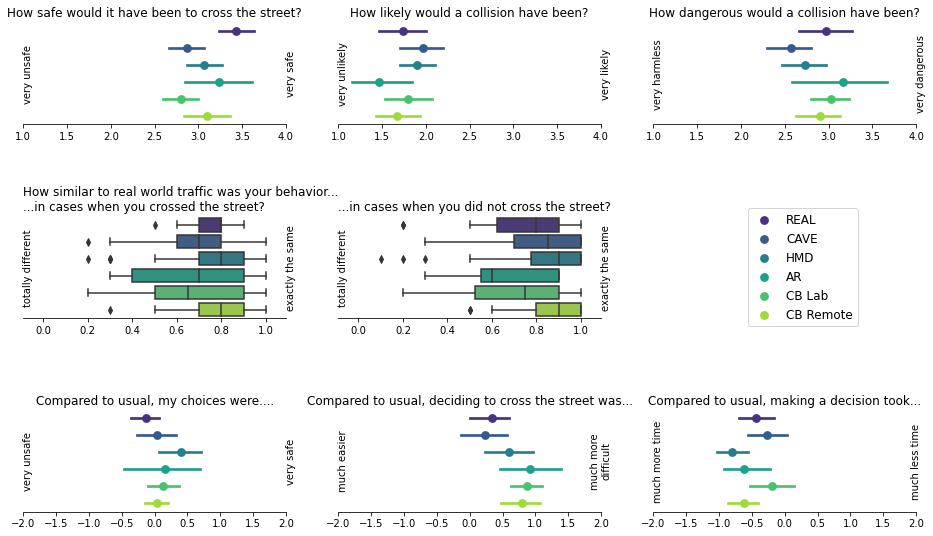

In [10]:
###Plot###

fig = plt.figure(figsize=(16, 9))  #Init figure
plt.rcParams.update({'font.size': 10}) #Update font size

#Subplot Q1: How safe would it have been to cross the street?
ax1 = plt.subplot(3, 3, 1)
ax1.set_title("How safe would it have been to cross the street?")
sns.pointplot(y='Condition', x='Q1',join=False, data = df_subjectives,
             hue='Condition',hue_order=Conditions,order=Conditions, ax=ax1);
ax1.text(0, 0.5, "very unsafe",transform=ax1.transAxes, rotation = 90,verticalalignment='center')
ax1.text(1, 0.5, "very safe",transform=ax1.transAxes, rotation = 90,verticalalignment='center')
ax1.set(xlim=(1, 4))

#Subplot Q2: How likely would a collision have been?
ax2 = plt.subplot(3, 3, 2)
ax2.set_title("How likely would a collision have been?")
sns.pointplot(y='Condition', x='Q2',join=False, data = df_subjectives,
             hue='Condition',hue_order=Conditions,order=Conditions, ax=ax2);
ax2.text(0, 0.5, "very unlikely",transform=ax2.transAxes, rotation = 90,verticalalignment='center')
ax2.text(1, 0.5, "very likely",transform=ax2.transAxes, rotation = 90,verticalalignment='center')
ax2.set(xlim=(1, 4))

#Subplot Q3: How dangerous would a collision have been?
ax3 = plt.subplot(3, 3, 3)
ax3.set_title("How dangerous would a collision have been?")
sns.pointplot(y='Condition', x='Q3',join=False, data = df_subjectives,
             hue='Condition',hue_order=Conditions,order=Conditions, ax=ax3);
ax3.text(0, 0.5, "very harmless",transform=ax3.transAxes, rotation = 90,verticalalignment='center')
ax3.text(1, 0.5, "very dangerous",transform=ax3.transAxes, rotation = 90,verticalalignment='center')
ax3.set(xlim=(1, 4))

#Subplot Q4: How similar to real world traffic was your behavior in cases when you crossed the street?
ax4 = plt.subplot(3, 3, 4)
ax4.set_title("How similar to real world traffic was your behavior... \n...in cases when you crossed the street?" , loc='left')
sns.boxplot(y="Condition", x='Q4', orient = "h", notch = False,
                data = df_subjectives, hue_order=Conditions, order=Conditions);
ax4.text(0, 0.5, "totally different",transform=ax4.transAxes, rotation = 90,verticalalignment='center')
ax4.text(1, 0.5, "exactly the same",transform=ax4.transAxes, rotation = 90,verticalalignment='center')
ax4.set(xlim=(-0.09, 1.09))
    
#Subplot Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?    
ax5 = plt.subplot(3, 3, 5)
ax5.set_title("\n...in cases when you did not cross the street?", loc='left')
sns.boxplot(y="Condition", x='Q5', orient = "h", notch = False,
                data = df_subjectives, hue_order=Conditions, order=Conditions);
ax5.text(0, 0.5, "totally different",transform=ax5.transAxes, rotation = 90,verticalalignment='center')
ax5.text(1, 0.5, "exactly the same",transform=ax5.transAxes, rotation = 90,verticalalignment='center')
ax5.set(xlim=(-0.09, 1.09))

#Subplot Q6: Compared to usual, my choices were safe / unsafe
ax6 = plt.subplot(3, 3, 7)
ax6.set_title("Compared to usual, my choices were....")
sns.pointplot(y='Condition', x='Q6',join=False, data = df_subjectives,
             hue='Condition',hue_order=Conditions,order=Conditions, ax=ax6);
ax6.text(0, 0.5, "very unsafe",transform=ax6.transAxes, rotation = 90,verticalalignment='center')
ax6.text(1, 0.5, "very safe",transform=ax6.transAxes, rotation = 90,verticalalignment='center')
ax6.set(xlim=(-2, 2))

#Subplot Q7: Compared to usual, deciding to cross the street was easy / difficult
ax7 = plt.subplot(3, 3, 8)
ax7.set_title("Compared to usual, deciding to cross the street was...")
sns.pointplot(y='Condition', x='Q7',join=False, data = df_subjectives,
             hue='Condition',hue_order=Conditions,order=Conditions, ax=ax7);
ax7.text(0, 0.5, "much easier",transform=ax7.transAxes, rotation = 90,verticalalignment='center')
ax7.text(1, 0.5, "much more\ndifficult",transform=ax7.transAxes, rotation = 90,verticalalignment='center',horizontalalignment='center')
ax7.set(xlim=(-2, 2))

#Subplot Q8: Compared to usual, making a decision took longer / shorter
ax8 = plt.subplot(3, 3, 9)
ax8.set_title("Compared to usual, making a decision took...")
sns.pointplot(y='Condition', x='Q8',join=False, data = df_subjectives,
             hue='Condition',hue_order=Conditions,order=Conditions, ax=ax8);
ax8.text(0, 0.5, "much more time",transform=ax8.transAxes, rotation = 90,verticalalignment='center')
ax8.text(1, 0.5, "much less time",transform=ax8.transAxes, rotation = 90,verticalalignment='center',horizontalalignment='center')
ax8.set(xlim=(-2, 2))

#Remove labels
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.spines['left'].set_color('white')
    ax.legend([],[], frameon=False)
    
#Create Custom Legend
ax5.legend(bbox_to_anchor=(2, 0.5), loc='right',prop={'size': 12},
           handles = ax1.get_legend_handles_labels()[0],ncol=1, 
           labels=['REAL', 'CAVE', 'HMD', 'AR', 'CB Lab ', 'CB Remote']);

#Adjust whitespace between subplots
fig.subplots_adjust(hspace=0.9, wspace=0.2)

#Remove top and right frame
sns.despine()

# Bayes Analysis

## Gap Acceptance

### Models
https://mc-stan.org/misc/warnings.html recommends requiring that the bulk-ESS is greater than 100 times the number of chains and running at least four chains by default and only using the sample if R-hat is less than 1.01

Base Model: mixed logistic model to predict accepted crossings as a function of Condition, Speed and Gap size and Participant (ID) as random factor

(GapC = Gapsize [1,5] centered to [-2,2])

In [11]:
#Define model
crossing_model = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + (1|ID)", df,
                           categorical=["Condition","Speed"],family="bernoulli")
#Fit model
crossing_fitted = crossing_model.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(crossing_fitted,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 235 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.358  -1.223    0.118      0.004    0.003    6926.0   
Condition[1] -1.186  0.364  -1.878   -0.517      0.004    0.003    6642.0   
Condition[2] -2.179  0.374  -2.890   -1.490      0.004    0.003    6969.0   
Condition[3] -2.761  0.557  -3.825   -1.734      0.007    0.005    7079.0   
Condition[4] -1.621  0.366  -2.313   -0.941      0.004    0.003    6913.0   
Condition[5] -1.211  0.366  -1.896   -0.522      0.004    0.003    6913.0   
Speed         0.724  0.170   0.400    1.037      0.001    0.001   14459.0   
GapC          2.198  0.120   1.974    2.426      0.001    0.001    9217.0   

              ess_tail  r_hat  
Condition[0]    9281.0    1.0  
Condition[1]    8056.0    1.0  
Condition[2]    9063.0    1.0  
Condition[3]    8793.0    1.0  
Condition[4]    8544.0    1.0  
Condition[5]    9137.0    1.0  
Speed          11667.0    1.0  
GapC           10017.0    1.0

Base Model + two fold interactions of Condition with Speed and Gapsize

In [12]:
#Define model
crossing_model_interactions = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + Condition:Speed + Condition:GapC + (1|ID)",
                                        df,categorical=["Condition","Speed"],family="bernoulli")
#Fit model
crossing_fitted_interactions = crossing_model.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(crossing_fitted_interactions,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 239 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.358  -1.223    0.118      0.004    0.003    6926.0   
Condition[1] -1.186  0.364  -1.878   -0.517      0.004    0.003    6642.0   
Condition[2] -2.179  0.374  -2.890   -1.490      0.004    0.003    6969.0   
Condition[3] -2.761  0.557  -3.825   -1.734      0.007    0.005    7079.0   
Condition[4] -1.621  0.366  -2.313   -0.941      0.004    0.003    6913.0   
Condition[5] -1.211  0.366  -1.896   -0.522      0.004    0.003    6913.0   
Speed         0.724  0.170   0.400    1.037      0.001    0.001   14459.0   
GapC          2.198  0.120   1.974    2.426      0.001    0.001    9217.0   

              ess_tail  r_hat  
Condition[0]    9281.0    1.0  
Condition[1]    8056.0    1.0  
Condition[2]    9063.0    1.0  
Condition[3]    8793.0    1.0  
Condition[4]    8544.0    1.0  
Condition[5]    9137.0    1.0  
Speed          11667.0    1.0  
GapC           10017.0    1.0

Base Model + random slope for Gap size


In [13]:
#Define model
crossing_model_slope_gap = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + (GapC|ID)",df,
                                     categorical=["Condition","Speed"],family="bernoulli")
#Fit model
crossing_fitted_slope_gap = crossing_model_slope_gap.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(crossing_fitted_slope_gap,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GapC|ID_offset, GapC|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 304 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.581  0.368  -1.268    0.110      0.004    0.003   10508.0   
Condition[1] -1.186  0.375  -1.897   -0.479      0.004    0.003   10713.0   
Condition[2] -2.286  0.396  -3.016   -1.533      0.004    0.003   10788.0   
Condition[3] -2.887  0.589  -3.980   -1.776      0.005    0.004   11712.0   
Condition[4] -1.624  0.374  -2.336   -0.937      0.004    0.003   10523.0   
Condition[5] -1.258  0.372  -1.972   -0.578      0.004    0.003   10597.0   
Speed         0.750  0.173   0.433    1.087      0.001    0.001   24275.0   
GapC          2.361  0.162   2.067    2.665      0.002    0.001    7198.0   

              ess_tail  r_hat  
Condition[0]   11660.0    1.0  
Condition[1]   11469.0    1.0  
Condition[2]   11304.0    1.0  
Condition[3]   12588.0    1.0  
Condition[4]   10981.0    1.0  
Condition[5]   11937.0    1.0  
Speed          12863.0    1.0  
GapC           10575.0    1.0

Base Model + random slope for Speed

In [14]:
#Define model
crossing_model_slope_speed = bmb.Model("Crossing ~ 0 + Condition + Speed + GapC + (Speed|ID)",df,
                                       categorical=["Condition","Speed"],family="bernoulli"
                                      )
#Fit model
crossing_fitted_slope_speed = crossing_model_slope_speed.fit(draws=4000, tune=1000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(crossing_fitted_slope_speed,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Speed[50]|ID_offset, Speed[50]|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 302 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.544  0.364  -1.235    0.123      0.003    0.003   11220.0   
Condition[1] -1.190  0.371  -1.853   -0.453      0.004    0.003   11115.0   
Condition[2] -2.196  0.383  -2.932   -1.486      0.004    0.003   11096.0   
Condition[3] -2.784  0.567  -3.846   -1.712      0.005    0.004   11357.0   
Condition[4] -1.643  0.372  -2.344   -0.954      0.004    0.003   10551.0   
Condition[5] -1.229  0.371  -1.916   -0.520      0.004    0.003   10127.0   
Speed         0.730  0.173   0.412    1.060      0.001    0.001   24732.0   
GapC          2.217  0.122   1.996    2.454      0.001    0.001   14588.0   

              ess_tail  r_hat  
Condition[0]   12563.0    1.0  
Condition[1]   11486.0    1.0  
Condition[2]   12103.0    1.0  
Condition[3]   12783.0    1.0  
Condition[4]   10674.0    1.0  
Condition[5]   12074.0    1.0  
Speed          13375.0    1.0  
GapC           12920.0    1.0

Model Comparison

In [15]:
#Creating dict with all models
compare_dict = {"Base Model": crossing_fitted,
                "Interactions": crossing_fitted_interactions,
                "Random Slope Gap": crossing_fitted_slope_gap,
                "Random Slope Speed":crossing_fitted_slope_speed}

#Use arviz compare for model comparison
compare_gap = az.compare(compare_dict, ic="loo", seed = RANDOM_SEED).round(2)

#Output comparison
compare_gap

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank     loo   p_loo  d_loo  weight     se   dse  warning  \
Random Slope Gap       0 -525.56  134.17   0.00    0.53  23.45  0.00    False   
Base Model             1 -526.35  110.52   0.78    0.23  23.60  3.25    False   
Interactions           2 -526.35  110.52   0.78    0.23  23.60  3.25    False   
Random Slope Speed     3 -526.87  115.77   1.30    0.00  23.65  3.34    False   

                   loo_scale  
Random Slope Gap         log  
Base Model               log  
Interactions             log  
Random Slope Speed       log

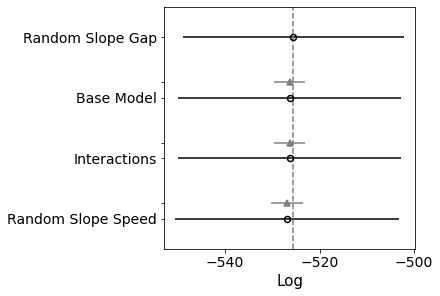

In [16]:
#Model comparison plot
az.plot_compare(compare_gap, insample_dev=False);

Since there is only a marginal improvement for the more complex models, the simple base model is chosen for further analysis

In [17]:
#Select model for further analysis
crossing_model = crossing_model
crossing_fitted = crossing_fitted

### Diagnostics

#### Priors

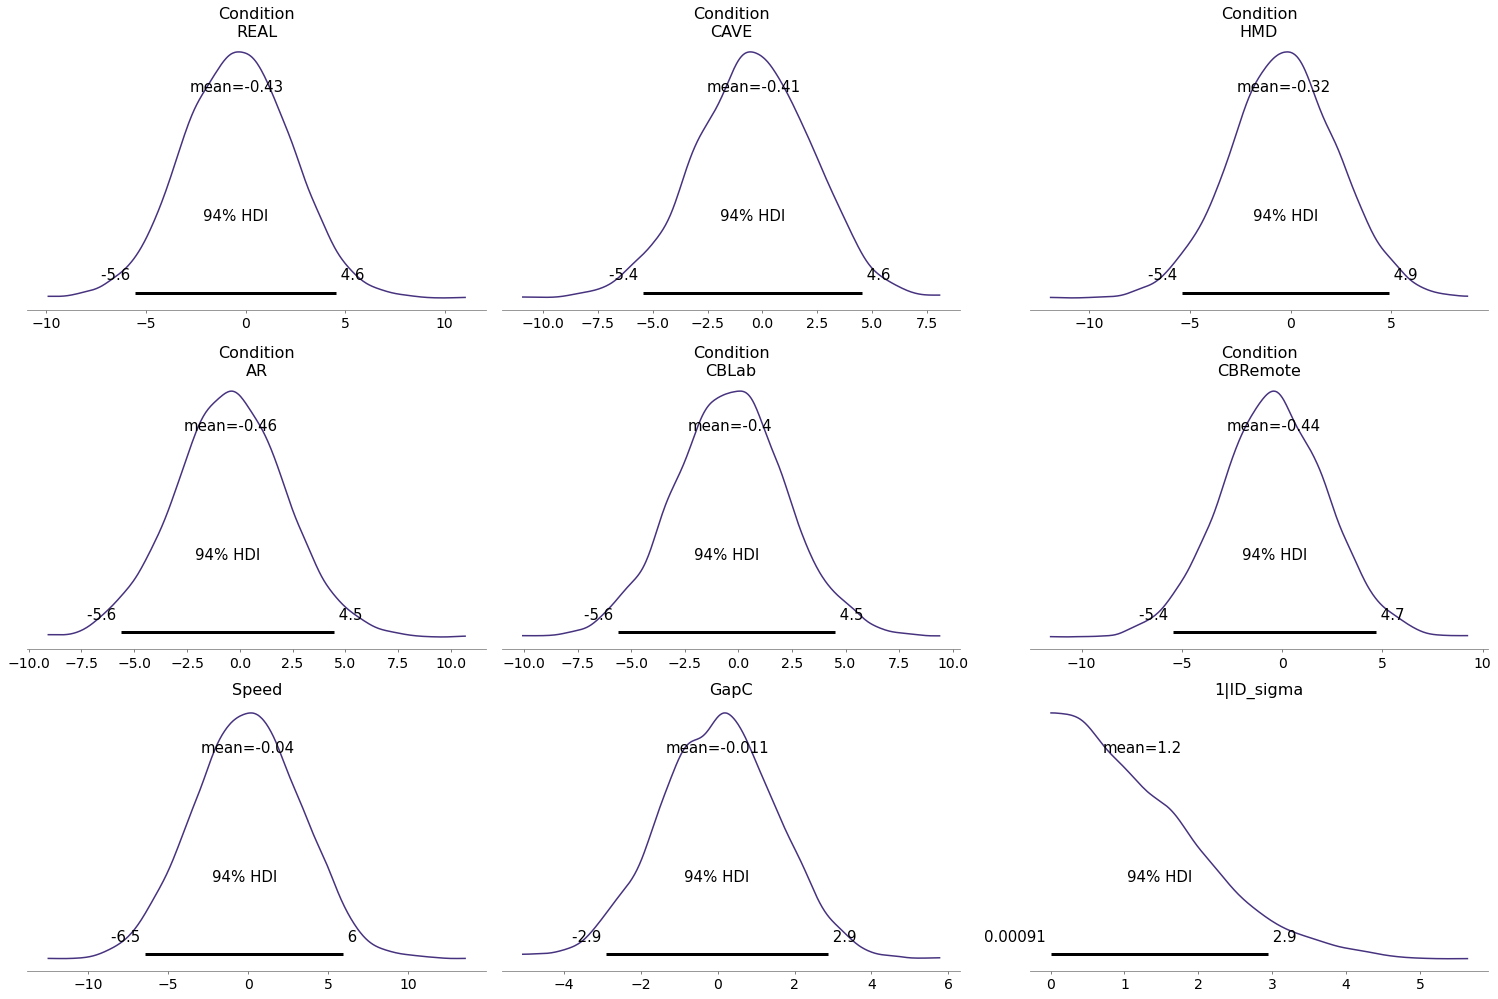

In [18]:
#Plot priors
crossing_model.plot_priors();

In [19]:
#Output model specification
crossing_model

Formula: Crossing ~ 0 + Condition + Speed + GapC + (1|ID)
Family name: Bernoulli
Link: logit
Observations: 1628
Priors:
  Condition ~ Normal(mu: -0.39830395, sigma: 2.64776732)
  Speed ~ Normal(mu: 0, sigma: 3.38464192)
  GapC ~ Normal(mu: 0, sigma: 1.56969468)
  1|ID ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.52868918))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

#### Fitting

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


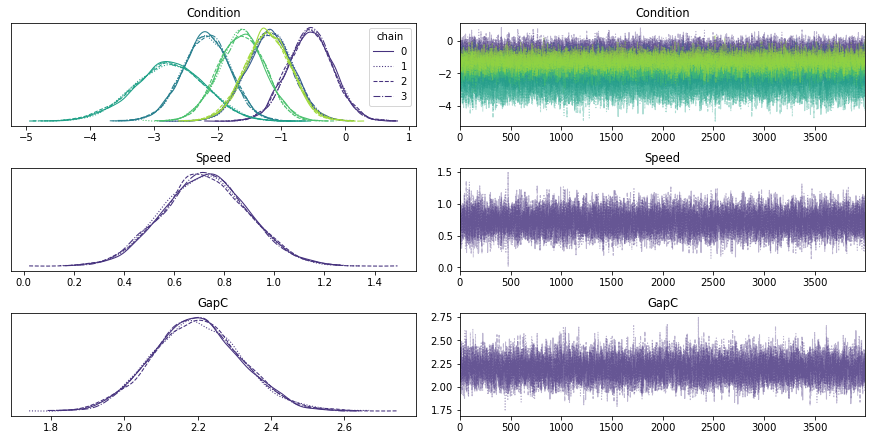

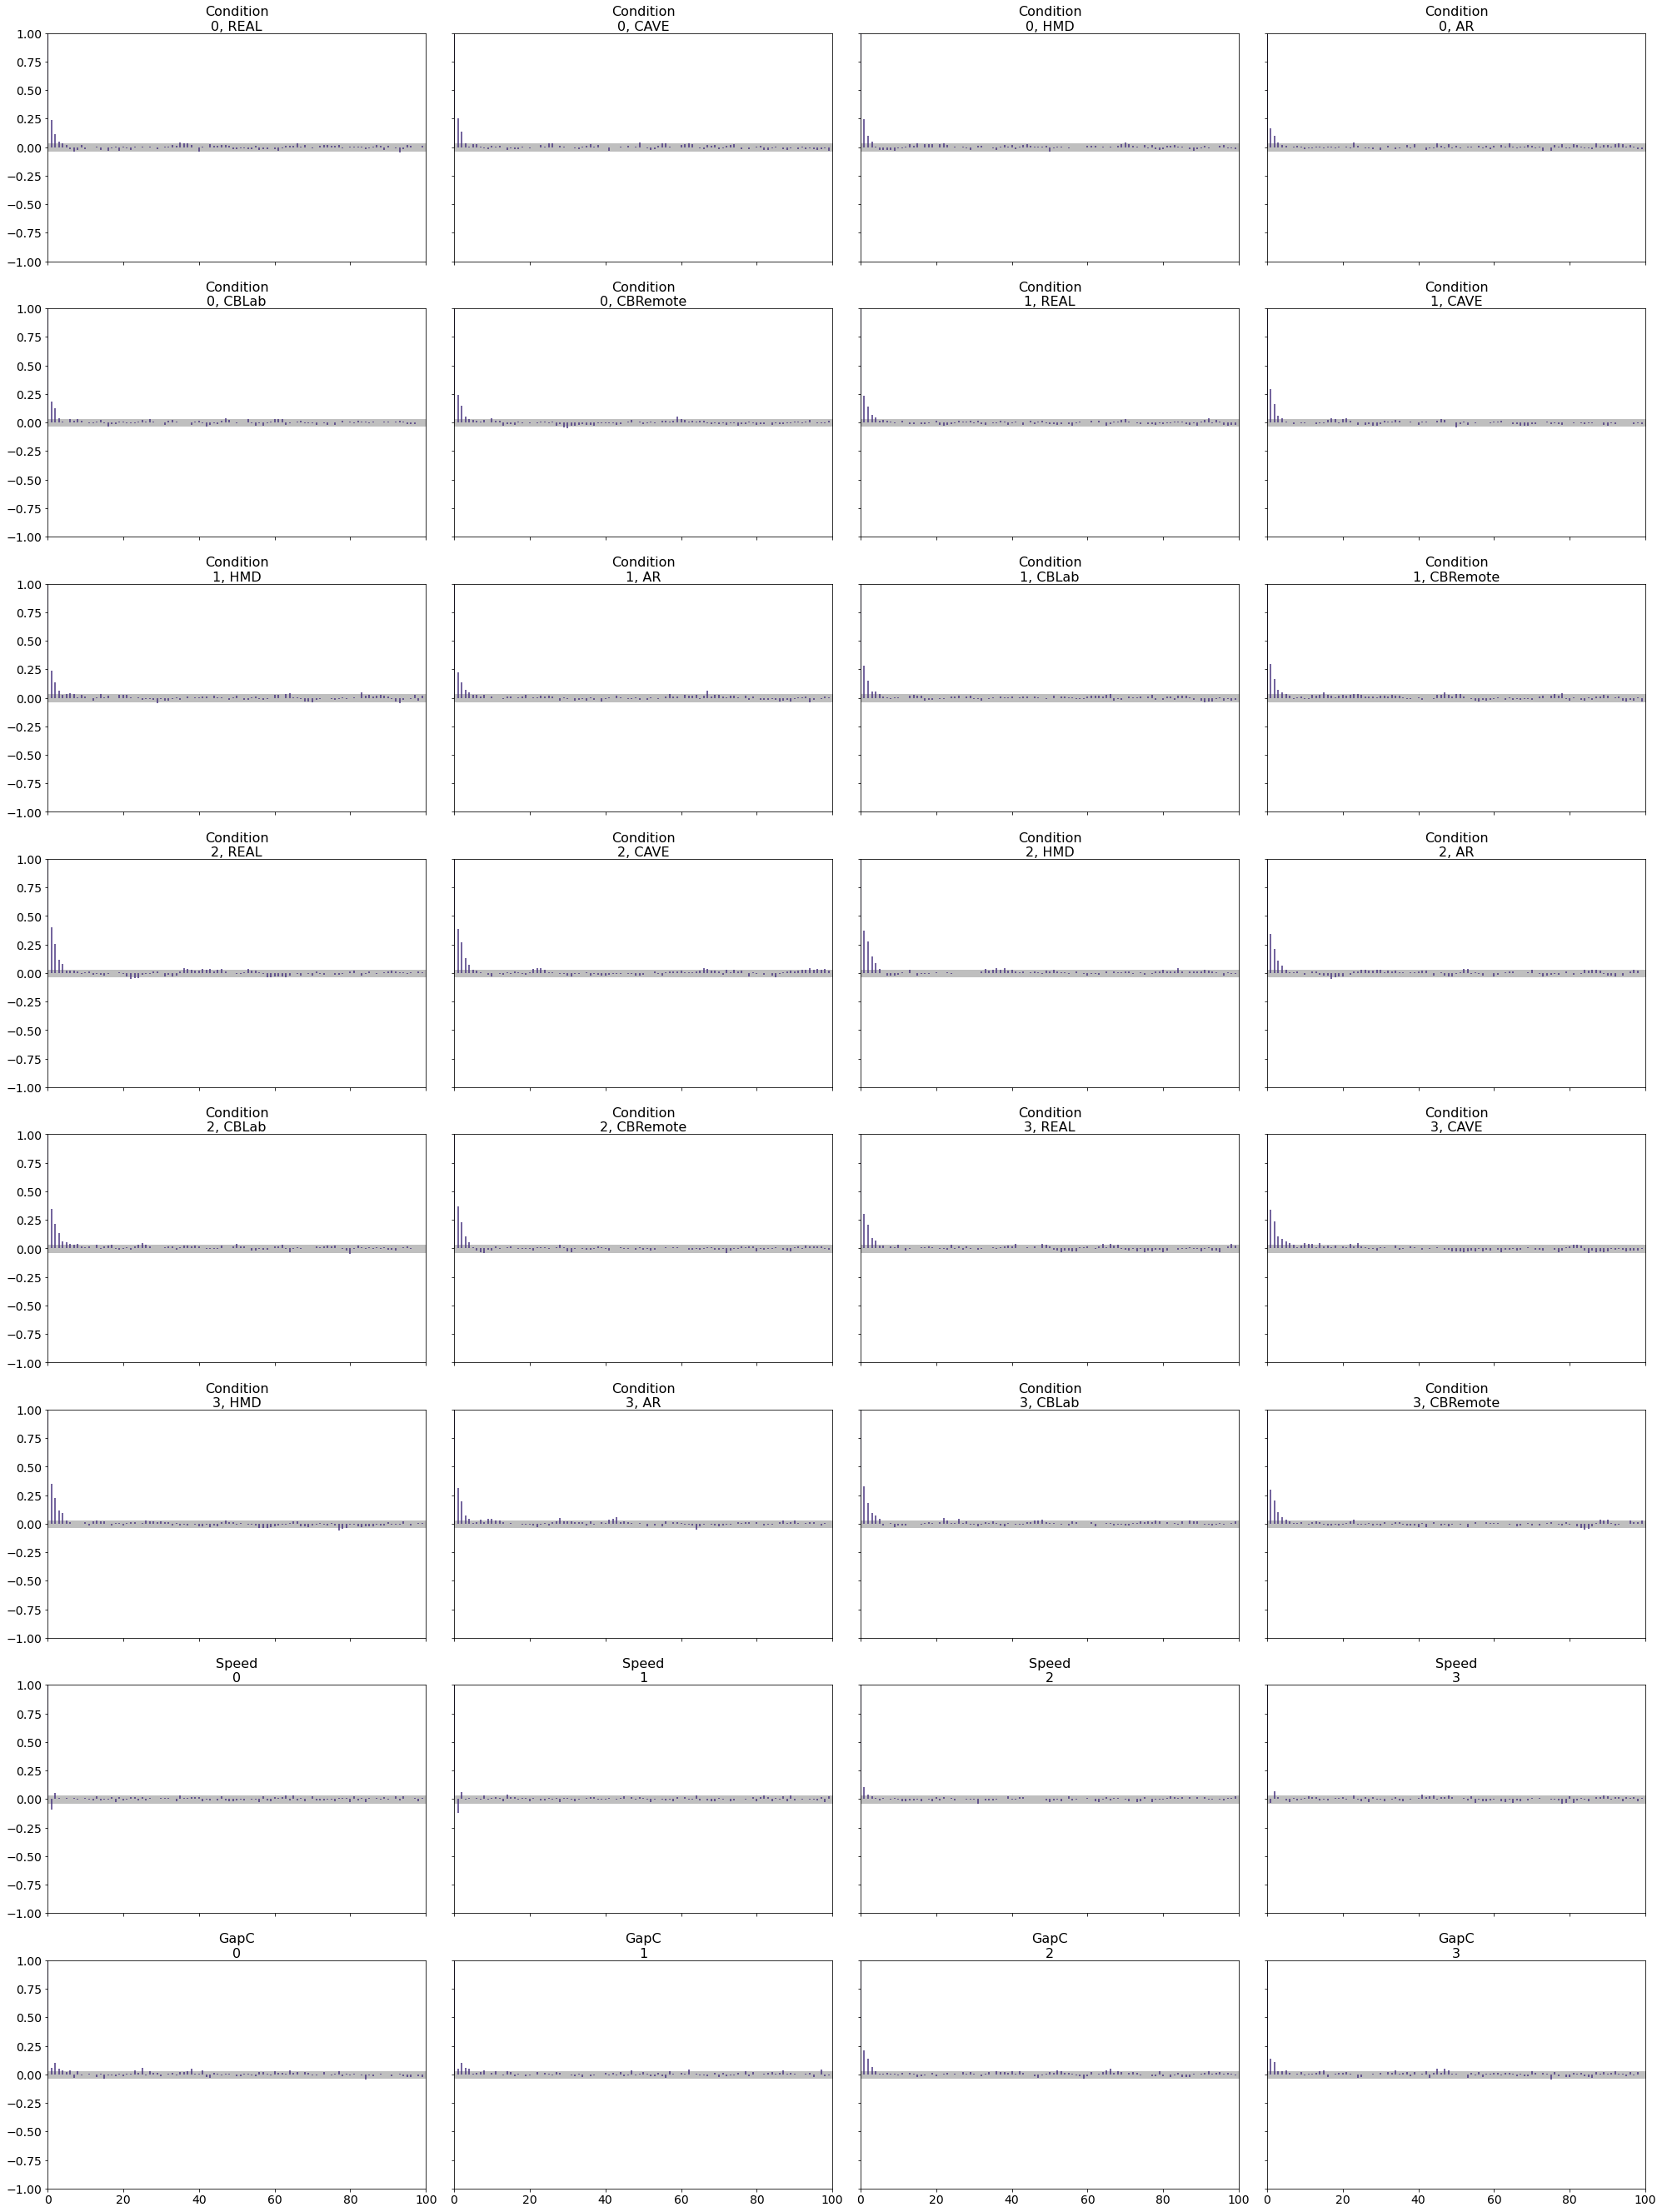

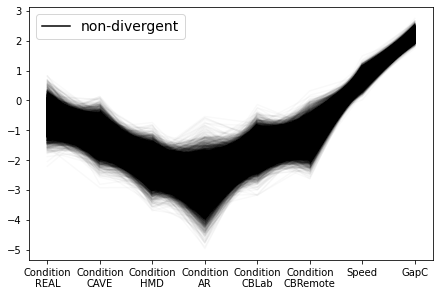

In [20]:
#Create posterior predictive
crossing_model.posterior_predictive(crossing_fitted, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(crossing_fitted,var_names=["~ID"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(crossing_fitted,var_names=["~ID"], filter_vars="regex", combined = False); #inspect autocorrelation
az.plot_ppc(crossing_fitted); #inspect posterior predictive check
az.plot_parallel(crossing_fitted,var_names=["~ID"], filter_vars="regex", legend = True); #inspect divergencies

### Inference

#### Posteriors

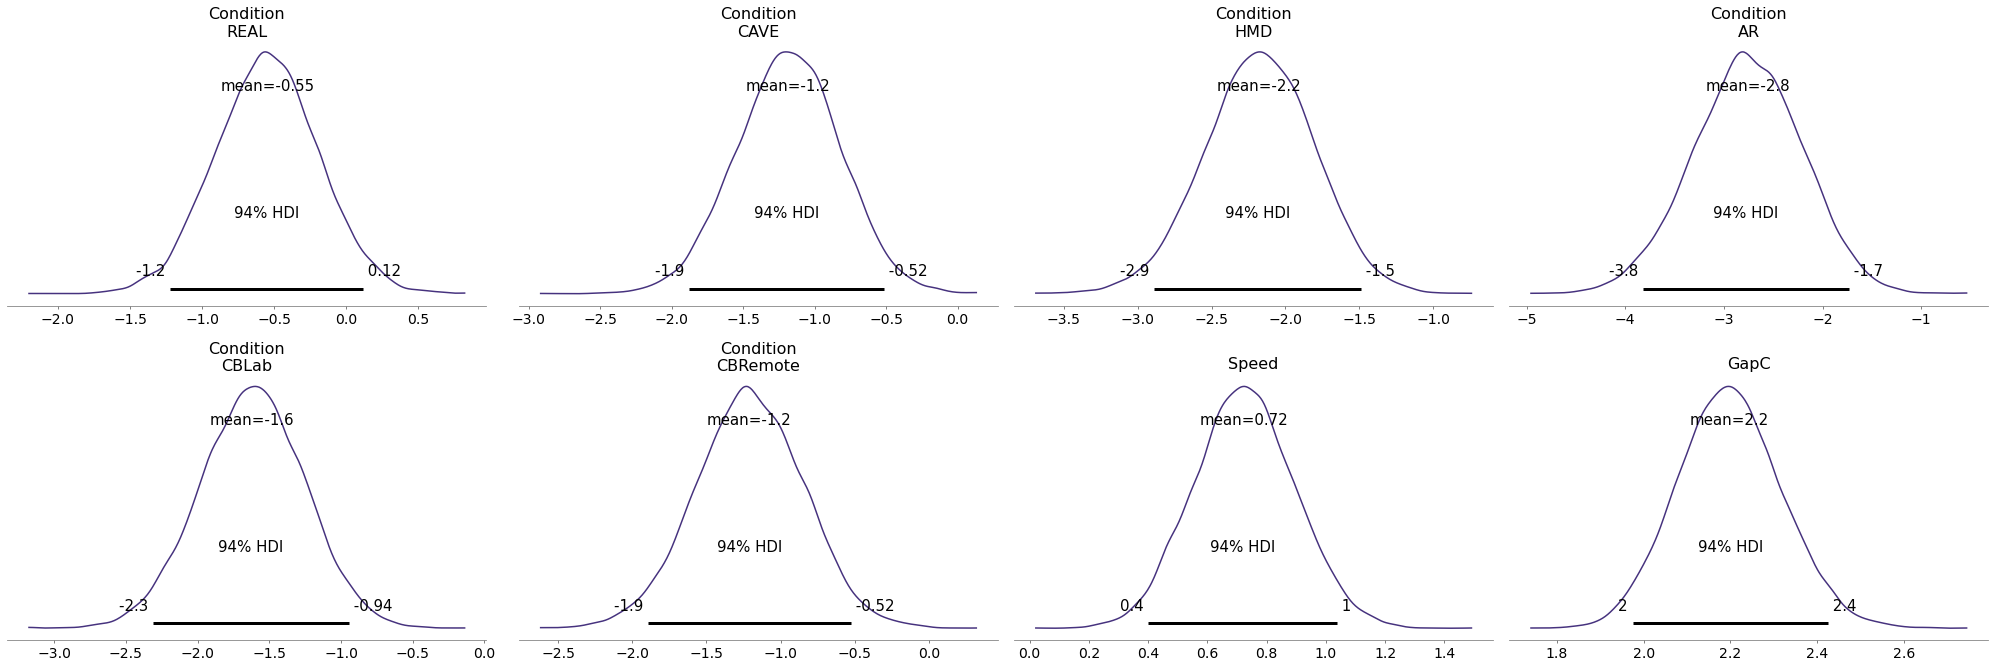

In [21]:
az.plot_posterior(crossing_fitted,var_names=["~ID"], filter_vars="regex"); #show posterior distributions

#### Differences

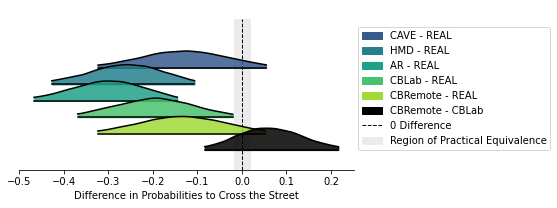

In [106]:
#Extract estimators' posterior distributions for each condition
REAL, CAVE, HMD, AR, CBLab, CBRemote = [crossing_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]] 

#Convert logits to probabilities
pREAL, pCAVE, pHMD, pAR, pCBLab, pCBRemote = [plogis(crossing_fitted.posterior['Condition'][:,:,x].values) for x in [0,1,2,3,4,5]]

#Calculate a acceptance standard deviation based on each individual's overall acceptance rate
crossing_std = df.groupby('ID')['Crossing'].mean().std()

###Plot###
fig, ax = plt.subplots(figsize=(6, 3)) #init figure
ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1) #create vertical 0 line

#Create ridgeplot
az.plot_forest([pCAVE - pREAL,pHMD - pREAL,pAR - pREAL,pCBLab - pREAL,pCBRemote - pREAL, pCBRemote - pCBLab], #Calculate differences of posterior distributions
                model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'], #Set names
                kind='ridgeplot',
                combined=True,
                ridgeplot_overlap=3,
                ridgeplot_alpha=0.85,
                colors=colors,
                ax=ax)
#Create ROPE in plot
ax.add_patch(matplotlib.patches.Rectangle((-0.1*crossing_std,-10), 0.2*crossing_std, 28, zorder=-100,color="#ebebeb"))

#Plot aesthetics
ax.spines['top'].set_color('white')
ax.set_yticks([])
ax.set(xlabel='Difference in Probabilities to Cross the Street')

#Creating the Legend
cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')
rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
ax.legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], 
          bbox_to_anchor=(1.3, 0.5),loc='center');

Output values of highest density intervals (HDIs)

In [25]:
#Create dataframe
HDIs = pd.DataFrame(np.array([np.concatenate((['pCAVE - pREAL'],az.hdi(az.convert_to_dataset(pCAVE - pREAL)).x.data)),
                       np.concatenate((['pHMD - pREAL'],az.hdi(az.convert_to_dataset(pHMD - pREAL)).x.data)),
                       np.concatenate((['pAR - pREAL'],az.hdi(az.convert_to_dataset(pAR - pREAL)).x.data)),
                       np.concatenate((['pCBLab - pREAL'],az.hdi(az.convert_to_dataset(pCBLab - pREAL)).x.data)),
                       np.concatenate((['pCBRemote - pREAL'],az.hdi(az.convert_to_dataset(pCBRemote - pREAL)).x.data)),
                       np.concatenate((['pCBRemote - pCBLab'],az.hdi(az.convert_to_dataset(pCBRemote - pCBLab)).x.data)),
                             ['ROPE',df.groupby('ID')['Crossing'].mean().std()*-0.1,df.groupby('ID')['Crossing'].mean().std()*0.1]]),
             columns=['Comparison', 'lowHDI', 'highHDI'])

#Set column data types
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})

#Round and output values
HDIs.round(3)

Comparison  lowHDI  highHDI
0       pCAVE - pREAL  -0.324    0.055
1        pHMD - pREAL  -0.428   -0.105
2         pAR - pREAL  -0.469   -0.144
3      pCBLab - pREAL  -0.369   -0.019
4   pCBRemote - pREAL  -0.325    0.053
5  pCBRemote - pCBLab  -0.084    0.217
6                ROPE  -0.018    0.018

## Crossing Initiation Time (CIT)

### Models

Base Model: mixed linear model to predict accepted crossings as a function of Condition, Speed and Gap size and Participant (ID) as random factor

(GapC = Gapsize [1,5] centered to [-2,2])

In [26]:
#Define model
cit_model = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (1|ID)",df, dropna=True,
                     categorical=["Condition","Speed"],family="gaussian")
#Fit model
cit_fitted = cit_model.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(cit_fitted,var_names=["~ID"], filter_vars="regex",)#.to_latex("cit_model_summary.tex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 160 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.437  0.073  -0.578   -0.303      0.001   
Condition[1]                  0.224  0.076   0.081    0.369      0.001   
Condition[2]                  0.015  0.077  -0.134    0.156      0.001   
Condition[3]                  0.212  0.121  -0.011    0.442      0.001   
Condition[4]                  0.050  0.078  -0.099    0.195      0.001   
Condition[5]                  0.154  0.077   0.013    0.302      0.001   
Speed                         0.212  0.025   0.165    0.258      0.000   
GapC                          0.057  0.016   0.028    0.087      0.000   
CrossingInitiationTime_sigma  0.300  0.010   0.281    0.318      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    5512.0    8769.0    1.0  
Condition[1]                    0.001    5890.0    8499.0    1.0  
Condition[2]                    0.001    6729.0   10100.0    1.0  
Condition[3]                    0.001    7324.0    9783.0    1.0  
Condition[4]                    0.001    6086.0    8330.0    1.0  
Condition[5]                    0.001    5928.0   10118.0    1.0  
Speed                           0.000   29229.0   12922.0    1.0  
GapC                            0.000   23346.0   12697.0    1.0  
CrossingInitiationTime_sigma    0.000   13841.0   12538.0    1.0

Base Model + two fold interactions of Condition with Speed and Gapsize

In [27]:
#Define model
cit_model_interactions = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + Condition:Speed + Condition:GapC + (1|ID)",
                                   df, dropna=True,categorical=["Condition","Speed"],family="gaussian")

#Fit model
cit_fitted_interactions = cit_model_interactions.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(cit_fitted_interactions,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, 1|ID_offset, 1|ID_sigma, Condition:GapC, Condition:Speed, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 191 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.415  0.082  -0.572   -0.267      0.002   
Condition[1]                  0.102  0.088  -0.066    0.267      0.002   
Condition[2]                  0.012  0.103  -0.179    0.207      0.001   
Condition[3]                  0.147  0.183  -0.204    0.483      0.002   
Condition[4]                  0.061  0.096  -0.119    0.241      0.001   
Condition[5]                  0.327  0.102   0.134    0.517      0.001   
Speed                         0.222  0.051   0.127    0.319      0.001   
GapC                          0.034  0.031  -0.022    0.092      0.000   
Condition:Speed[0]            0.131  0.074  -0.009    0.271      0.001   
Condition:Speed[1]            0.024  0.079  -0.121    0.173      0.001   
Condition:Speed[2]            0.014  0.116  -0.198    0.235      0.001   
Condition:Speed[3]           -0.092  0.078  -0.234    0.058      0.001   
Condition:Speed[4]           -0.146  0.079  -0.299   -0.002      0.001   
Condition:GapC[0]             0.059  0.043  -0.019    0.143      0.001   
Condition:GapC[1]             0.011  0.053  -0.088    0.112      0.001   
Condition:GapC[2]             0.058  0.085  -0.099    0.220      0.001   
Condition:GapC[3]             0.053  0.048  -0.035    0.145      0.001   
Condition:GapC[4]            -0.044  0.052  -0.139    0.056      0.001   
CrossingInitiationTime_sigma  0.297  0.010   0.279    0.316      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    2806.0    5667.0    1.0  
Condition[1]                    0.001    3437.0    7299.0    1.0  
Condition[2]                    0.001    4914.0    8841.0    1.0  
Condition[3]                    0.002    5654.0    8196.0    1.0  
Condition[4]                    0.001    4142.0    7410.0    1.0  
Condition[5]                    0.001    4706.0    7506.0    1.0  
Speed                           0.001    5023.0    7923.0    1.0  
GapC                            0.000    5426.0    8826.0    1.0  
Condition:Speed[0]              0.001    7321.0    9478.0    1.0  
Condition:Speed[1]              0.001    7732.0   10980.0    1.0  
Condition:Speed[2]              0.001    9289.0   10901.0    1.0  
Condition:Speed[3]              0.001    7148.0    9992.0    1.0  
Condition:Speed[4]              0.001    7068.0   10586.0    1.0  
Condition:GapC[0]               0.000    6815.0    9914.0    1.0  
Condition:GapC[1]               0.000    7686.0    9066.0    1.0  
Condition:GapC[2]               0.001    9765.0   11419.0    1.0  
Condition:GapC[3]               0.000    7059.0   10719.0    1.0  
Condition:GapC[4]               0.000    7681.0   10758.0    1.0  
CrossingInitiationTime_sigma    0.000   12151.0   12268.0    1.0

Base Model + random slope for Gap size

In [28]:
#Define model
cit_model_slope_gap = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (GapC|ID)",df, dropna=True,
                                  categorical=["Condition","Speed"],family="gaussian")

#Fit model
cit_fitted_slope_gap = cit_model_slope_gap.fit(cores=4,draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(cit_fitted_slope_gap,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, GapC|ID_offset, GapC|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 173 seconds.
The number of effective samples is smaller than 10% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.437  0.072  -0.571   -0.300      0.001   
Condition[1]                  0.222  0.075   0.083    0.365      0.001   
Condition[2]                  0.013  0.078  -0.135    0.158      0.001   
Condition[3]                  0.213  0.121  -0.018    0.438      0.002   
Condition[4]                  0.049  0.076  -0.091    0.196      0.001   
Condition[5]                  0.155  0.077   0.014    0.302      0.001   
Speed                         0.213  0.024   0.168    0.260      0.000   
GapC                          0.057  0.016   0.027    0.088      0.000   
CrossingInitiationTime_sigma  0.298  0.010   0.280    0.317      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    4067.0    6629.0    1.0  
Condition[1]                    0.001    3737.0    7156.0    1.0  
Condition[2]                    0.001    4466.0    7806.0    1.0  
Condition[3]                    0.001    5703.0    8291.0    1.0  
Condition[4]                    0.001    4435.0    8336.0    1.0  
Condition[5]                    0.001    4520.0    8057.0    1.0  
Speed                           0.000   23108.0   12679.0    1.0  
GapC                            0.000   14670.0   12748.0    1.0  
CrossingInitiationTime_sigma    0.000   10265.0   11834.0    1.0

Base Model + random slope for Speed

In [29]:
#Define model
cit_model_slope_speed = bmb.Model("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (Speed|ID)",df, dropna=True,
                                  categorical=["Condition","Speed"],family="gaussian")

#Fit model
cit_fitted_slope_speed = cit_model_slope_speed.fit(draws=4000, target_accept=0.99, random_seed=RANDOM_SEED)

#Show model summary
az.summary(cit_fitted_slope_speed,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, Speed[50]|ID_offset, Speed[50]|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 167 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.440  0.074  -0.578   -0.299      0.001   
Condition[1]                  0.219  0.076   0.075    0.363      0.001   
Condition[2]                  0.016  0.079  -0.129    0.168      0.001   
Condition[3]                  0.213  0.123  -0.012    0.446      0.002   
Condition[4]                  0.052  0.078  -0.096    0.194      0.001   
Condition[5]                  0.158  0.078   0.008    0.304      0.001   
Speed                         0.212  0.025   0.165    0.259      0.000   
GapC                          0.057  0.016   0.027    0.086      0.000   
CrossingInitiationTime_sigma  0.296  0.010   0.277    0.316      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    3868.0    7163.0    1.0  
Condition[1]                    0.001    4270.0    7546.0    1.0  
Condition[2]                    0.001    3805.0    7547.0    1.0  
Condition[3]                    0.001    5353.0    8864.0    1.0  
Condition[4]                    0.001    4458.0    7570.0    1.0  
Condition[5]                    0.001    4399.0    7821.0    1.0  
Speed                           0.000   20819.0   13532.0    1.0  
GapC                            0.000   15618.0   12362.0    1.0  
CrossingInitiationTime_sigma    0.000    6368.0    8392.0    1.0

Model Comparison

In [30]:
#Creating dict with all models
compare_dict = {"No Interactions": cit_fitted,
                "Interactions": cit_fitted_interactions,
                "Random Slope Gap": cit_fitted_slope_gap,
                "Random Slope Speed":cit_fitted_slope_speed}

#Use arviz compare for model comparison
compare_cit = az.compare(compare_dict, ic="loo",seed = RANDOM_SEED)

#Output comparison
compare_cit

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work 

rank         loo       p_loo     d_loo        weight  \
Random Slope Speed     0 -223.274175  151.125808  0.000000  5.221210e-01   
Interactions           1 -224.506407  149.784368  1.232232  4.778790e-01   
No Interactions        2 -225.105002  143.977839  1.830827  2.110342e-15   
Random Slope Gap       3 -225.284875  148.637365  2.010700  0.000000e+00   

                           se       dse  warning loo_scale  
Random Slope Speed  33.949787  0.000000     True       log  
Interactions        34.656551  5.514370     True       log  
No Interactions     34.519799  1.387606     True       log  
Random Slope Gap    34.218193  1.508959     True       log

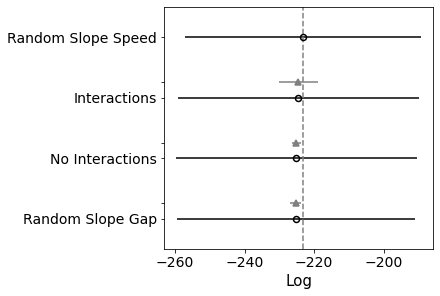

In [31]:
#Model comparison plot
az.plot_compare(compare_cit, insample_dev=False);

Since there is only a marginal improvement for the more complex models, the simple base model is chosen for further analysis

In [32]:
#Select model for further analysis
cit_model = cit_model
cit_fitted = cit_fitted

### Diagnostics

#### Priors

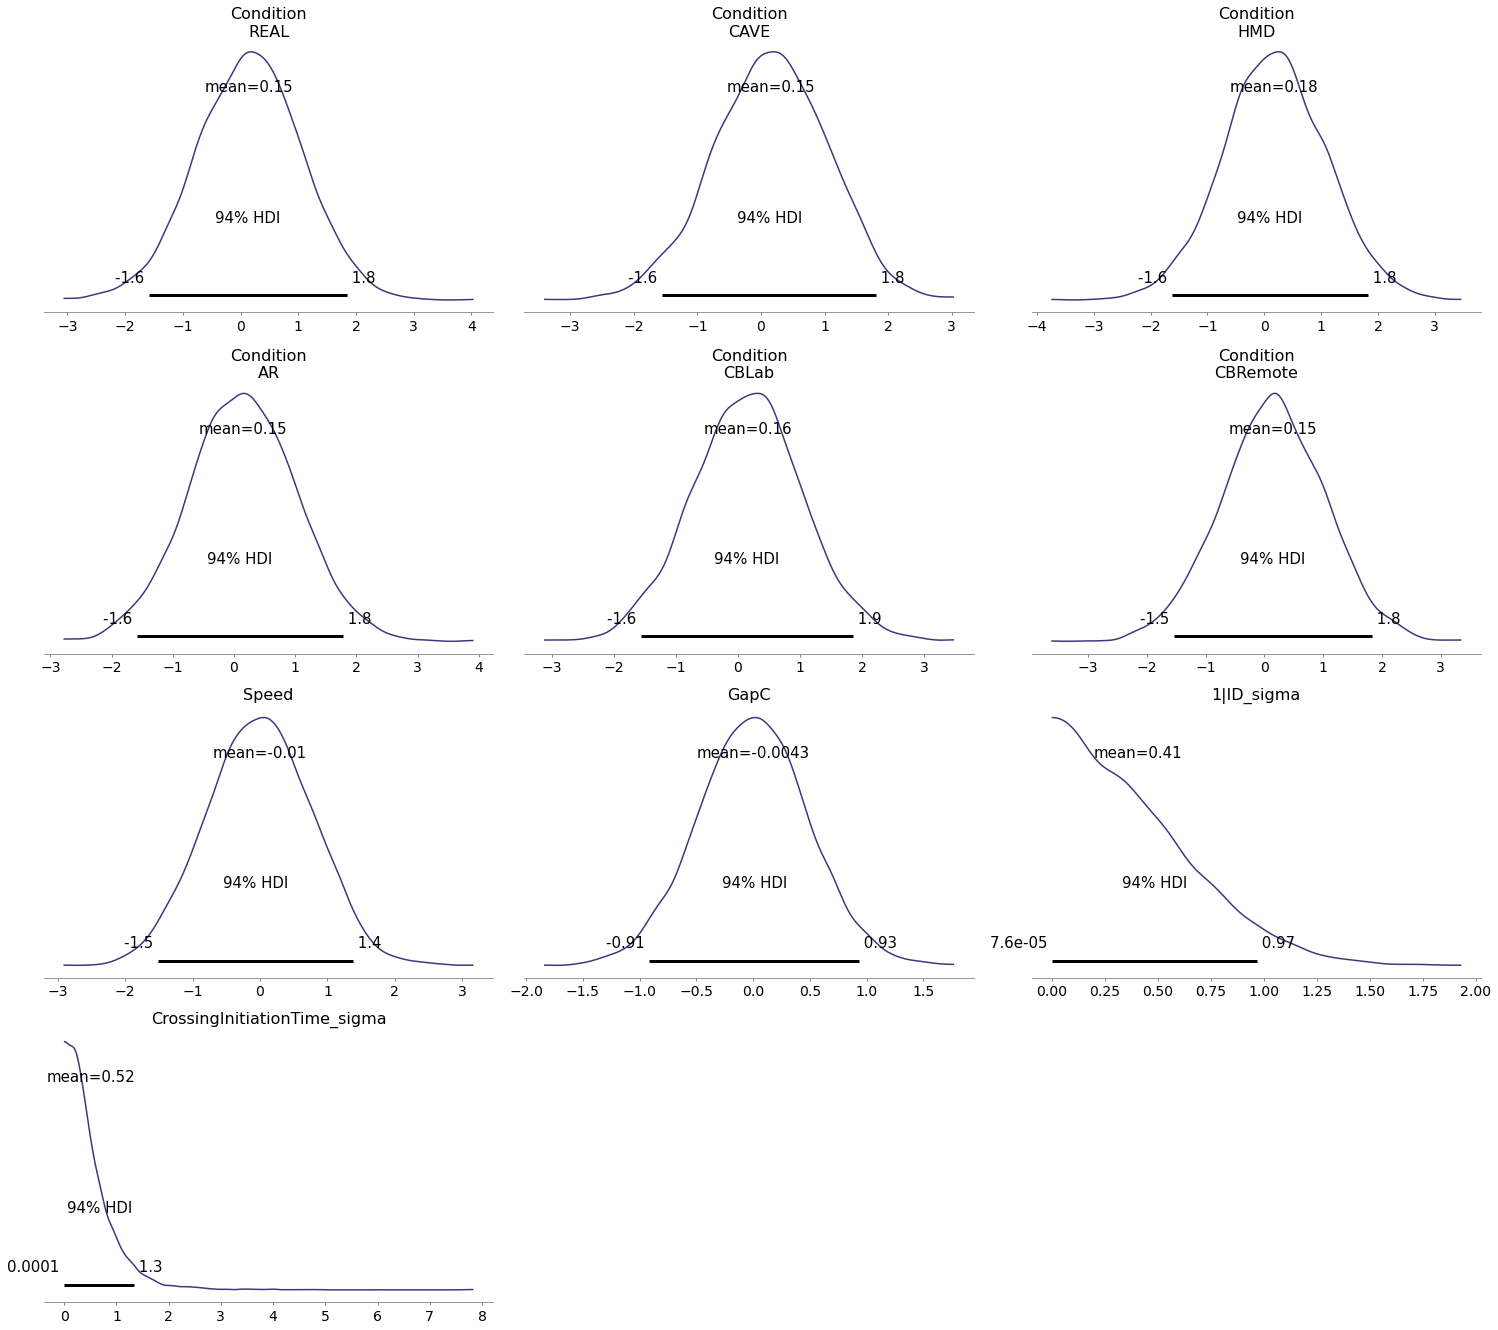

In [33]:
#Plot priors
cit_model.plot_priors();

In [34]:
#Output model specification
cit_model

Formula: CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (1|ID)
Family name: Gaussian
Link: identity
Observations: 633
Priors:
  Condition ~ Normal(mu: 0.15890205, sigma: 0.89545075)
  Speed ~ Normal(mu: 0, sigma: 0.78679452)
  GapC ~ Normal(mu: 0, sigma: 0.48447313)
  1|ID ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.51698873))
  sigma ~ HalfStudentT(nu: 4, sigma: 0.51529765)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

#### Fitting

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


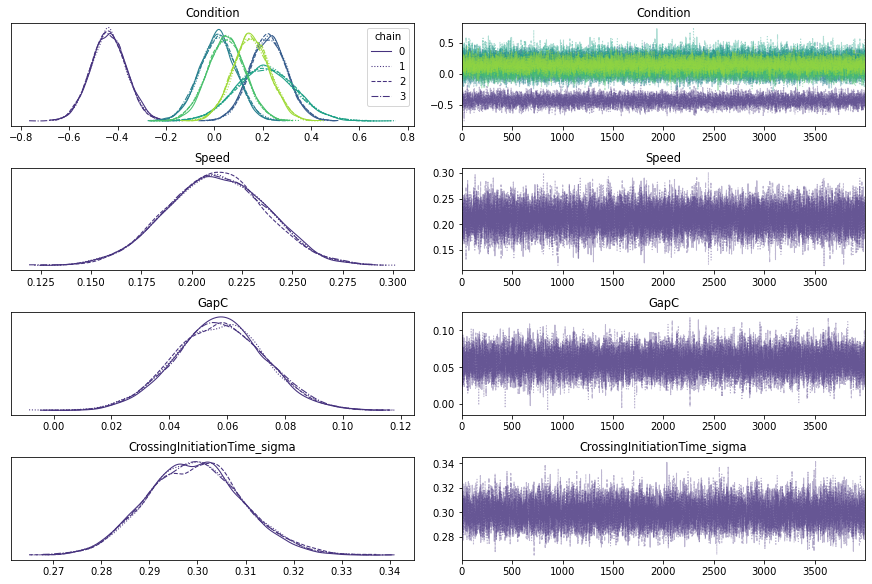

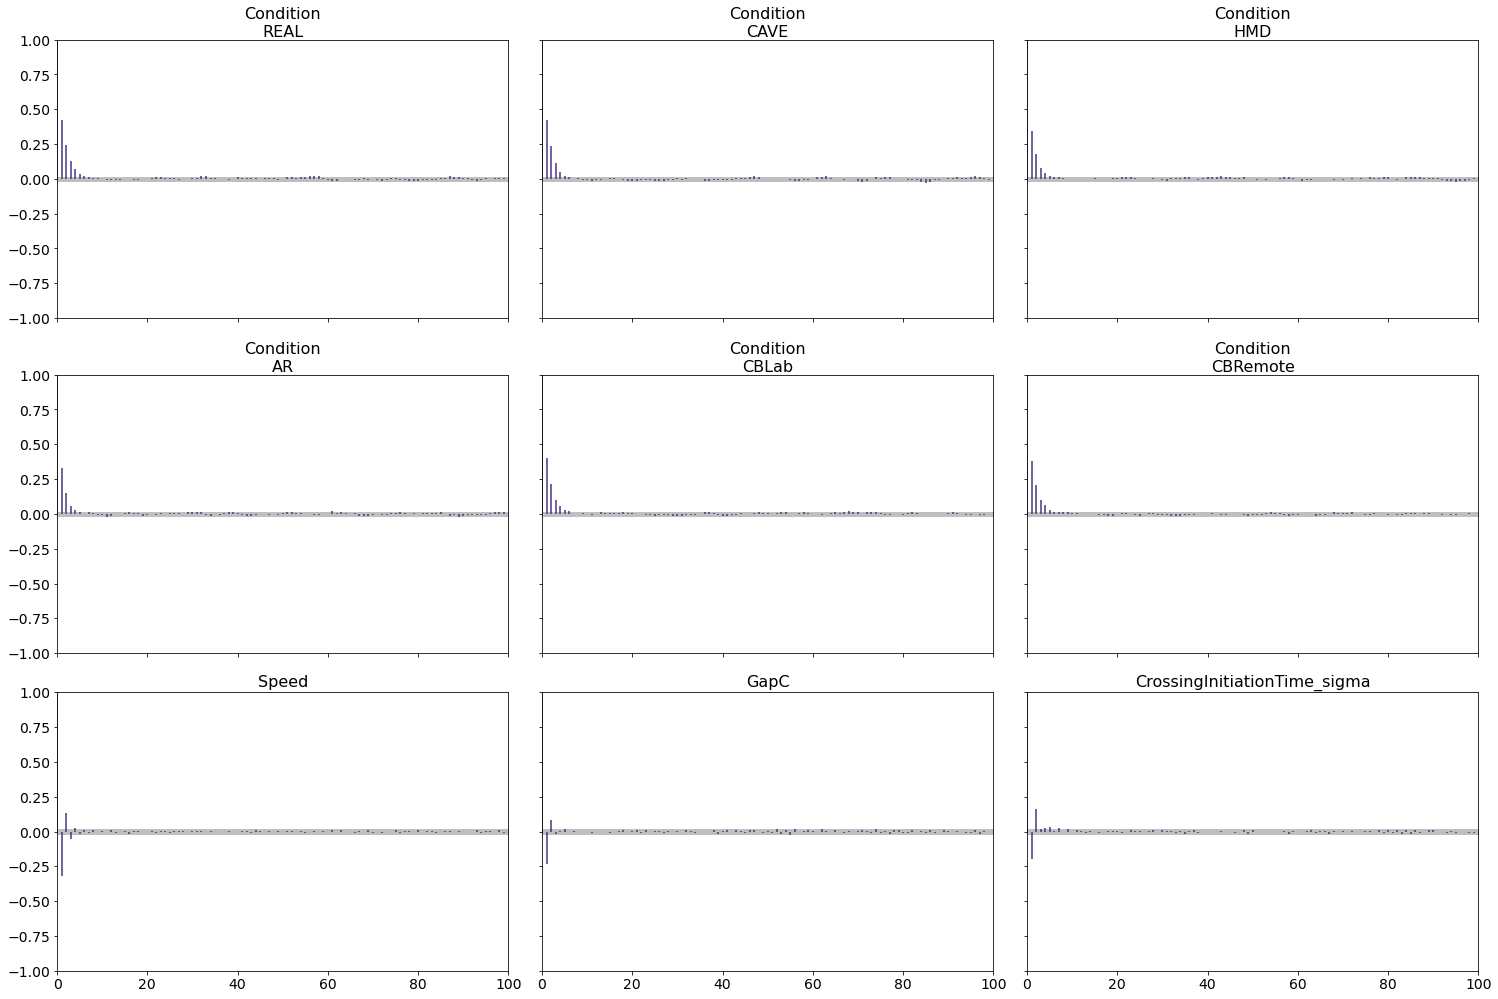

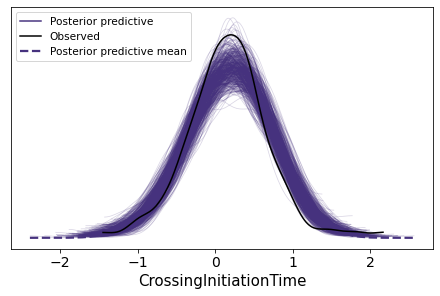

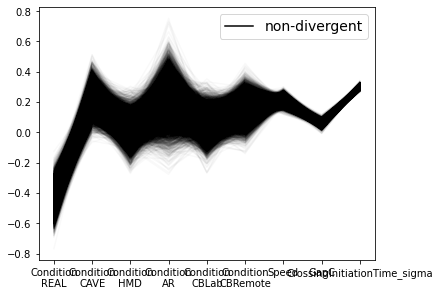

In [35]:
#Create posterior predictive
posterior_predictive = cit_model.posterior_predictive(cit_fitted, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(cit_fitted,var_names=["~ID"], filter_vars="regex", legend=True, compact=True); #inspect trace plots
az.plot_autocorr(cit_fitted,var_names=["~ID"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(cit_fitted); #inspect posterior predictive check
az.plot_parallel(cit_fitted,var_names=["~ID"], filter_vars="regex", legend = True); #inspect divergencies

#### High influential data points

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


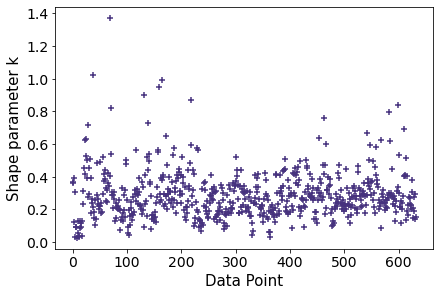

In [36]:
# compute pointwise LOO
loo = az.loo(cit_fitted, pointwise=True)
# plot kappa values
az.plot_khat(loo.pareto_k);

In [37]:
#Output points with high influence
df[df['CrossingInitiationTime'].notnull()].reset_index()[loo.pareto_k.values>=0.7]

index  Trial Speed  Gap  Crossing  CrossingInitiationTime Condition  \
28      67     10    30    5         1                  -1.001      CAVE   
38     109     12    30    5         1                   1.967      CAVE   
69     182      5    50    4         1                   2.166      CAVE   
70     186      9    30    5         1                  -0.668      CAVE   
132    311     11    50    4         1                   1.503       HMD   
138    335      5    50    5         1                   1.771       HMD   
159    389      9    30    5         1                   1.415       HMD   
164    408      8    50    5         1                  -0.769       HMD   
217    565      7    50    4         1                   1.374       HMD   
462   1156     11    50    4         1                  -0.056  CBRemote   
583   1501      6    50    5         1                   0.058  CBRemote   
599   1552      7    30    5         1                   2.134  CBRemote   

              ID  GapC  
28       14_CAVE     2  
38       20_CAVE     2  
69       41_CAVE     1  
70       41_CAVE     2  
132       62_HMD     1  
138       33_HMD     2  
159        8_HMD     2  
164        9_HMD     2  
217       29_HMD     1  
462  13_CBRemote     1  
583  48_CBRemote     2  
599  53_CBRemote     2

### Inference

#### Posteriors

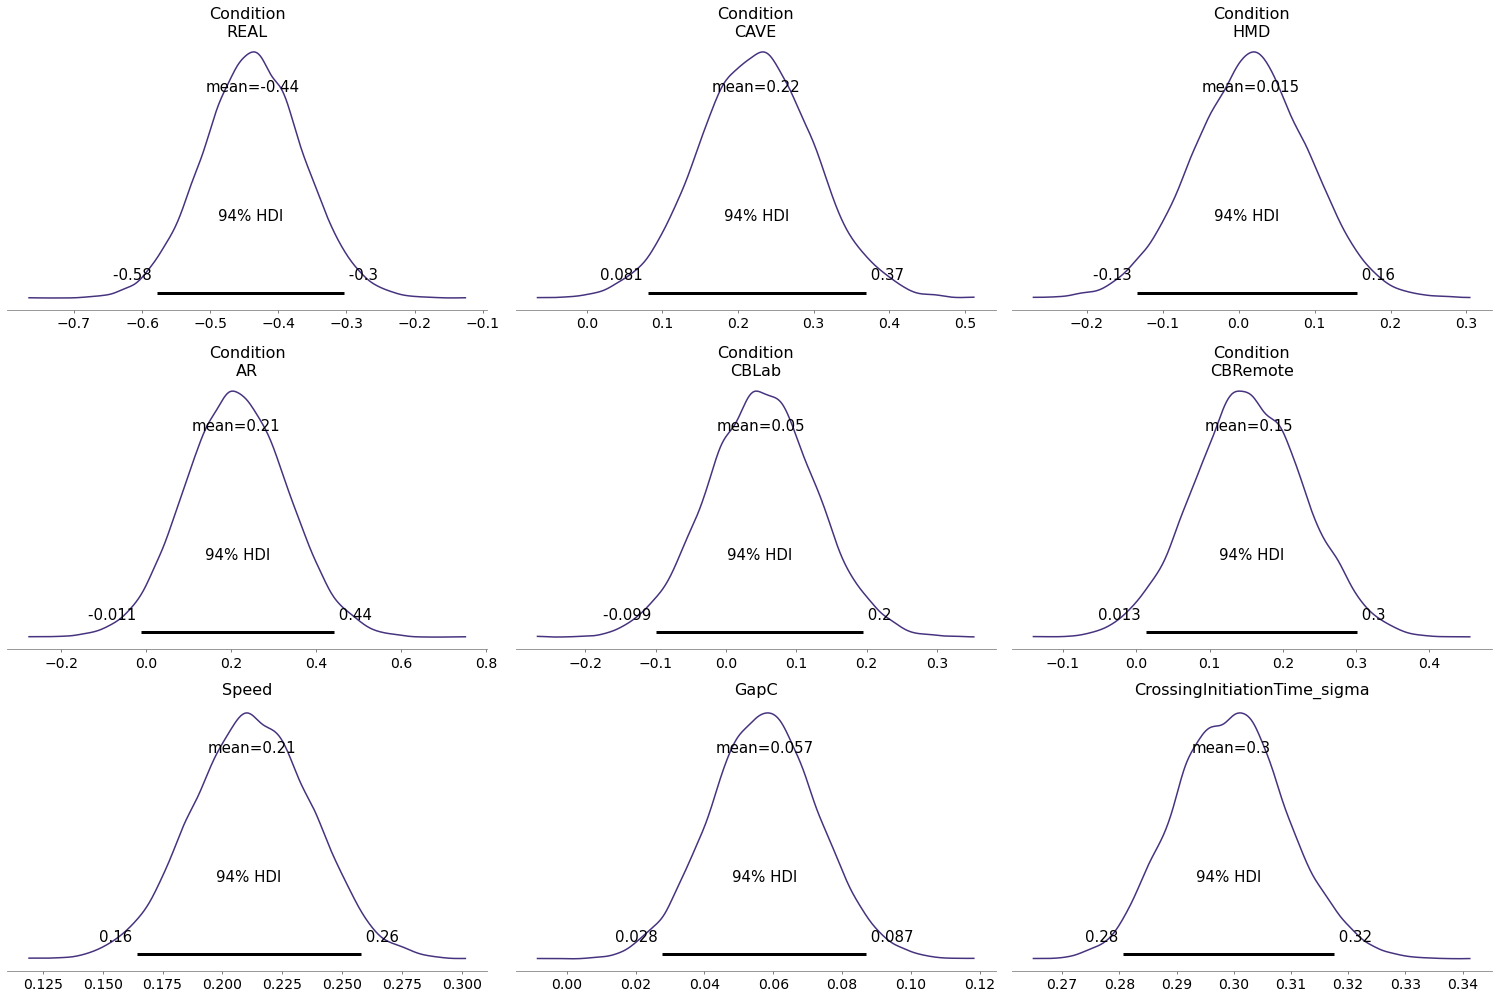

In [38]:
az.plot_posterior(cit_fitted,var_names=["~ID"], filter_vars="regex"); #show posterior distributions

#### Differences

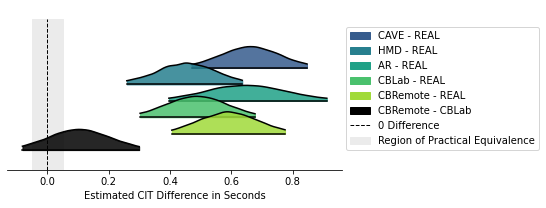

In [39]:
#Extract estimators' posterior distributions for each condition
REAL, CAVE, HMD, AR, CBLab, CBRemote = [cit_fitted.posterior['Condition'][:,:,diff].values for diff in [0,1,2,3,4,5]]

#CIT sd to define the ROPE
cit_sd = df['CrossingInitiationTime'].std()

###Plot###
fig, ax = plt.subplots(figsize=(6, 3)) #init figure
ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1) #create vertical 0 line

#Create ridgeplot
az.plot_forest([CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL, CBRemote - CBLab], #Calculate differences of posterior distributions
                model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'], #Set names
                kind='ridgeplot',
                combined=True,
                ridgeplot_overlap=3,
                ridgeplot_alpha=0.85,
                colors=colors,
                ax=ax)
#Create ROPE in plot
ax.add_patch(matplotlib.patches.Rectangle((-0.1*cit_sd,-10), 0.2*cit_sd, 28, zorder=-100,color="#ebebeb"))

#Plot aesthetics
ax.spines['top'].set_color('white')
ax.set_yticks([])
ax.set(xlabel='Estimated CIT Difference in Seconds')

#Creating the Legend
cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')
rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
ax.legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], 
          bbox_to_anchor=(1.3, 0.5),loc='center');

Output values of highest density intervals (HDIs)

In [40]:
#Create dataframe
HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                       np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                       np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                       np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                       np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                       np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                             ['ROPE',cit_sd*-0.1,cit_sd*0.1]]),
             columns=['Comparison', 'lowHDI', 'highHDI'])

#Set column data types
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})
HDIs.round(3)

Comparison  lowHDI  highHDI
0       CAVE - REAL   0.471    0.849
1        HMD - REAL   0.258    0.637
2         AR - REAL   0.395    0.914
3      CBLab - REAL   0.302    0.678
4   CBRemote - REAL   0.406    0.777
5  CBRemote - CBLab  -0.082    0.300
6              ROPE  -0.052    0.052

## Subjective Data

Q1: How safe would it have been to cross the street?

Q2: How likely would a collision have been?

Q3: How dangerous would a collision have been?

Q4: How similar to real world traffic was your behavior in cases when you crossed the street?

Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?

Q6: Compared to usual, my choices were safe / unsafe

Q7: Compared to usual, deciding to cross the street was easy / difficult

Q8: Compared to usual, making a decision took longer / shorter

### How safe would it have been to cross the street?

In [41]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q1"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

1   -4.39
2   -1.71
3    1.19
4     inf
Name: Q1, dtype: float64

Creating an ordered logistic regression based on https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24

In [42]:
with pm.Model() as Q1_model:
    #Defining cut points
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    
    #Creating normal priors for each condition
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies.CBRemote.values)
    
    #Model equation
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)
    Q1 = pm.OrderedLogistic("Q1", eta, cutpoints, observed=df_subjectives["Q1"].values -1)
    
    #Fit model    
    trace_Q1 = pm.sample(return_inferencedata=True, tune = 1000, target_accept=0.85, random_seed=RANDOM_SEED)

#Posterior distributions for conditions
REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q1.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]

#Calculate differences of posterior distributions
Q1_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(trace_Q1, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.81  0.34    0.18     1.48       0.01     0.00   3894.41   
bCAVE        -0.33  0.34   -0.99     0.27       0.01     0.00   3997.02   
bHMD          0.03  0.34   -0.61     0.65       0.01     0.01   3982.64   
bAR           0.28  0.41   -0.49     1.02       0.01     0.01   4351.62   
bCBLab       -0.52  0.34   -1.17     0.11       0.01     0.00   3793.10   
bCBRemote     0.18  0.34   -0.47     0.78       0.01     0.00   4212.81   
cutpoints[0] -3.95  0.53   -4.93    -2.96       0.01     0.01   3001.34   
cutpoints[1] -1.67  0.28   -2.21    -1.16       0.00     0.00   3160.10   
cutpoints[2]  1.32  0.27    0.78     1.80       0.00     0.00   3020.97   

              ess_tail  r_hat  
bREAL          2883.32    1.0  
bCAVE          2926.13    1.0  
bHMD           2732.10    1.0  
bAR            2390.01    1.0  
bCBLab         2834.48    1.0  
bCBRemote      3020.49    1.0  
cutpoints[0]   2087.57    1.0  
cutpoints[1]   2798.43    1.0  
cutpoints[2]   2890.46    1.0

Model diagnostics

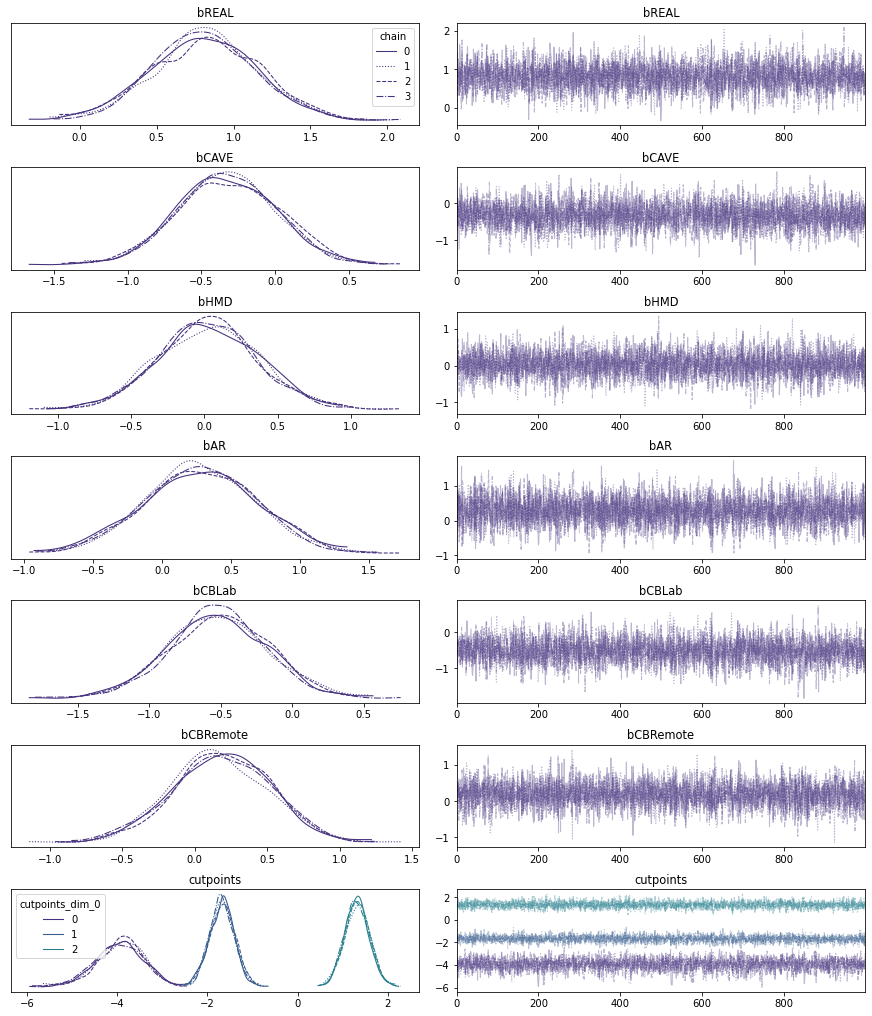

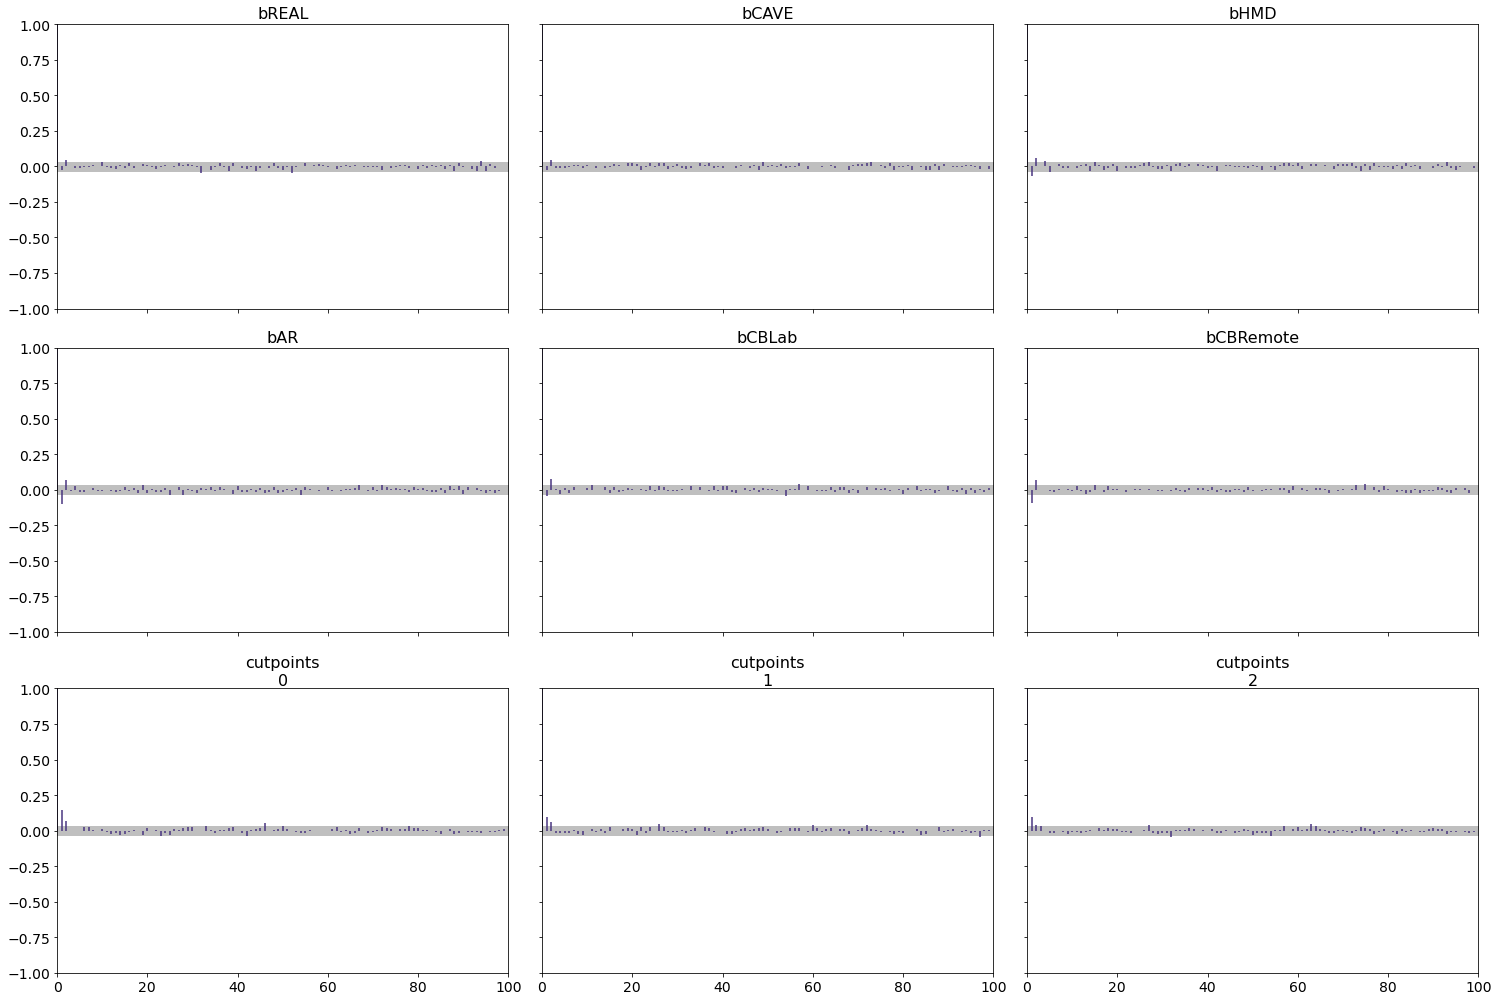

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


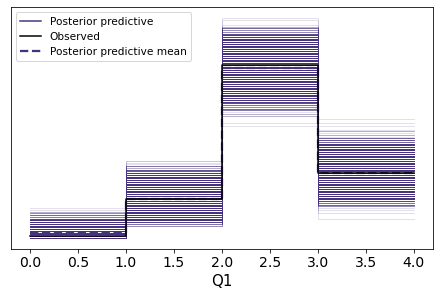

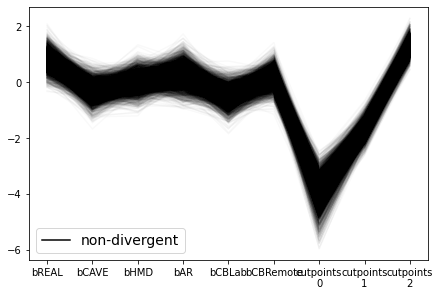

In [43]:
#Create posterior predictive
with Q1_model:
    ppc = pm.sample_posterior_predictive(trace_Q1, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(trace_Q1,var_names=["~eta"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(trace_Q1,var_names=["~eta"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q1_model)); #inspect posterior predictive check
az.plot_parallel(trace_Q1,var_names=["~eta"], filter_vars="regex", legend = True); #inspect divergencies

In [44]:
#Warning: prints the HDIs of the last run model
printHDIs('Q1')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -1.886   -0.353       smaller
1        HMD - REAL  -1.585   -0.013  inconclusive
2         AR - REAL  -1.468    0.340  inconclusive
3      CBLab - REAL  -2.119   -0.539       smaller
4   CBRemote - REAL  -1.419    0.155  inconclusive
5  CBRemote - CBLab  -0.111    1.481  inconclusive
6              ROPE  -0.065    0.065  inconclusive

### How likely would a collision have been?

In [45]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q2"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

1   -0.57
2    2.03
3    3.45
4     inf
Name: Q2, dtype: float64

Creating an ordered logistic regression based on https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24

In [46]:
with pm.Model() as Q2_model:
    #Defining cut points
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    
    #Creating normal priors for each condition
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies.CBRemote.values)
    
    #Model equation
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)
    Q2 = pm.OrderedLogistic("Q2", eta, cutpoints, observed=df_subjectives["Q2"].values -1)
    
    #Fit model
    trace_Q2 = pm.sample(return_inferencedata=True, tune = 1000, target_accept=0.85, random_seed=RANDOM_SEED)

#Posterior distributions for conditions
REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q2.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]

#Calculate differences of posterior distributions
Q2_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(trace_Q2, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.22  0.34   -0.88     0.40       0.01     0.00   4085.87   
bCAVE         0.30  0.33   -0.35     0.89       0.01     0.00   3813.54   
bHMD          0.25  0.33   -0.37     0.85       0.00     0.00   4400.71   
bAR          -0.48  0.40   -1.22     0.26       0.01     0.00   5868.24   
bCBLab       -0.03  0.34   -0.65     0.61       0.01     0.01   3746.01   
bCBRemote    -0.31  0.33   -0.93     0.31       0.00     0.00   4635.88   
cutpoints[0] -0.64  0.26   -1.09    -0.13       0.00     0.00   3104.34   
cutpoints[1]  1.95  0.31    1.35     2.51       0.00     0.00   4367.20   
cutpoints[2]  3.29  0.44    2.52     4.15       0.01     0.00   5734.66   

              ess_tail  r_hat  
bREAL          3393.15    1.0  
bCAVE          3241.99    1.0  
bHMD           3366.32    1.0  
bAR            2877.50    1.0  
bCBLab         2875.08    1.0  
bCBRemote      3132.19    1.0  
cutpoints[0]   3249.66    1.0  
cutpoints[1]   3425.49    1.0  
cutpoints[2]   3086.23    1.0

Model diagnostics

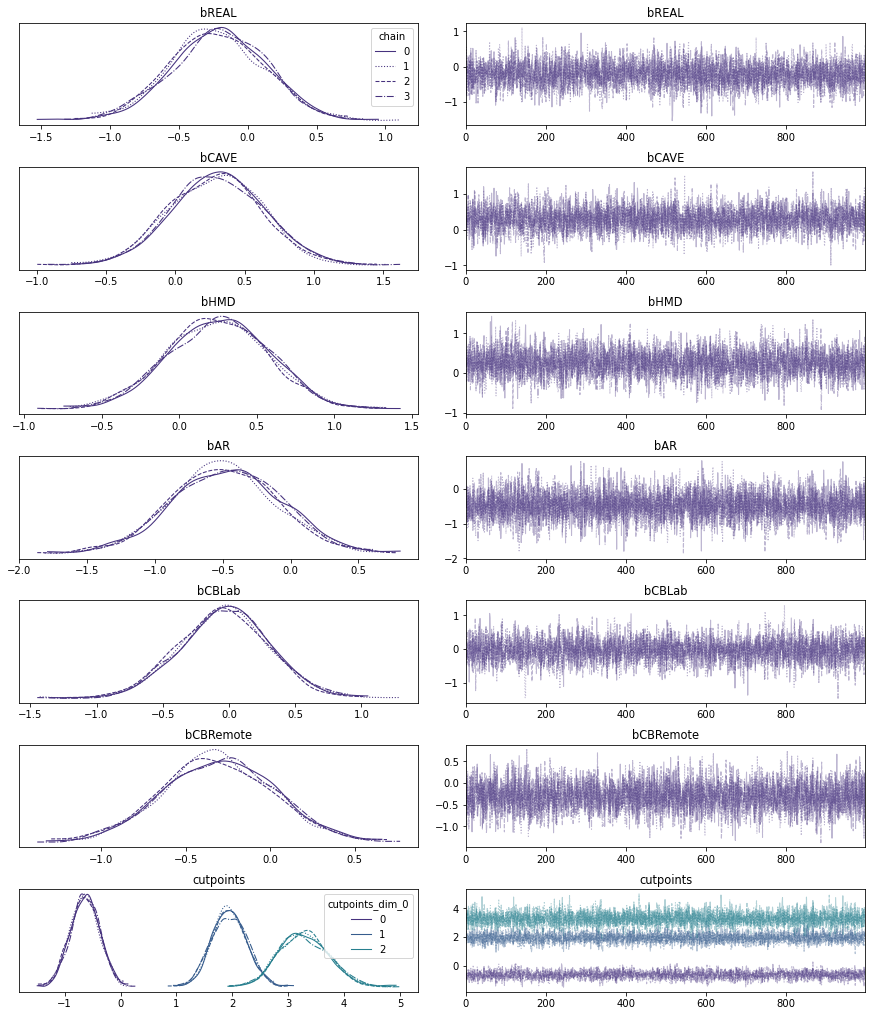

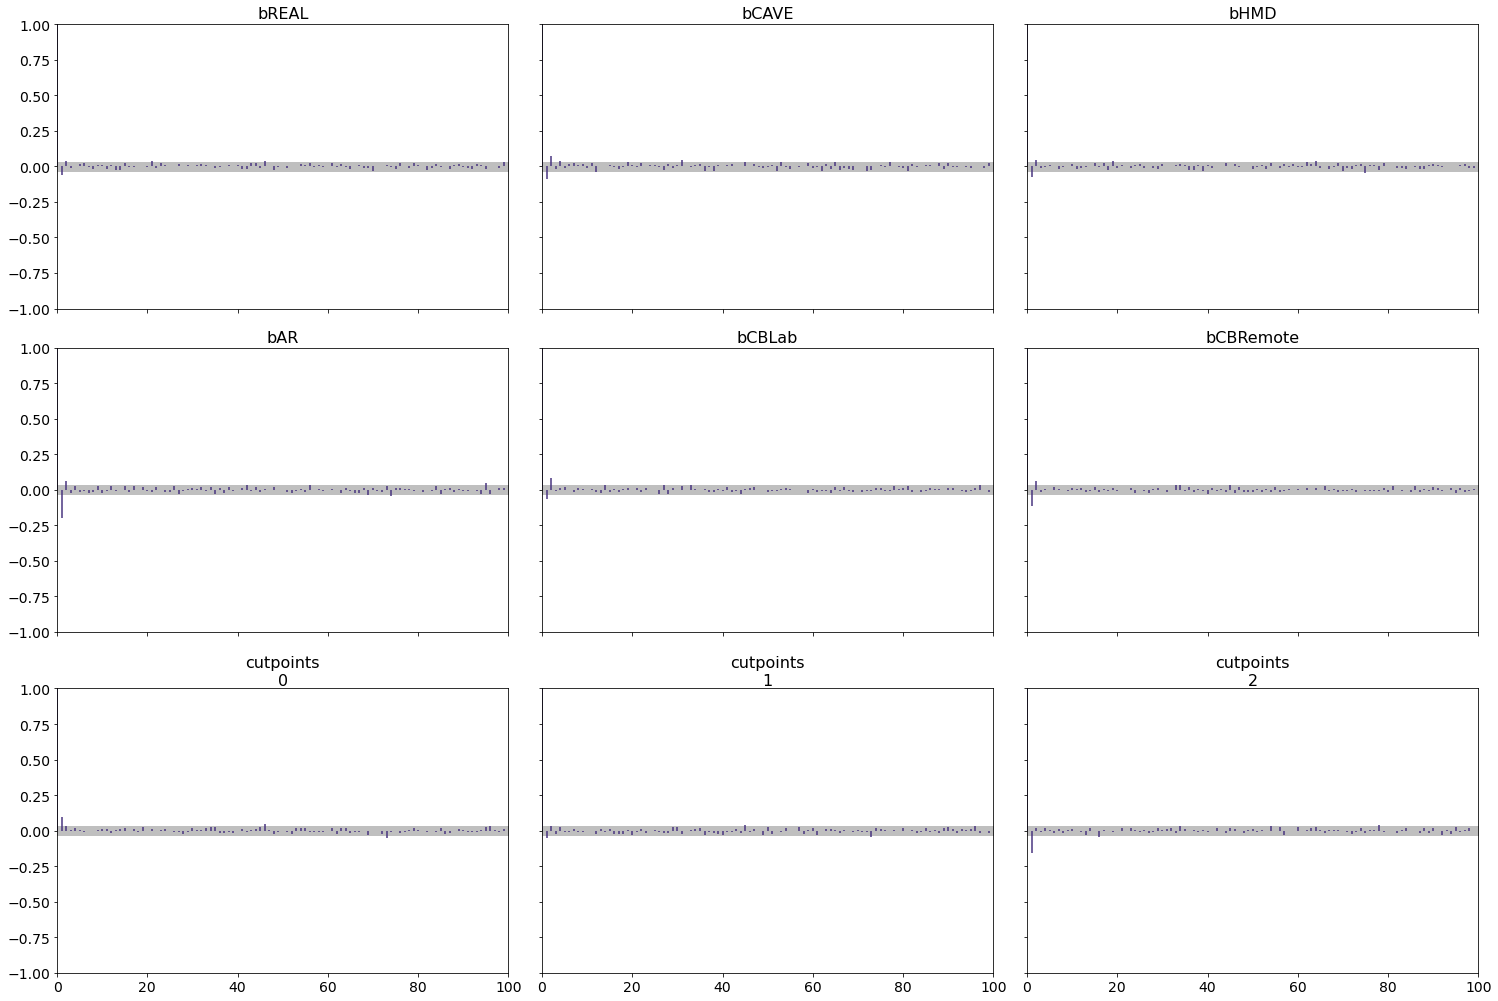

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


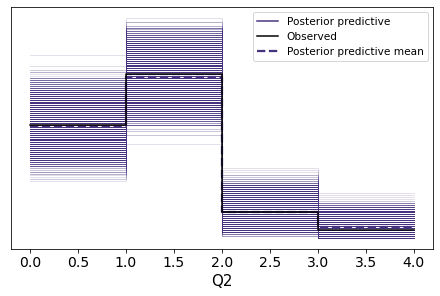

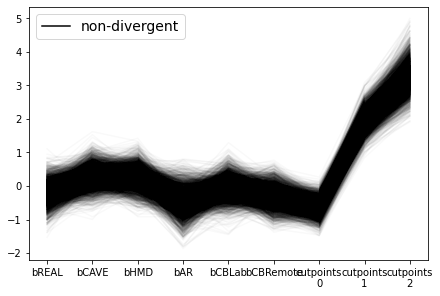

In [47]:
#Create posterior predictive
with Q2_model:
    ppc = pm.sample_posterior_predictive(trace_Q2, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q2,var_names=["~eta"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(trace_Q2,var_names=["~eta"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q2_model)); #inspect posterior predictive check
az.plot_parallel(trace_Q2,var_names=["~eta"], filter_vars="regex", legend = True); #inspect divergencies

In [48]:
#Warning: prints the HDIs of the last run model
printHDIs('Q2')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.219    1.303  inconclusive
1        HMD - REAL  -0.333    1.206  inconclusive
2         AR - REAL  -1.139    0.692  inconclusive
3      CBLab - REAL  -0.605    0.923  inconclusive
4   CBRemote - REAL  -0.852    0.678  inconclusive
5  CBRemote - CBLab  -1.032    0.523  inconclusive
6              ROPE  -0.073    0.073  inconclusive

### How dangerous would a collision have been?

In [49]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q3"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

2.0   -1.12
1.0   -0.89
3.0    1.40
4.0     inf
Name: Q3, dtype: float64

In [50]:
#delete empty rows where participants did not answer
nanIDX = np.argwhere(np.isnan(df_subjectives["Q3"].values))[0][0]
obs = np.delete(df_subjectives["Q3"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

Creating an ordered logistic regression based on https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24

In [51]:
with pm.Model() as Q3_model:
    #Defining cut points
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    
    #Creating normal priors for each condition
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    #Model equation   
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)
    Q3 = pm.OrderedLogistic("Q3", eta, cutpoints, observed=obs -1)
    
    #Fit model
    trace_Q3 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


#Posterior distributions for conditions
REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q3.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]

#Calculate differences of posterior distributions                           
Q3_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(trace_Q3, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.22  0.33   -0.40     0.84       0.01     0.00   3252.36   
bCAVE        -0.47  0.33   -1.06     0.16       0.01     0.00   2674.22   
bHMD         -0.19  0.32   -0.79     0.40       0.01     0.00   2824.10   
bAR           0.43  0.40   -0.41     1.12       0.01     0.01   3418.23   
bCBLab        0.26  0.33   -0.36     0.85       0.01     0.00   2731.69   
bCBRemote     0.03  0.33   -0.58     0.64       0.01     0.01   3301.59   
cutpoints[0] -3.03  0.40   -3.81    -2.32       0.01     0.01   1811.62   
cutpoints[1] -0.90  0.26   -1.36    -0.39       0.01     0.00   2068.33   
cutpoints[2]  1.44  0.27    0.97     1.98       0.01     0.00   2457.94   

              ess_tail  r_hat  
bREAL          3113.83    1.0  
bCAVE          2670.88    1.0  
bHMD           2752.75    1.0  
bAR            2512.16    1.0  
bCBLab         2426.97    1.0  
bCBRemote      2712.17    1.0  
cutpoints[0]   1741.95    1.0  
cutpoints[1]   2706.51    1.0  
cutpoints[2]   2487.59    1.0

Model diagnostics

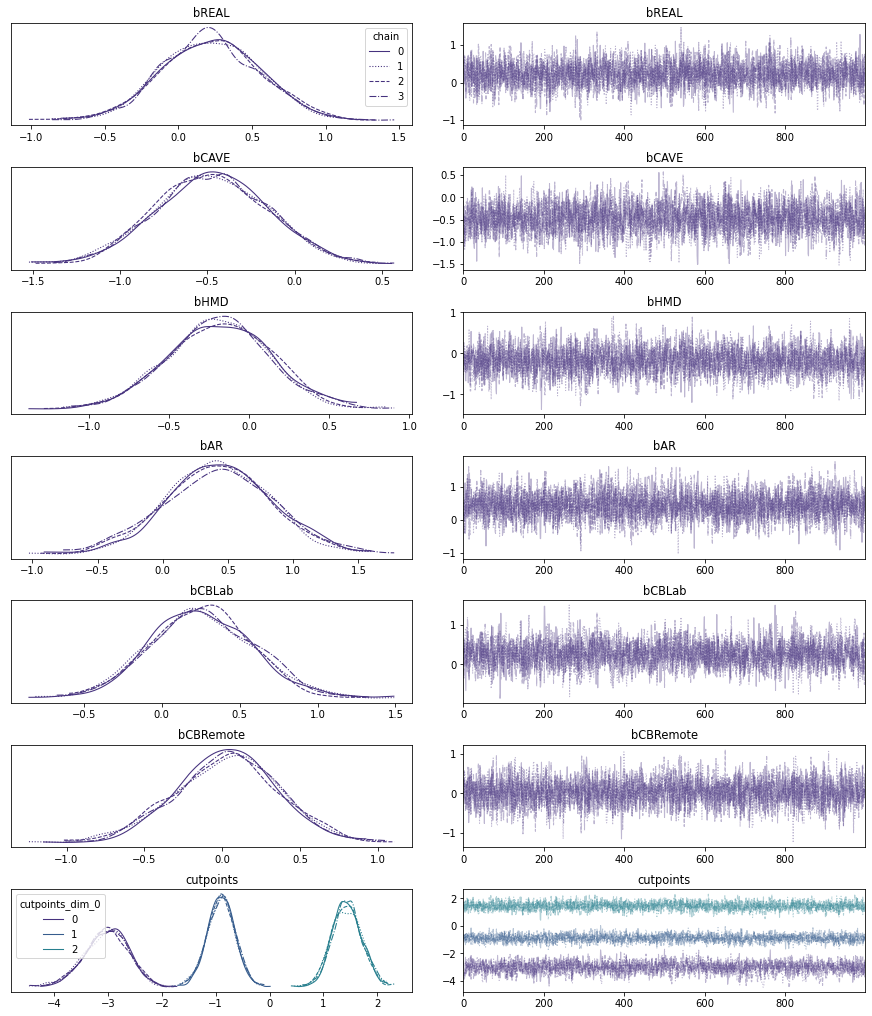

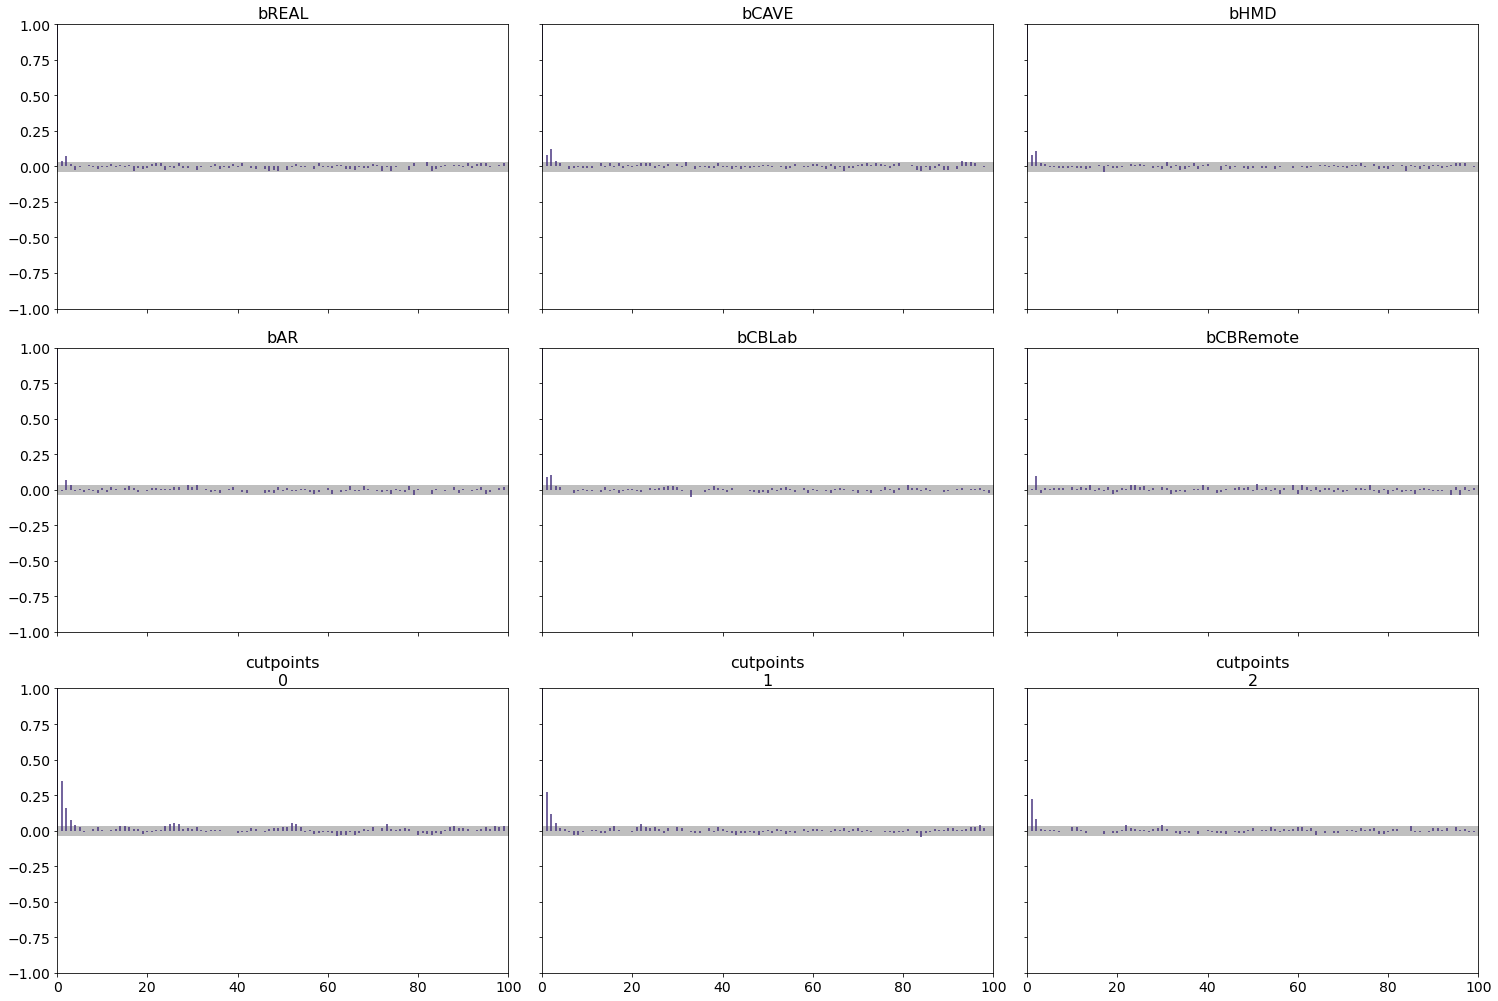

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


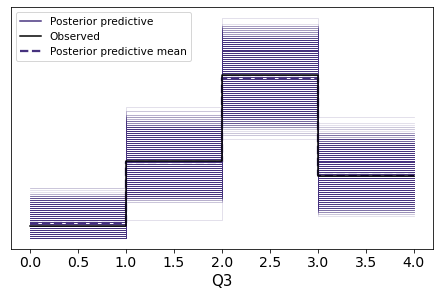

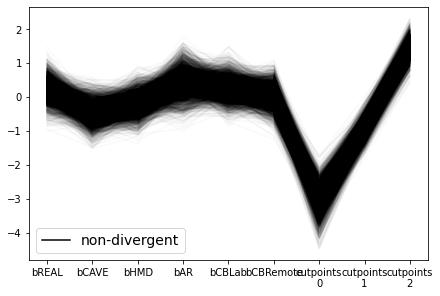

In [52]:
#Create posterior predictive
with Q3_model:
    ppc = pm.sample_posterior_predictive(trace_Q3, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(trace_Q3,var_names=["~eta"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(trace_Q3,var_names=["~eta"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q3_model)); #inspect posterior predictive check
az.plot_parallel(trace_Q3,var_names=["~eta"], filter_vars="regex", legend = True); #inspect divergencies

In [53]:
#Warning: prints the HDIs of the last run model
printHDIs('Q3')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -1.459    0.123  inconclusive
1        HMD - REAL  -1.119    0.386  inconclusive
2         AR - REAL  -0.709    1.159  inconclusive
3      CBLab - REAL  -0.690    0.806  inconclusive
4   CBRemote - REAL  -0.932    0.633  inconclusive
5  CBRemote - CBLab  -0.952    0.487  inconclusive
6              ROPE  -0.078    0.078  inconclusive

### How similar to real world traffic was your behavior in cases when you crossed the street?

Creating a linear model

In [54]:
#Define model
Q4_model = bmb.Model("Q4 ~ 0+ Condition",df_subjectives, dropna=True,categorical="Condition")

#Fit model
Q4_fitted = Q4_model.fit(random_seed=RANDOM_SEED)

#Extract estimators' posterior distributions for each condition
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q4_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]

#Calculate differences of posterior distributions 
Q4_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Model diagnostics

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


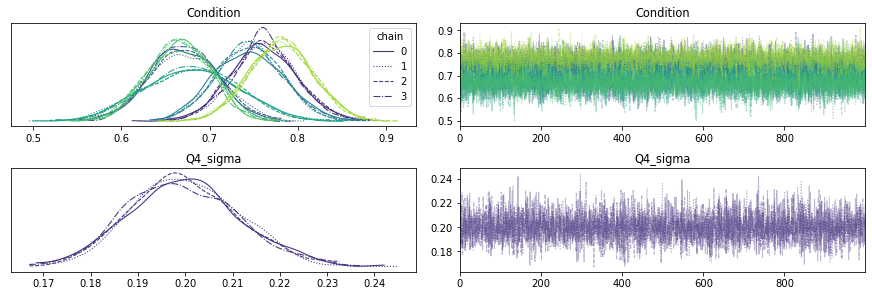

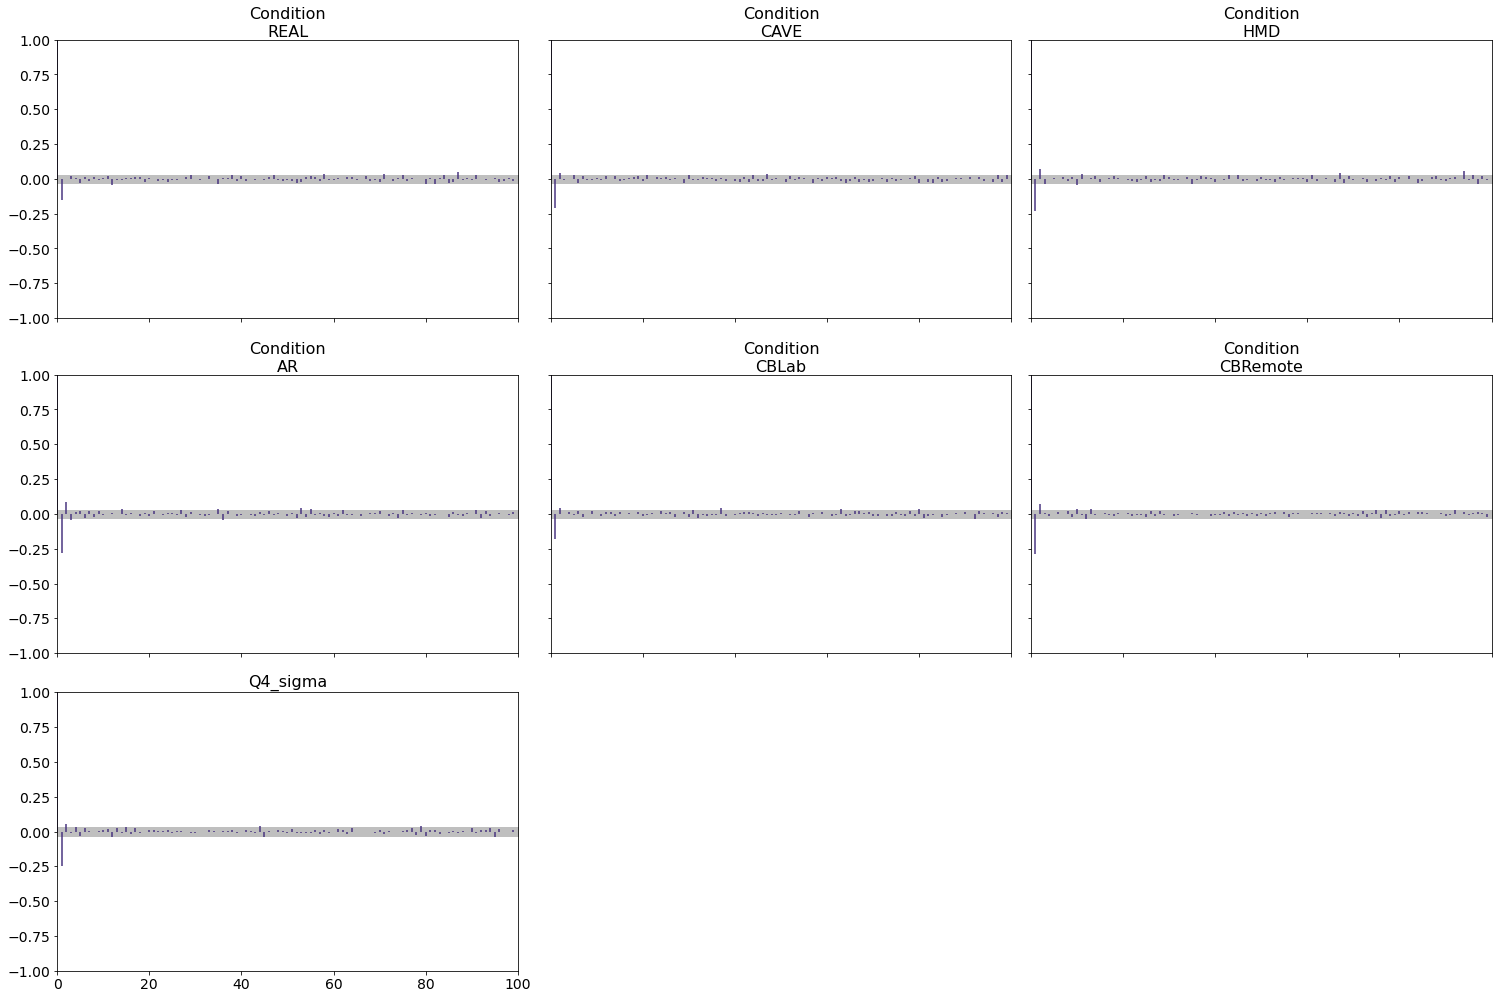

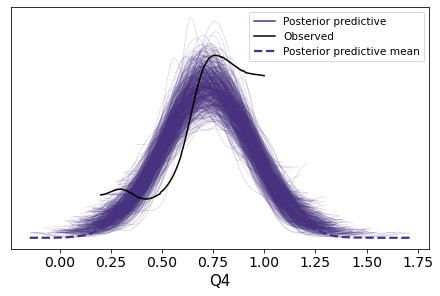

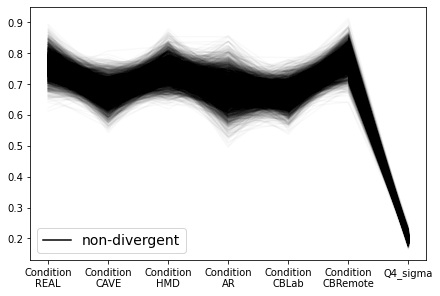

In [55]:
#Create posterior predictive
posterior_predictive = Q4_model.posterior_predictive(Q4_fitted,random_seed = RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(Q4_fitted,legend=True, compact=True); #inspect trace plots
az.plot_autocorr(Q4_fitted, combined = True); #inspect autocorrelation
az.plot_ppc(Q4_fitted); #inspect posterior predictive check
az.plot_parallel(Q4_fitted, legend = True); #inspect divergencies

**Models with Gamma and Wald Function** to account for bad model fit for heavily skewed date
c.f. https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html

In [130]:
#inverting data 
df_subjectives['Q4_i'] = abs(df_subjectives['Q4']-1) #inverse
df_subjectives['Q4_i']# += 1 #add one, otherwise model fails with infinte starting value

0      0.1
1      0.2
2      0.3
3      0.4
4      0.3
      ... 
158    0.1
159    0.7
160    0.1
161    0.7
162    0.2
Name: Q4_i, Length: 163, dtype: float64

Guassian Model

In [57]:
#Define model
Q4_model_gaussian = bmb.Model(formula="Q4_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     categorical="Condition")

#Fit model
Q4_fitted_gaussian = Q4_model_gaussian.fit(random_seed=RANDOM_SEED)

#Show summary
az.summary(Q4_fitted)

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_i_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  0.762  0.037   0.695    0.836      0.001      0.0    5507.0   
Condition[1]  0.671  0.038   0.604    0.748      0.001      0.0    5825.0   
Condition[2]  0.745  0.038   0.672    0.813      0.000      0.0    6464.0   
Condition[3]  0.680  0.053   0.576    0.773      0.001      0.0    7128.0   
Condition[4]  0.666  0.036   0.598    0.733      0.000      0.0    5350.0   
Condition[5]  0.781  0.036   0.712    0.848      0.000      0.0    6889.0   
Q4_sigma      0.200  0.012   0.179    0.222      0.000      0.0    6737.0   

              ess_tail  r_hat  
Condition[0]    3221.0    1.0  
Condition[1]    3457.0    1.0  
Condition[2]    3276.0    1.0  
Condition[3]    3195.0    1.0  
Condition[4]    3441.0    1.0  
Condition[5]    3097.0    1.0  
Q4_sigma        2403.0    1.0

Wald Model

In [131]:
#Define model
Q4_model_wald = bmb.Model(formula="Q4_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "wald", link = "log",
                     categorical="Condition")

#Fit model
Q4_fitted_wald = Q4_model_wald.fit(random_seed=RANDOM_SEED,tune=1500)

Automatically removing 7/163 rows from the dataset.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (endog * mu ** 2) * (endog - mu) ** 2


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Condition': array([-1.73264595, -1.73264595, -1.73264595, -1.73264595, -1.73264595,
       -1.73264595]), 'Q4_i_lam_log__': array(0.)}

Initial evaluation results:
Condition        -7.97
Q4_i_lam_log__   -1.14
Q4_i              -inf
Name: Log-probability of test_point, dtype: float64

Gamma Model

In [59]:
Q4_model_gamma = bmb.Model(formula="Q4_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "gamma", link = "log",
                     categorical="Condition")
Q4_fitted_gamma = Q4_model_gamma.fit(random_seed=RANDOM_SEED)

Automatically removing 7/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_i_alpha, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Model Comparison

In [60]:
#Creating dict with all models
models = {"wald": Q4_fitted_wald, "gamma": Q4_fitted_gamma, "gaussian": Q4_fitted_gaussian}

#Use arviz compare for model comparison
df_compare = az.compare(models)

#Output comparison
df_compare

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank        loo     p_loo     d_loo        weight        se  \
wald         0  35.257935  6.777548  0.000000  1.000000e+00  8.929406   
gamma        1  32.662214  7.025922  2.595721  6.955547e-14  8.955556   
gaussian     2  26.471130  7.068289  8.786805  0.000000e+00  9.063985   

               dse  warning loo_scale  
wald      0.000000    False       log  
gamma     0.425027    False       log  
gaussian  1.359785    False       log

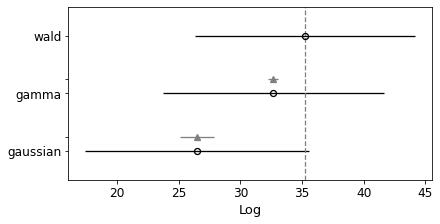

In [61]:
#Model comparison plot
az.plot_compare(df_compare, insample_dev=False);

Continue analysis with wald model

In [62]:
#Select model for further analysis
Q4_model = Q4_model_wald
Q4_fitted = Q4_fitted_wald

#Show model summary
az.summary(Q4_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]   0.215  0.027   0.163    0.268      0.000    0.000    6668.0   
Condition[1]   0.286  0.030   0.232    0.344      0.000    0.000    6451.0   
Condition[2]   0.228  0.028   0.174    0.281      0.000    0.000    6099.0   
Condition[3]   0.280  0.041   0.201    0.353      0.001    0.000    5074.0   
Condition[4]   0.290  0.028   0.238    0.344      0.000    0.000    6161.0   
Condition[5]   0.199  0.027   0.149    0.251      0.000    0.000    5585.0   
Q4_i_lam      56.362  6.312  44.212   68.068      0.086    0.061    5475.0   

              ess_tail  r_hat  
Condition[0]    3289.0    1.0  
Condition[1]    3185.0    1.0  
Condition[2]    3179.0    1.0  
Condition[3]    3427.0    1.0  
Condition[4]    3456.0    1.0  
Condition[5]    3155.0    1.0  
Q4_i_lam        3194.0    1.0

Model diagnostics

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


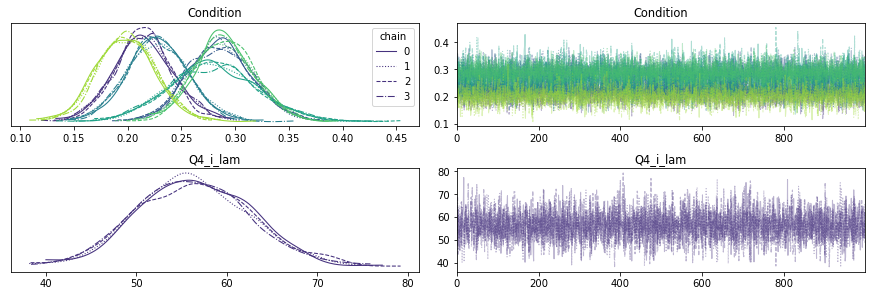

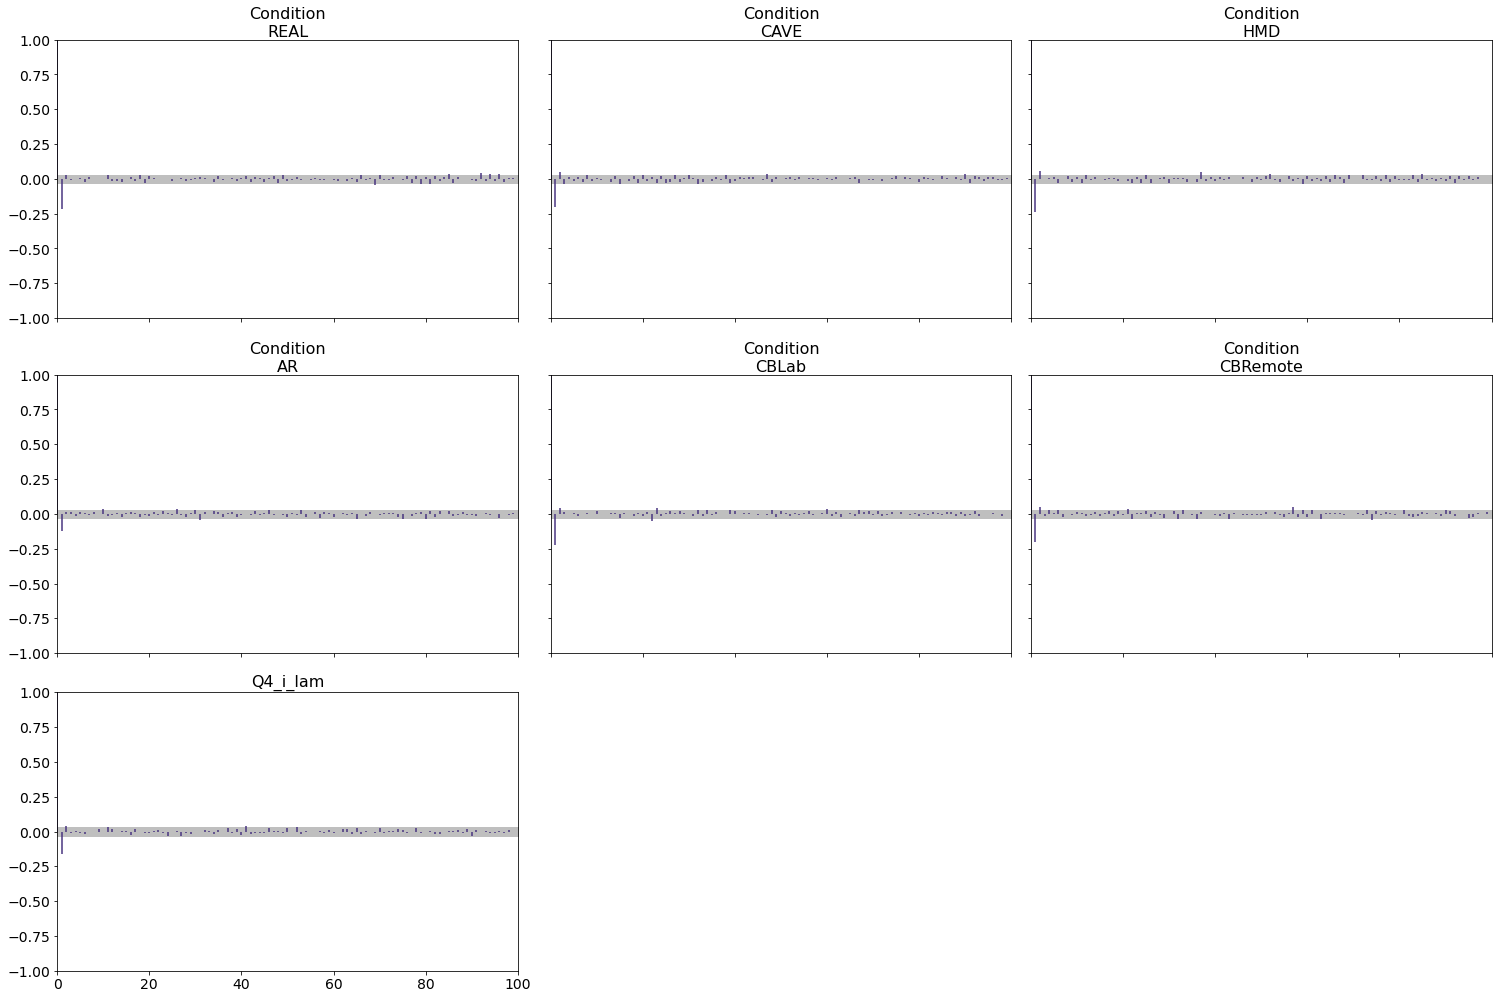

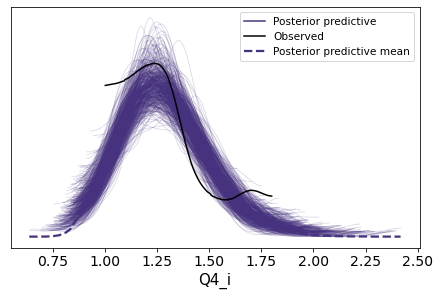

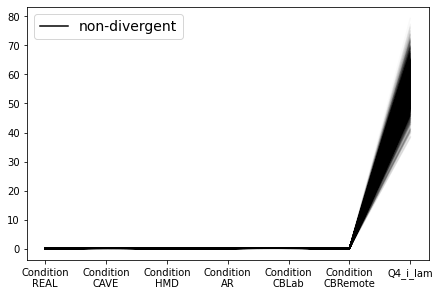

In [63]:
#Create posterior predictive
posterior_predictive = Q4_model.posterior_predictive(Q4_fitted,random_seed = RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(Q4_fitted,legend=True, compact=True); #inspect trace plots
az.plot_autocorr(Q4_fitted, combined = True); #inspect autocorrelation
az.plot_ppc(Q4_fitted); #inspect posterior predictive check
az.plot_parallel(Q4_fitted, legend = True); #inspect divergencies

In [64]:
#Extract estimators' posterior distributions for each condition
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q4_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]

#Calculate differences of posterior distributions
Q4_diffs = [(CAVE - REAL)*-1,(HMD - REAL)*-1,(AR - REAL)*-1,(CBLab - REAL)*-1,(CBRemote - REAL)*-1,(CBRemote - CBLab)*-1]

Output HDIs

In [65]:
#Create HDI dataframe
HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                           np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                           np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                           np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                           np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                           np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                                 ['ROPE',df_subjectives['Q4'].std()*-0.1,df_subjectives['Q4'].std()*0.1]]),
                 columns=['Comparison', 'lowHDI', 'highHDI'])

#Set column data types
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})

#Create empty restults column
HDIs["Result"] = ""

#Calculate result based on rope and HDIs
for index, row in HDIs.iterrows():
    result = 'inconclusive' #set default result inconclusive
    if (row.lowHDI>df_subjectives['Q4'].std()*-0.1 and row.highHDI < df_subjectives['Q4'].std()*0.1):
        result = 'equal' #set practically equal if hdi is completly inside ROPE
    if (row.lowHDI>df_subjectives['Q4'].std()*0.1):
        result = 'smaller' #smaller if HDI is completly outside and smaller than ROPE
    if (row.highHDI<df_subjectives['Q4'].std()*-0.1):
        result = 'larger' #larger if HDI is completly outside and larger than ROPE
    HDIs.iat[index, 3] = result
    
#Show HDIs
display(HDIs.round(3))

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.006    0.146  inconclusive
1        HMD - REAL  -0.059    0.088  inconclusive
2         AR - REAL  -0.026    0.154  inconclusive
3      CBLab - REAL   0.005    0.153  inconclusive
4   CBRemote - REAL  -0.091    0.053  inconclusive
5  CBRemote - CBLab  -0.164   -0.019  inconclusive
6              ROPE  -0.020    0.020  inconclusive

### How similar to real world traffic was your behavior in cases  you did not cross the street?
Creating a linear model

In [66]:
#Define model
Q5_model = bmb.Model("Q5 ~ 0+ Condition",df_subjectives, dropna=True,categorical="Condition")

#Fit model
Q5_fitted = Q5_model.fit(random_seed=RANDOM_SEED)
#REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q5_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
#Q5_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(Q5_fitted)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  0.767  0.039   0.689    0.836      0.001    0.000    6040.0   
Condition[1]  0.803  0.043   0.722    0.882      0.001    0.000    5923.0   
Condition[2]  0.800  0.043   0.719    0.878      0.001    0.000    5828.0   
Condition[3]  0.673  0.065   0.549    0.794      0.001    0.001    6001.0   
Condition[4]  0.715  0.040   0.638    0.783      0.000    0.000    6787.0   
Condition[5]  0.863  0.040   0.786    0.936      0.000    0.000    6822.0   
Q5_sigma      0.222  0.013   0.198    0.245      0.000    0.000    5792.0   

              ess_tail  r_hat  
Condition[0]    3269.0    1.0  
Condition[1]    3286.0    1.0  
Condition[2]    3155.0    1.0  
Condition[3]    3331.0    1.0  
Condition[4]    3384.0    1.0  
Condition[5]    3411.0    1.0  
Q5_sigma        3362.0    1.0

Model diagnostics

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


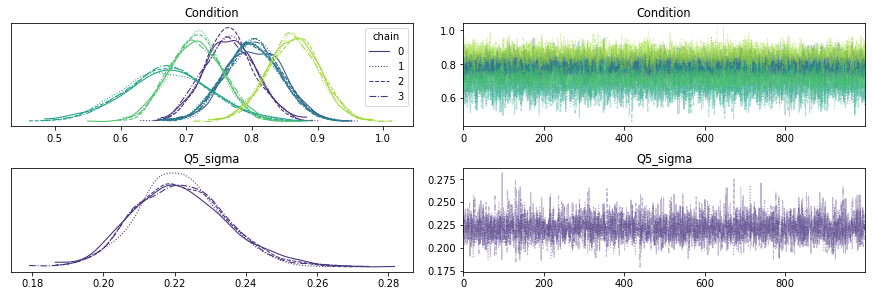

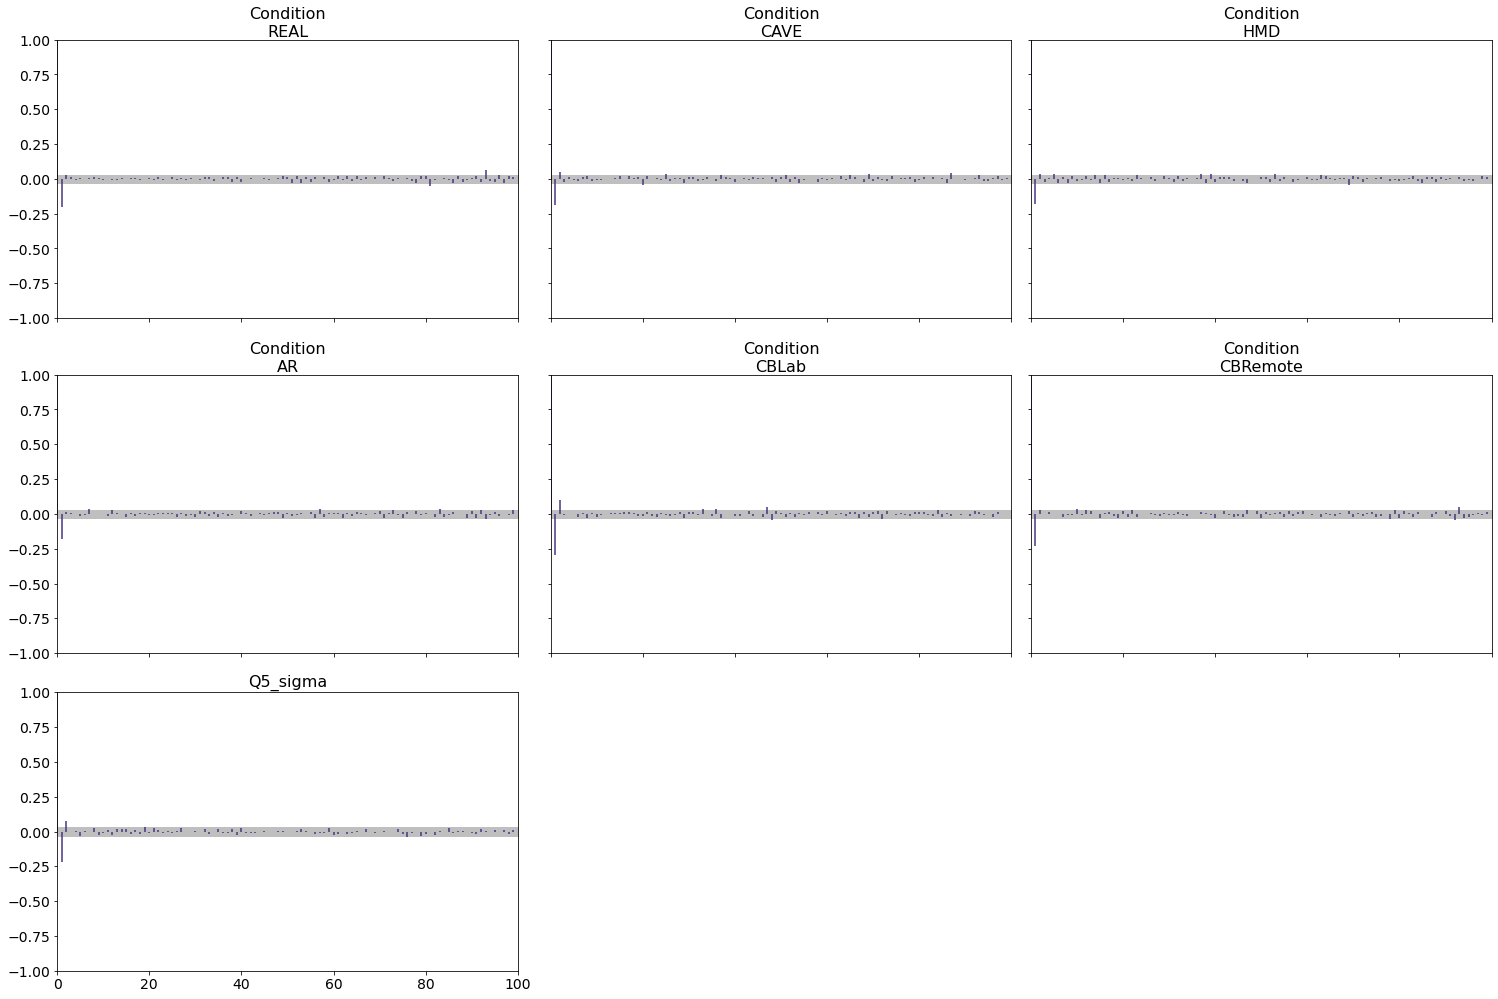

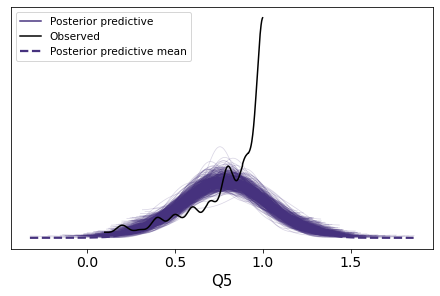

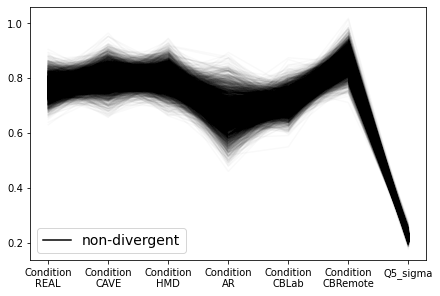

In [67]:
#Create posterior predictive
posterior_predictive = Q5_model.posterior_predictive(Q5_fitted,random_seed = RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(Q5_fitted,legend=True, compact=True); #inspect trace plots
az.plot_autocorr(Q5_fitted, combined = True); #inspect autocorrelation
az.plot_ppc(Q5_fitted); #inspect posterior predictive check
az.plot_parallel(Q5_fitted, legend = True); #inspect divergencies

**Model fitting with Wald and Gamma distributions to account for skewed data**

https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html

In [68]:
#inverting data 
df_subjectives['Q5_i'] = abs(df_subjectives['Q5']-1) #inverse
df_subjectives['Q5_i'] += 1 #add one, otherwise model fails with infinte starting value

Guassian Model

In [69]:
#Define model
Q5_model_gaussian = bmb.Model(formula="Q5_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     categorical="Condition")
#Fit model
Q5_fitted_gaussian = Q5_model_gaussian.fit(random_seed=RANDOM_SEED)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_i_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Wald Model

In [70]:
#Define model
Q5_model_wald = bmb.Model(formula="Q5_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "wald", link = "log",
                     categorical="Condition")
#Fit model
Q5_fitted_wald = Q5_model_wald.fit(random_seed=RANDOM_SEED)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_i_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


Gamma Model

In [71]:
#Define model
Q5_model_gamma = bmb.Model(formula="Q5_i ~ 0+ Condition",
                     data=df_subjectives, dropna=True,
                     family = "gamma", link = "log",
                     categorical="Condition")
#Fit model
Q5_fitted_gamma = Q5_model_gamma.fit(random_seed=RANDOM_SEED)

Automatically removing 9/163 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_i_alpha, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Model Comparison

In [72]:
#Creating dict with all models
models = {"wald": Q5_fitted_wald, "gamma": Q5_fitted_gamma, "gaussian": Q5_fitted_gaussian}

#Use arviz compare for model comparison
df_compare = az.compare(models)

#Output comparison
df_compare

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank        loo     p_loo      d_loo        weight        se  \
wald         0  23.057841  6.849919   0.000000  1.000000e+00  9.664909   
gamma        1  19.217216  6.916876   3.840625  0.000000e+00  9.687624   
gaussian     2   9.861390  6.954060  13.196451  8.231194e-13  9.845629   

              dse  warning loo_scale  
wald      0.00000    False       log  
gamma     0.63804    False       log  
gaussian  1.98655    False       log

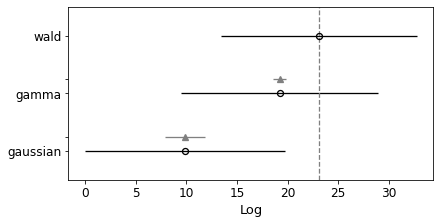

In [73]:
#Model comparison plot
az.plot_compare(df_compare, insample_dev=False);

Continue analysis with wald model

In [74]:
#Select model for further analysis
Q5_model = Q5_model_wald
Q5_fitted = Q5_fitted_wald

#Show summary
az.summary(Q5_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]   0.211  0.031   0.153    0.267      0.000    0.000    6446.0   
Condition[1]   0.180  0.034   0.121    0.247      0.000    0.000    5107.0   
Condition[2]   0.184  0.033   0.125    0.247      0.000    0.000    5717.0   
Condition[3]   0.286  0.053   0.186    0.384      0.001    0.001    5570.0   
Condition[4]   0.251  0.031   0.194    0.314      0.000    0.000    6254.0   
Condition[5]   0.129  0.031   0.071    0.187      0.000    0.000    7304.0   
Q5_i_lam      41.508  4.788  32.737   50.825      0.064    0.046    5539.0   

              ess_tail  r_hat  
Condition[0]    3316.0    1.0  
Condition[1]    3401.0    1.0  
Condition[2]    3063.0    1.0  
Condition[3]    2930.0    1.0  
Condition[4]    3512.0    1.0  
Condition[5]    3405.0    1.0  
Q5_i_lam        3239.0    1.0

Model diagnostics

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


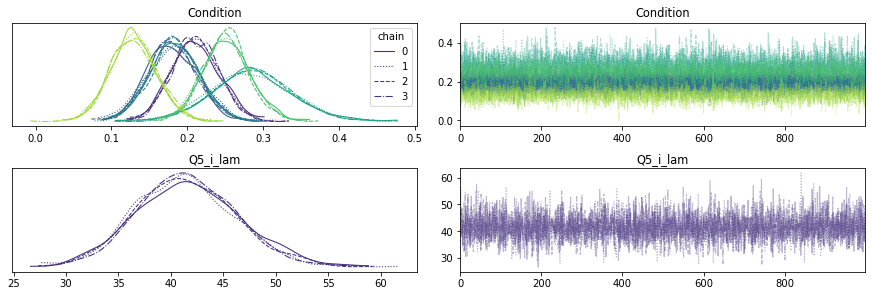

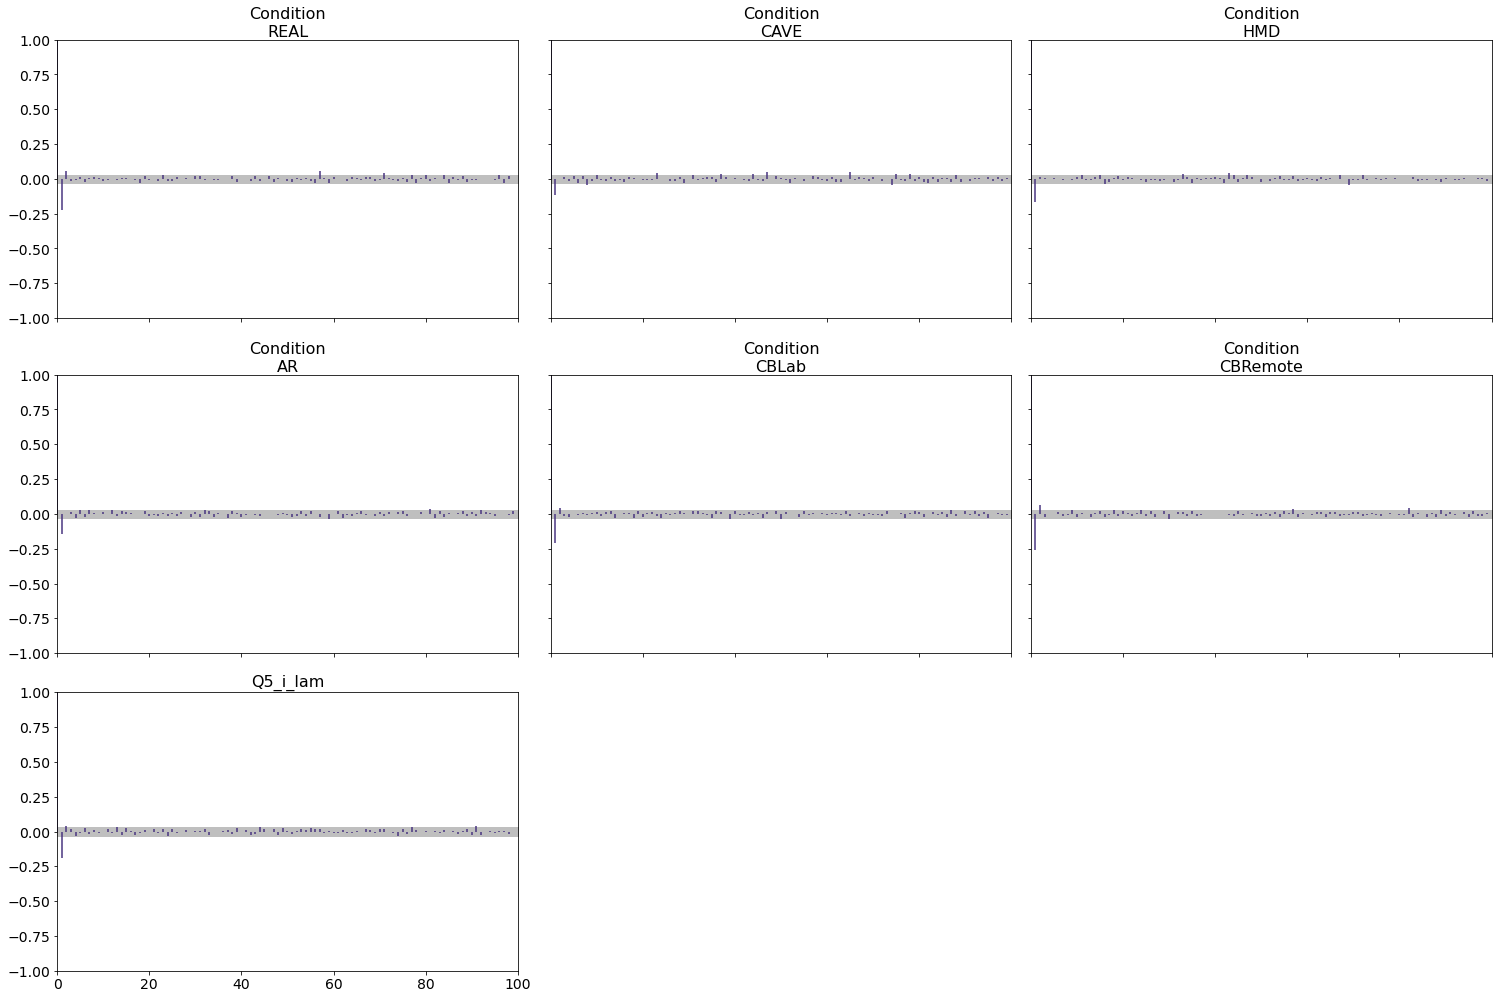

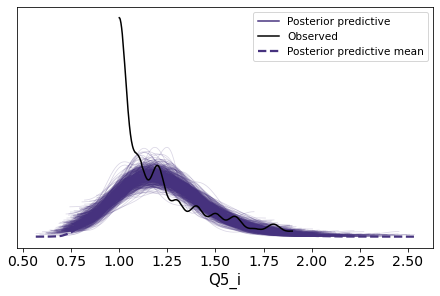

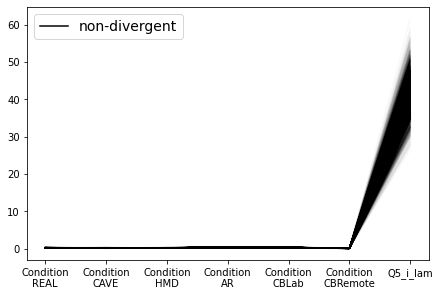

In [75]:
#Create posterior predictive
posterior_predictive = Q5_model.posterior_predictive(Q5_fitted,random_seed = RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(Q5_fitted,legend=True, compact=True); #inspect trace plots
az.plot_autocorr(Q5_fitted, combined = True); #inspect autocorrelation
az.plot_ppc(Q5_fitted); #inspect posterior predictive check
az.plot_parallel(Q5_fitted, legend = True); #inspect divergencies

In [76]:
#Extract estimators' posterior distributions for each condition
REAL, CAVE, HMD, AR, CBLab, CBRemote = [Q5_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]

#Calculate differences of posterior distributions
Q5_diffs = [(CAVE - REAL)*-1,(HMD - REAL)*-1,(AR - REAL)*-1,(CBLab - REAL)*-1,(CBRemote - REAL)*-1,(CBRemote - CBLab)*-1]

Output HDIs

In [77]:
#Create HDI dataframe
HDIs = pd.DataFrame(np.array([np.concatenate((['CAVE - REAL'],az.hdi(az.convert_to_dataset(CAVE - REAL)).x.data)),
                           np.concatenate((['HMD - REAL'],az.hdi(az.convert_to_dataset(HMD - REAL)).x.data)),
                           np.concatenate((['AR - REAL'],az.hdi(az.convert_to_dataset(AR - REAL)).x.data)),
                           np.concatenate((['CBLab - REAL'],az.hdi(az.convert_to_dataset(CBLab - REAL)).x.data)),
                           np.concatenate((['CBRemote - REAL'],az.hdi(az.convert_to_dataset(CBRemote - REAL)).x.data)),
                           np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                                 ['ROPE',df_subjectives['Q5'].std()*-0.1,df_subjectives['Q5'].std()*0.1]]),
                 columns=['Comparison', 'lowHDI', 'highHDI'])

#Set column data types
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})

#Create empty restults column
HDIs["Result"] = ""

#Calculate result based on rope and HDIs
for index, row in HDIs.iterrows():
    result = 'inconclusive' #set default result inconclusive
    if (row.lowHDI>df_subjectives['Q5'].std()*-0.1 and row.highHDI < df_subjectives['Q5'].std()*0.1):
        result = 'equal' #set practically equal if hdi is completly inside ROPE
    if (row.lowHDI>df_subjectives['Q5'].std()*0.1):
        result = 'smaller' #smaller if HDI is completly outside and smaller than ROPE
    if (row.highHDI<df_subjectives['Q5'].std()*-0.1):
        result = 'larger' #larger if HDI is completly outside and larger than ROPE
    HDIs.iat[index, 3] = result
    
#Show HDIs
display(HDIs.round(3))

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.115    0.052  inconclusive
1        HMD - REAL  -0.108    0.060  inconclusive
2         AR - REAL  -0.043    0.187  inconclusive
3      CBLab - REAL  -0.043    0.124  inconclusive
4   CBRemote - REAL  -0.161    0.004  inconclusive
5  CBRemote - CBLab  -0.209   -0.041        larger
6              ROPE  -0.023    0.023  inconclusive

### Compared to usual, my choices were safe / unsafe

In [78]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q6"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0    0.05
 2.0    0.12
-2.0    0.17
 1.0    1.48
-1.0     inf
Name: Q6, dtype: float64

In [79]:
#delete empty rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q6"].values))[0][0]
obs = np.delete(df_subjectives["Q6"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

Creating an ordered logistic regression based on https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24

In [80]:
with pm.Model() as Q6_model:
    #Defining cut points
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    
    #Creating normal priors for each condition
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    #Model equation 
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)
    Q6 = pm.OrderedLogistic("Q6", eta, cutpoints, observed = obs + 2)
    
    #Fit model
    trace_Q6 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED, target_accept=0.9)

#Posterior distributions for conditions
REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q6.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]

#Calculate differences of posterior distributions 
Q6_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(trace_Q6, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.40  0.33   -1.02     0.21       0.01     0.00   3914.71   
bCAVE        -0.07  0.33   -0.68     0.56       0.01     0.01   3632.96   
bHMD          0.50  0.33   -0.15     1.13       0.01     0.00   4082.37   
bAR           0.10  0.38   -0.62     0.77       0.01     0.01   4402.50   
bCBLab        0.07  0.33   -0.55     0.66       0.01     0.00   3536.65   
bCBRemote    -0.12  0.32   -0.78     0.44       0.01     0.00   3299.01   
cutpoints[0] -3.94  0.54   -4.96    -2.95       0.01     0.01   2704.54   
cutpoints[1] -1.40  0.28   -1.94    -0.88       0.01     0.00   2588.89   
cutpoints[2]  0.89  0.26    0.42     1.39       0.00     0.00   2860.39   
cutpoints[3]  3.71  0.50    2.82     4.68       0.01     0.01   3897.93   

              ess_tail  r_hat  
bREAL          2963.28    1.0  
bCAVE          2537.88    1.0  
bHMD           2887.94    1.0  
bAR            3117.75    1.0  
bCBLab         3192.80    1.0  
bCBRemote      3018.06    1.0  
cutpoints[0]   2609.64    1.0  
cutpoints[1]   2935.55    1.0  
cutpoints[2]   3277.89    1.0  
cutpoints[3]   2853.69    1.0

Model diagnostics

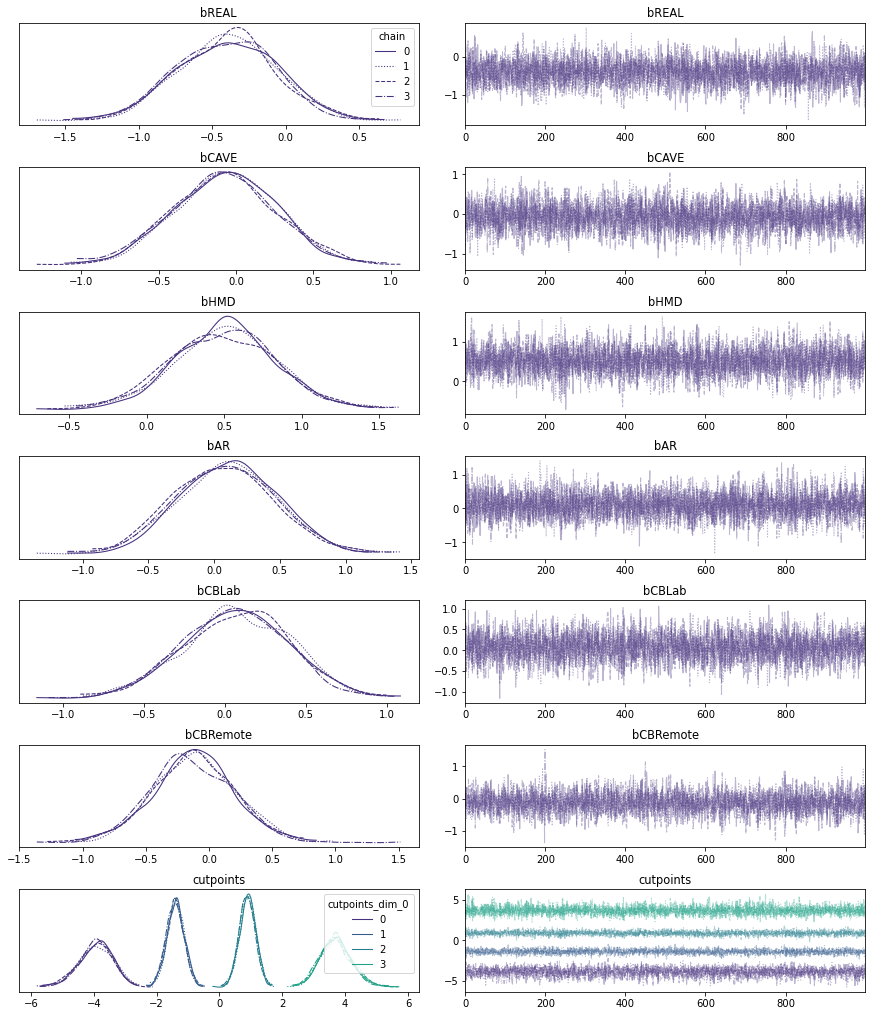

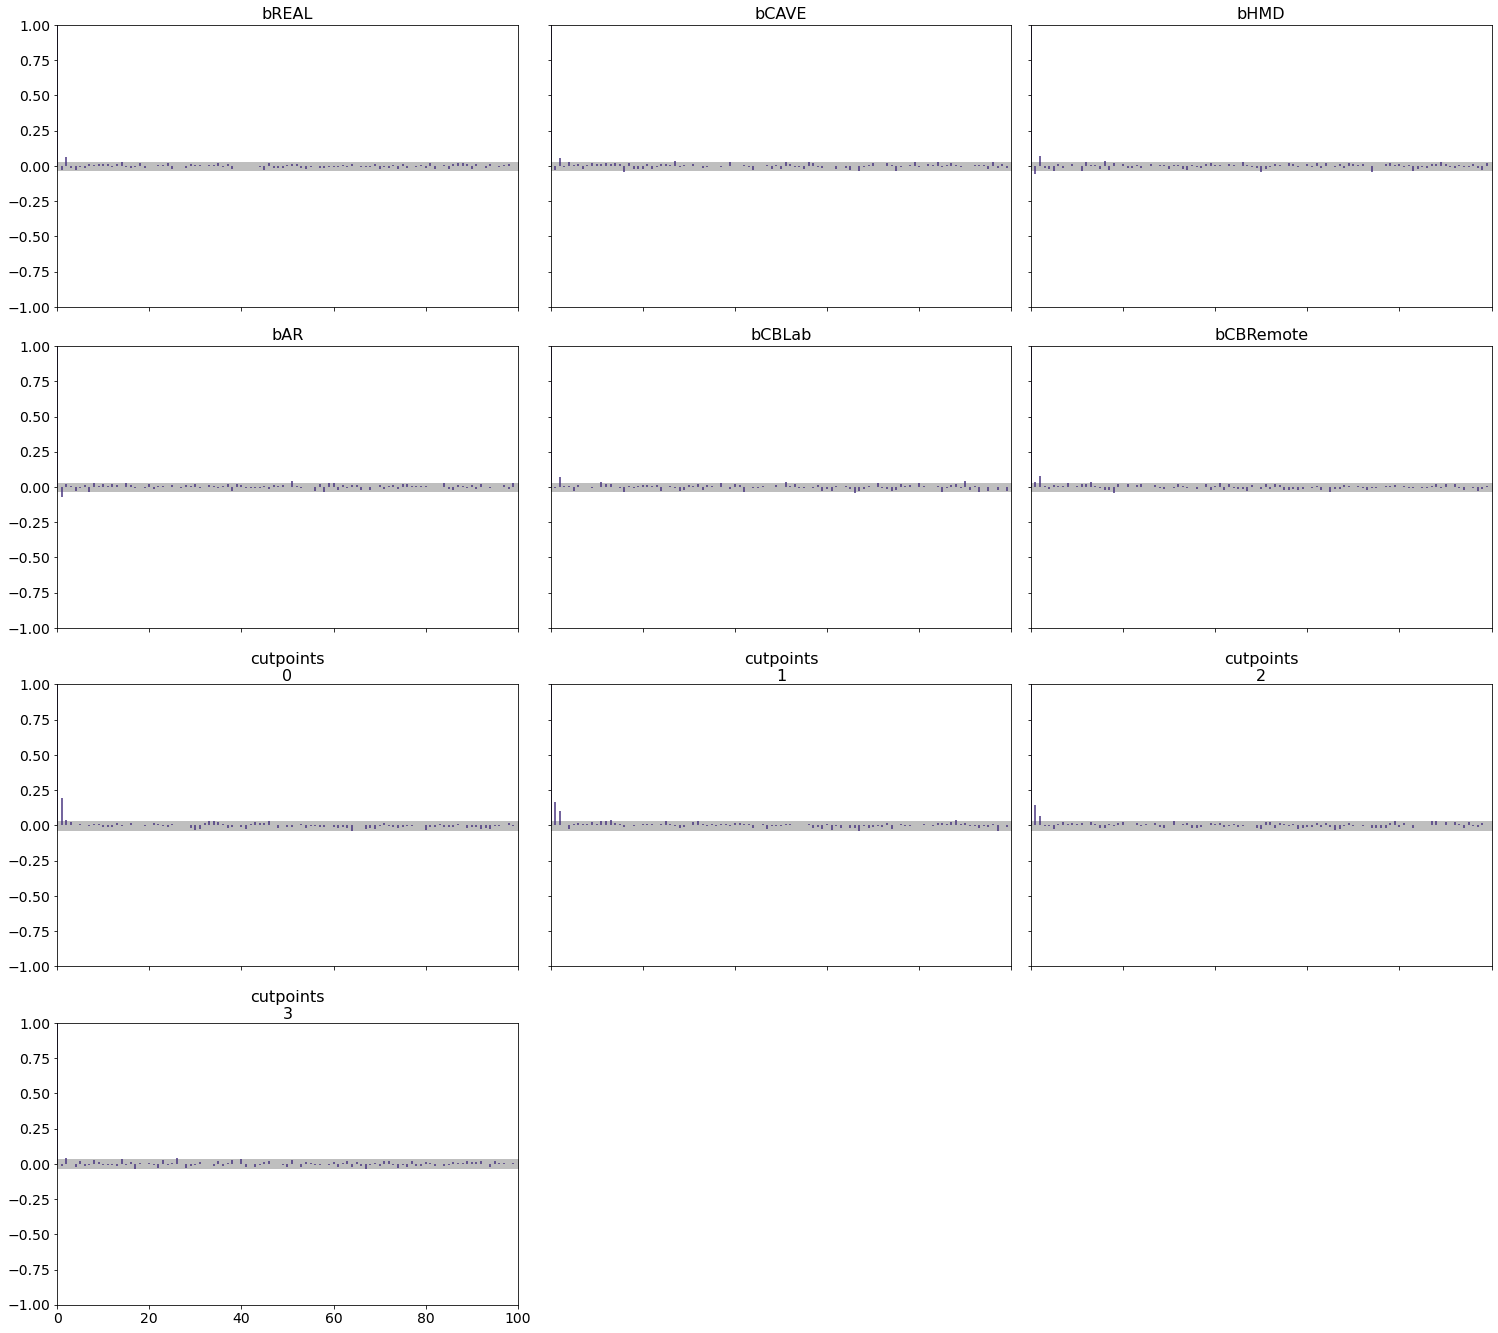

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


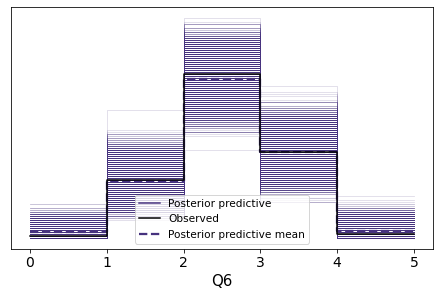

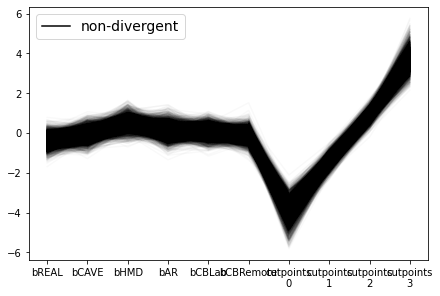

In [81]:
#Create posterior predictive
with Q6_model:
    ppc = pm.sample_posterior_predictive(trace_Q6, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(trace_Q6,var_names=["~eta"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(trace_Q6,var_names=["~eta"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q6_model)); #inspect posterior predictive check
az.plot_parallel(trace_Q6,var_names=["~eta"], filter_vars="regex", legend = True); #inspect divergencies

In [82]:
#Warning: prints the HDIs of the last run model
printHDIs('Q6')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.391    1.136  inconclusive
1        HMD - REAL   0.066    1.631  inconclusive
2         AR - REAL  -0.315    1.398  inconclusive
3      CBLab - REAL  -0.266    1.237  inconclusive
4   CBRemote - REAL  -0.450    1.014  inconclusive
5  CBRemote - CBLab  -0.962    0.538  inconclusive
6              ROPE  -0.076    0.076  inconclusive

### Compared to usual, deciding to cross the street was easy / difficult

In [83]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q7"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0   -1.02
 2.0   -0.45
-2.0   -0.37
 1.0    2.14
-1.0     inf
Name: Q7, dtype: float64

In [84]:
#delete empty rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q7"].values))[0][0]
obs = np.delete(df_subjectives["Q7"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

Creating an ordered logistic regression based on https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24

In [85]:
with pm.Model() as Q7_model:
    #Defining cut points
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    
    #Creating normal priors for each condition
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    #Model equation
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)
    Q7 = pm.OrderedLogistic("Q7", eta, cutpoints, observed = obs + 2)
    
    #Fit model
    trace_Q7 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED, target_accept=0.9)

#Posterior distributions for conditions
REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q7.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]

#Calculate differences of posterior distributions
Q7_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(trace_Q7, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.28  0.32   -0.88     0.33       0.01     0.00   4045.45   
bCAVE        -0.47  0.32   -1.03     0.15       0.01     0.00   3982.51   
bHMD          0.08  0.33   -0.54     0.70       0.01     0.00   3645.00   
bAR           0.38  0.38   -0.34     1.10       0.01     0.00   5079.79   
bCBLab        0.42  0.32   -0.19     1.00       0.00     0.00   4242.94   
bCBRemote     0.31  0.33   -0.31     0.93       0.00     0.00   4679.82   
cutpoints[0] -3.69  0.50   -4.63    -2.77       0.01     0.01   2443.64   
cutpoints[1] -1.89  0.29   -2.42    -1.34       0.01     0.00   3161.40   
cutpoints[2] -0.39  0.25   -0.88     0.05       0.00     0.00   2908.67   
cutpoints[3]  2.06  0.30    1.48     2.62       0.00     0.00   4068.95   

              ess_tail  r_hat  
bREAL          3131.73    1.0  
bCAVE          3048.85    1.0  
bHMD           2867.64    1.0  
bAR            2664.28    1.0  
bCBLab         3264.97    1.0  
bCBRemote      3331.75    1.0  
cutpoints[0]   1966.06    1.0  
cutpoints[1]   3111.16    1.0  
cutpoints[2]   2918.47    1.0  
cutpoints[3]   2957.57    1.0

Model diagnostics

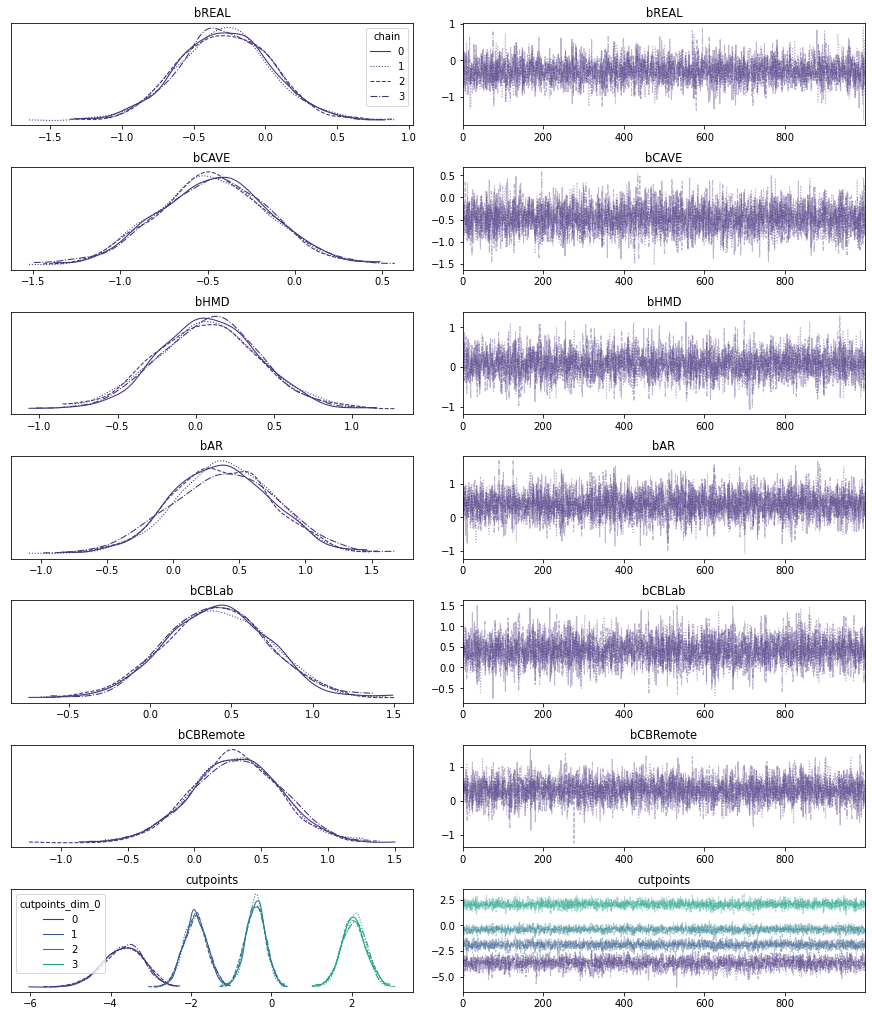

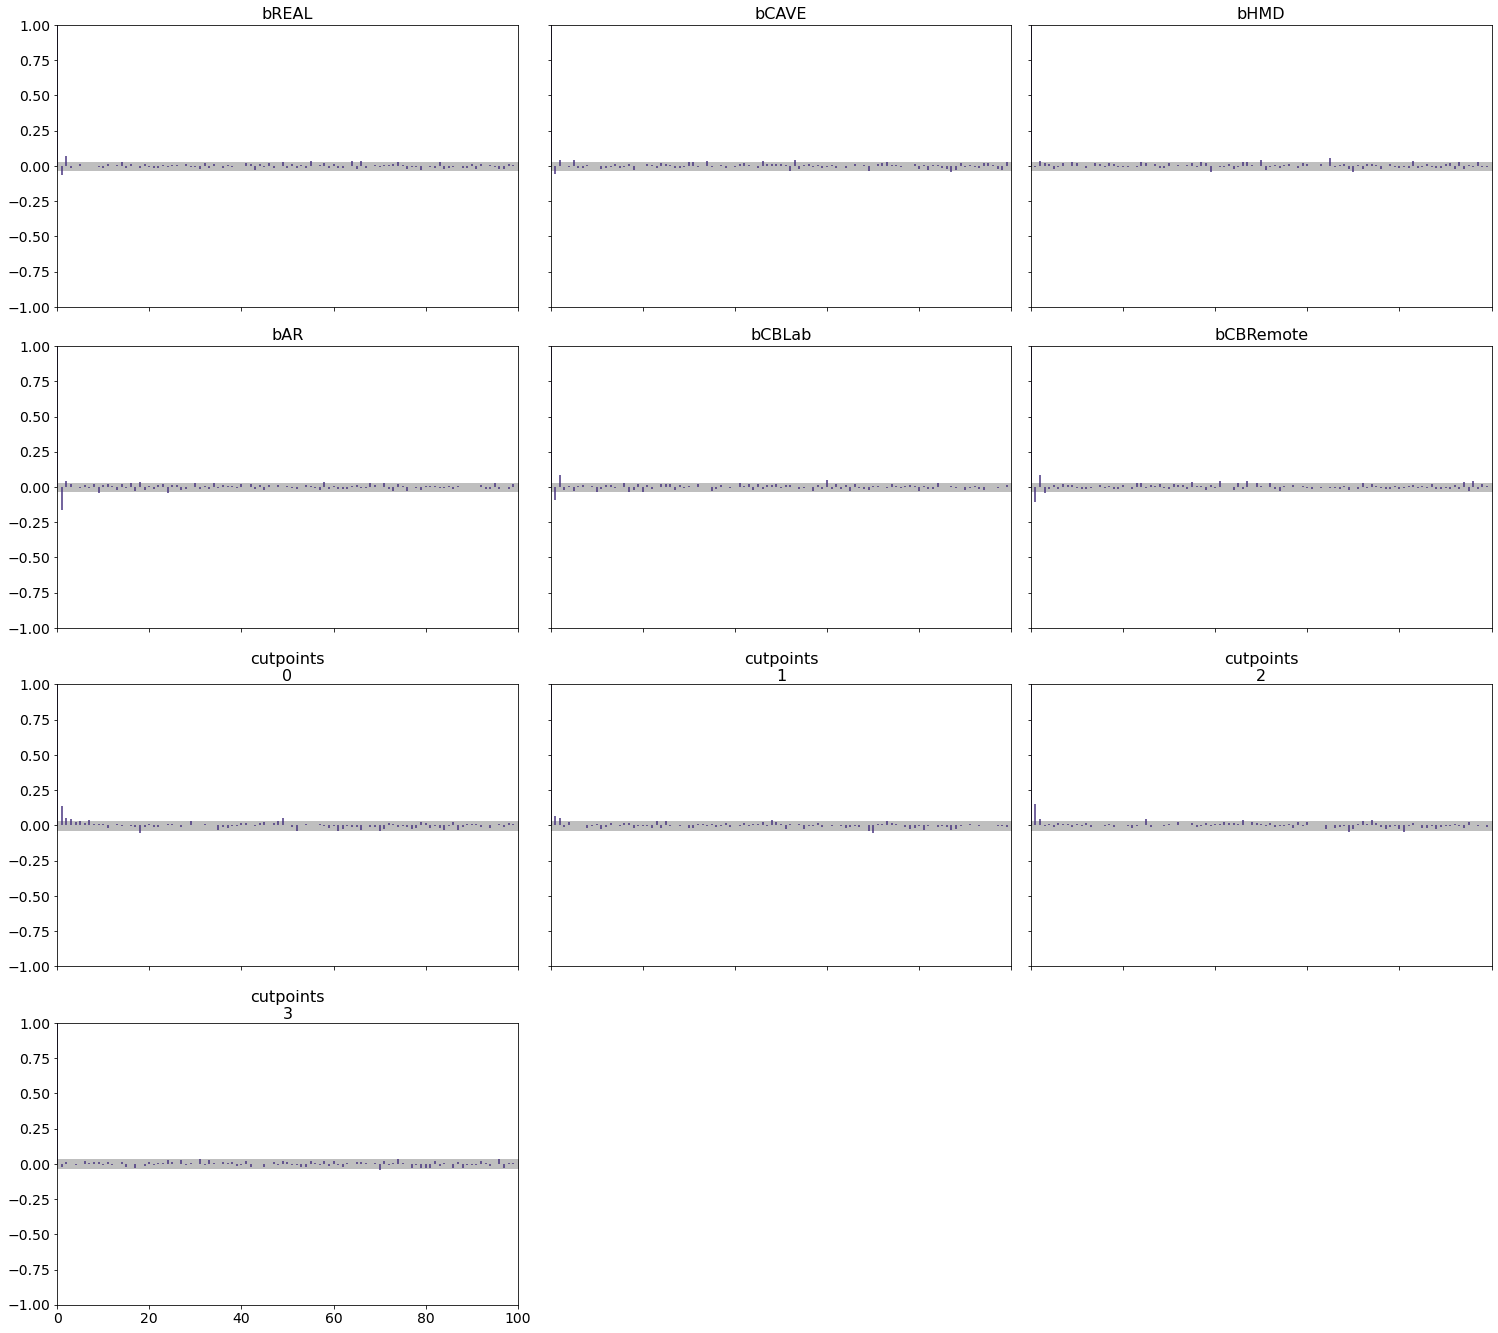

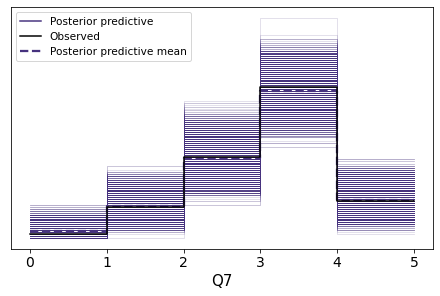

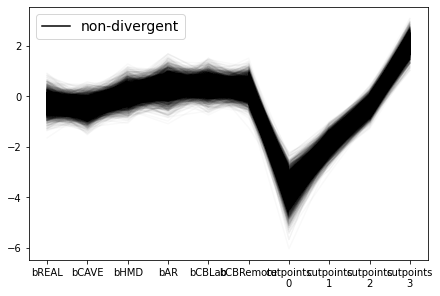

In [86]:
#Create posterior predictive
with Q7_model:
    ppc = pm.sample_posterior_predictive(trace_Q7, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(trace_Q7,var_names=["~eta"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(trace_Q7,var_names=["~eta"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q7_model)); #inspect posterior predictive check
az.plot_parallel(trace_Q7,var_names=["~eta"], filter_vars="regex", legend = True); #inspect divergencies

In [87]:
#Warning: prints the HDIs of the last run model
printHDIs('Q7')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.932    0.551  inconclusive
1        HMD - REAL  -0.348    1.106  inconclusive
2         AR - REAL  -0.205    1.584  inconclusive
3      CBLab - REAL  -0.050    1.433  inconclusive
4   CBRemote - REAL  -0.163    1.352  inconclusive
5  CBRemote - CBLab  -0.877    0.612  inconclusive
6              ROPE  -0.090    0.090  inconclusive

### Compared to usual, making a decision took longer / shorter

In [88]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q8"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0   -0.58
 2.0   -0.50
-2.0   -0.30
 1.0    0.02
-1.0     inf
Name: Q8, dtype: float64

In [89]:
#delete empty rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q8"].values))[0][0]
obs = np.delete(df_subjectives["Q8"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

Creating an ordered logistic regression based on https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb Code 12.24

In [90]:
with pm.Model() as Q8_model:
    #Defining cut points
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    
    #Creating normal priors for each condition
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    #Model equation 
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)
    Q8 = pm.OrderedLogistic("Q8", eta, cutpoints, observed = obs + 2)
    
    #Fit model
    trace_Q8 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)

#Posterior distributions for conditions
REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q8.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]

#Calculate differences of posterior distributions  
Q8_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

#Show summary
az.summary(trace_Q8, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.06  0.33   -0.52     0.72       0.01     0.00   3477.83   
bCAVE         0.28  0.32   -0.34     0.89       0.01     0.00   2958.43   
bHMD         -0.63  0.33   -1.25    -0.04       0.01     0.00   2982.38   
bAR          -0.21  0.38   -0.95     0.47       0.01     0.01   5097.12   
bCBLab        0.35  0.33   -0.30     0.93       0.01     0.00   3695.42   
bCBRemote    -0.16  0.34   -0.78     0.47       0.01     0.00   3302.06   
cutpoints[0] -2.99  0.38   -3.71    -2.30       0.01     0.01   2065.34   
cutpoints[1]  0.11  0.25   -0.35     0.59       0.01     0.00   2195.41   
cutpoints[2]  2.11  0.31    1.53     2.69       0.01     0.00   3004.50   
cutpoints[3]  3.66  0.50    2.77     4.65       0.01     0.01   4556.23   

              ess_tail  r_hat  
bREAL          3109.37    1.0  
bCAVE          2790.96    1.0  
bHMD           2835.47    1.0  
bAR            3341.19    1.0  
bCBLab         3234.89    1.0  
bCBRemote      3162.64    1.0  
cutpoints[0]   2186.38    1.0  
cutpoints[1]   3212.17    1.0  
cutpoints[2]   3241.44    1.0  
cutpoints[3]   3262.31    1.0

Model diagnostics

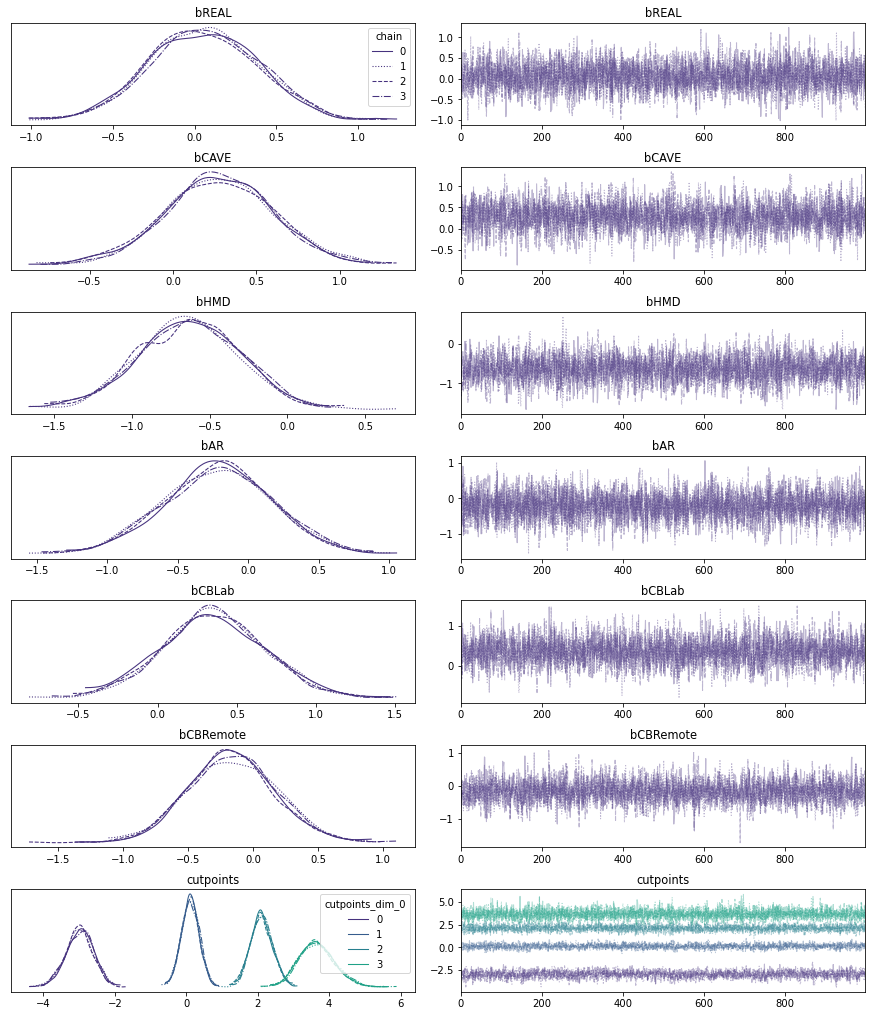

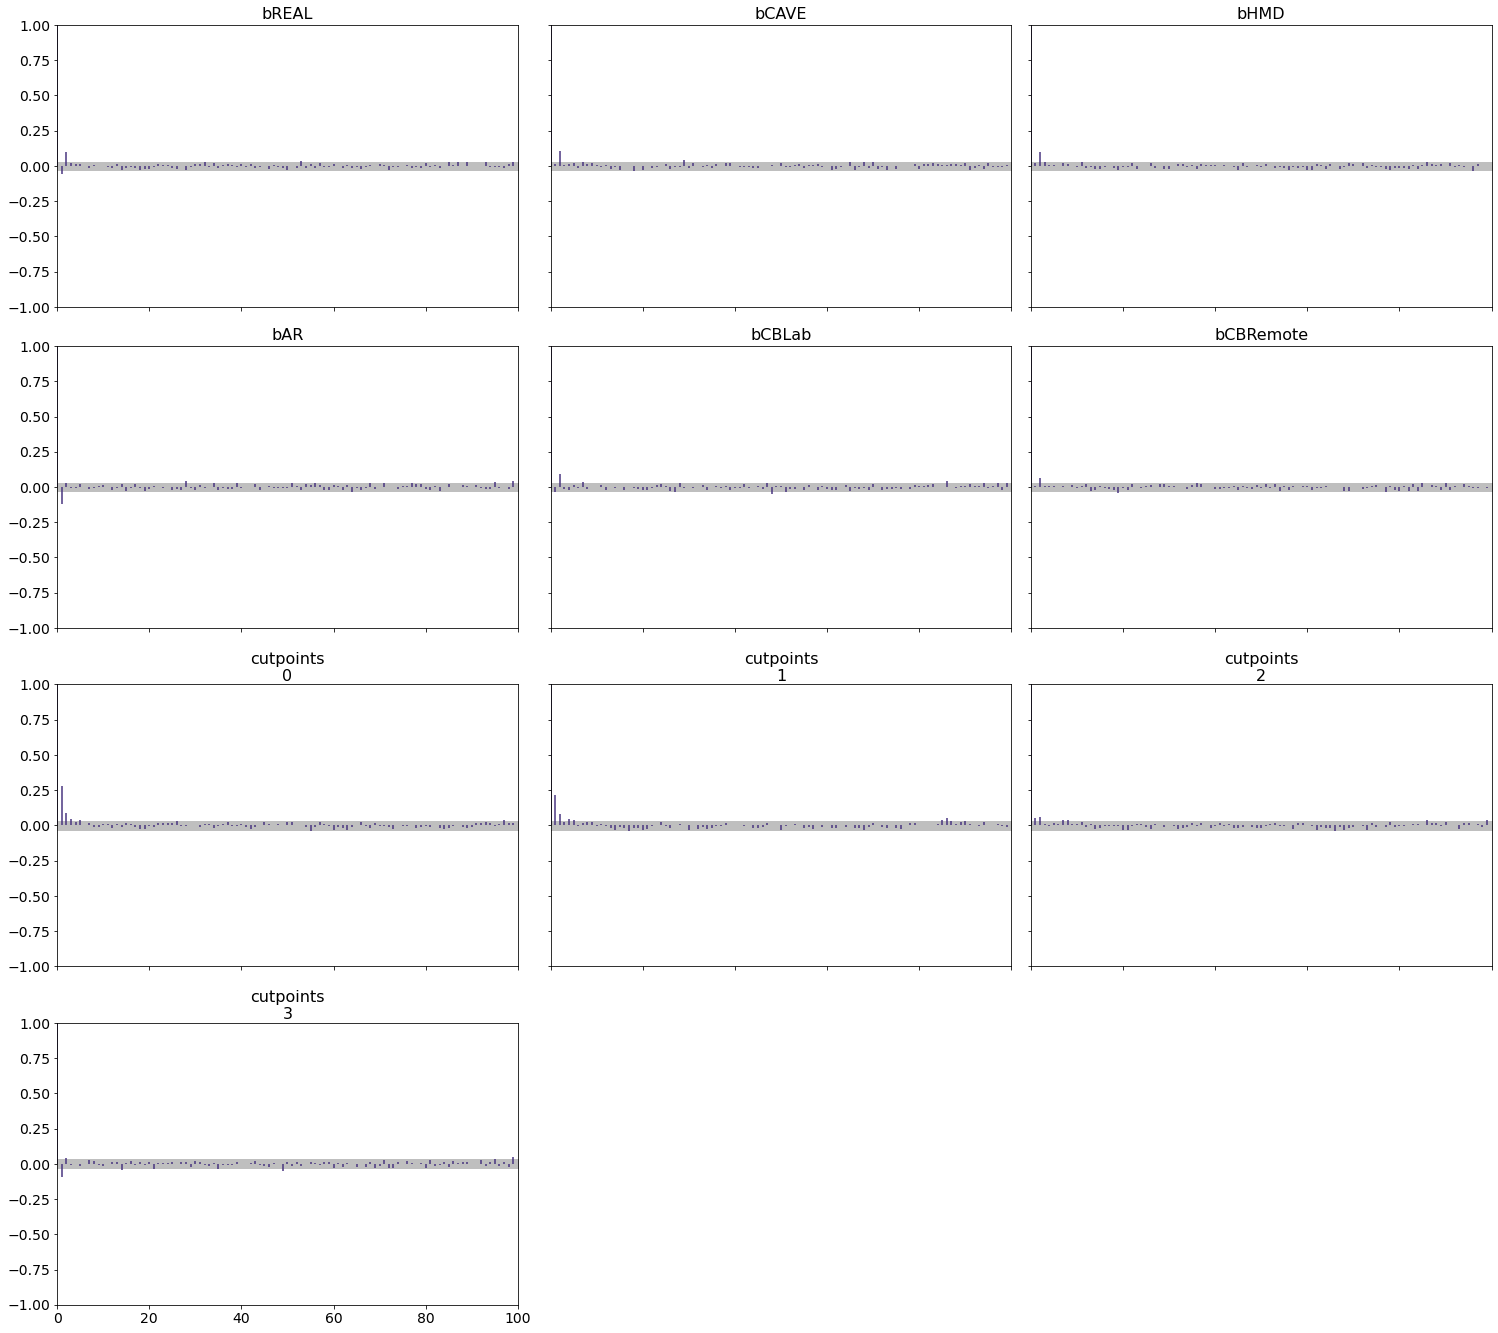

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


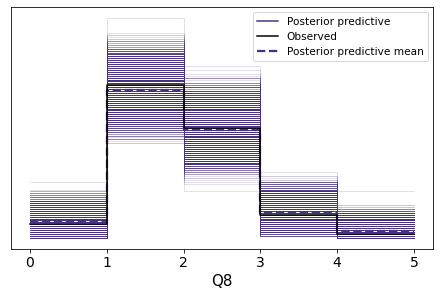

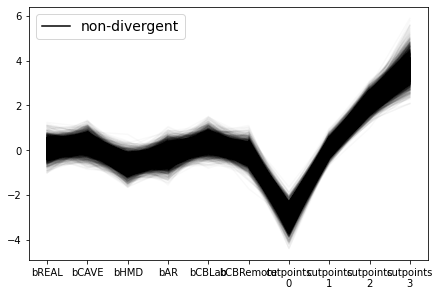

In [91]:
#Create posterior predictive
with Q8_model:
    ppc = pm.sample_posterior_predictive(trace_Q8, random_seed=RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(trace_Q8,var_names=["~eta"], filter_vars="regex",legend=True, compact=True); #inspect trace plots
az.plot_autocorr(trace_Q8,var_names=["~eta"], filter_vars="regex", combined = True); #inspect autocorrelation
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q8_model)); #inspect posterior predictive check
az.plot_parallel(trace_Q8,var_names=["~eta"], filter_vars="regex", legend = True); #inspect divergencies

In [92]:
#Warning: prints the HDIs of the last run model
printHDIs('Q8')

Comparison  lowHDI  highHDI        Result
0       CAVE - REAL  -0.535    0.980  inconclusive
1        HMD - REAL  -1.432    0.082  inconclusive
2         AR - REAL  -1.153    0.579  inconclusive
3      CBLab - REAL  -0.448    1.046  inconclusive
4   CBRemote - REAL  -0.968    0.577  inconclusive
5  CBRemote - CBLab  -1.248    0.248  inconclusive
6              ROPE  -0.079    0.079  inconclusive

### Summary

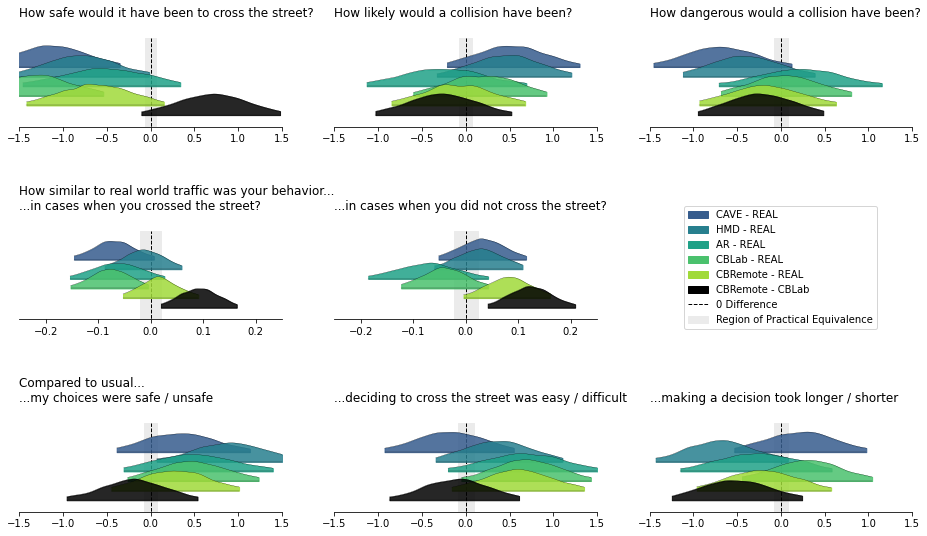

In [93]:
###Plot###
fig, axes = plt.subplots(3,3,figsize=(16, 9)) #init figure
plt.rcParams.update({'font.size': 10}) #update font size

#Helper function to create ridgeplots for each questionnaire item
def plotForest(data, ax):
    ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1) #create vertical 0 line
    
    #Create ridgeplot
    az.plot_forest(data,
                   kind='ridgeplot',
                   model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                   combined=True,
                   ax = ax,
                   ridgeplot_overlap=5,
                   linewidth=0.25,
                   colors=colors,
                   ridgeplot_alpha=0.85)
    #Aesthetics
    ax.spines['top'].set_color('white')
    ax.set_yticks([])

#Subplot Q1: How safe would it have been to cross the street?   
axes[0, 0].set_title("How safe would it have been to cross the street?" , loc='left')
axes[0, 0].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q1'].std()*-0.1,-10), df_subjectives['Q1'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q1_diffs, axes[0, 0])
axes[0, 0].set(xlim=(-1.5, 1.5))

#Subplot Q2: How likely would a collision have been?
axes[0, 1].set_title("How likely would a collision have been?" , loc='left')
axes[0, 1].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q2'].std()*-0.1,-10), df_subjectives['Q2'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q2_diffs, axes[0, 1])
axes[0, 1].set(xlim=(-1.5, 1.5))

#Subplot Q3: How dangerous would a collision have been?
axes[0, 2].set_title("How dangerous would a collision have been?" , loc='left')
axes[0, 2].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q3'].std()*-0.1,-10), df_subjectives['Q3'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q3_diffs, axes[0, 2])
axes[0, 2].set(xlim=(-1.5, 1.5))
 
#Subplot Q4: How similar to real world traffic was your behavior in cases when you crossed the street?
axes[1, 0].set_title("How similar to real world traffic was your behavior... \n...in cases when you crossed the street?" , loc='left')
axes[1, 0].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q4'].std()*-0.1,-10), df_subjectives['Q4'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q4_diffs, axes[1, 0])
axes[1, 0].set(xlim=(-0.25, 0.25))

#Subplot Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?    
axes[1, 1].set_title("\n...in cases when you did not cross the street?" , loc='left')
axes[1, 1].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q5'].std()*-0.1,-10), df_subjectives['Q5'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q5_diffs, axes[1, 1])
axes[1, 1].set(xlim=(-0.25, 0.25))

#Subplot Q6: Compared to usual, my choices were safe / unsafe
axes[2, 0].set_title("Compared to usual... \n...my choices were safe / unsafe" , loc='left')
axes[2, 0].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q6'].std()*-0.1,-10), df_subjectives['Q6'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q6_diffs, axes[2, 0])
axes[2, 0].set(xlim=(-1.5, 1.5))

#Subplot Q7: Compared to usual, deciding to cross the street was easy / difficult
axes[2, 1].set_title("\n...deciding to cross the street was easy / difficult" , loc='left')
axes[2, 1].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q7'].std()*-0.1,-10), df_subjectives['Q7'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q7_diffs, axes[2, 1])
axes[2, 1].set(xlim=(-1.5, 1.5))

#Subplot Q8: Compared to usual, making a decision took longer / shorter
axes[2, 2].set_title("\n...making a decision took longer / shorter" , loc='left')
axes[2, 2].add_patch(matplotlib.patches.Rectangle((df_subjectives['Q8'].std()*-0.1,-10), df_subjectives['Q8'].std()*0.2, 28, zorder=-100,color="#ebebeb"))
plotForest(Q8_diffs, axes[2, 2])
axes[2, 2].set(xlim=(-1.5, 1.5))

#Create Custom Legend
cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')
rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
axes[1, 2].legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], loc='center')
axes[1, 2].axis('off')

#Adjust whitespace between subplots
fig.subplots_adjust(hspace=0.85, wspace=0.2)

In [94]:
#Creating data sub frame for SRSI Analysis
df_subjective_cb = df_subjectives.loc[df_subjectives['Condition'].isin(['CBLab','CBRemote'])] #Select only Cardboard conditions
df_subjective_cb = df_subjective_cb[['Condition','SRSI']] #Drop all columns but condition and SRSI
df_subjective_cb = df_subjective_cb.astype({"Condition": 'object'}) #convert condition data type
df_subjective_cb['SRSI'] = abs(df_subjective_cb['SRSI']-100)+1 #invert data and add 1 otherwise modelling will fail with initials values being infinite

### SRSI

Question: "It is critical for our study to include data only from individuals who give their full attention to this study. Otherwise, years of effort (by the researchers and other participants' time) could be wasted. Hand on heart, should we use your data for our analyses in this study?"

Response: Slider with values from 0 to 100

Creating a linear model to predict SRSI as a function of Condition

In [95]:
#Define model
SRSI_model = bmb.Model(formula="SRSI ~ 0 + Condition",
                     data=df_subjective_cb, dropna=True,
                     categorical="Condition")

#Fit model
SRSI_fitted = SRSI_model.fit(random_seed=RANDOM_SEED)

#Show model summary
az.summary(SRSI_fitted)

Automatically removing 1/60 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SRSI_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  4.435  1.009   2.504    6.247      0.015    0.011    4752.0   
Condition[1]  3.754  1.052   1.759    5.662      0.015    0.011    4646.0   
SRSI_sigma    5.520  0.531   4.639    6.560      0.008    0.005    4942.0   

              ess_tail  r_hat  
Condition[0]    2810.0    1.0  
Condition[1]    2760.0    1.0  
SRSI_sigma      3251.0    1.0

Model diagnostics

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


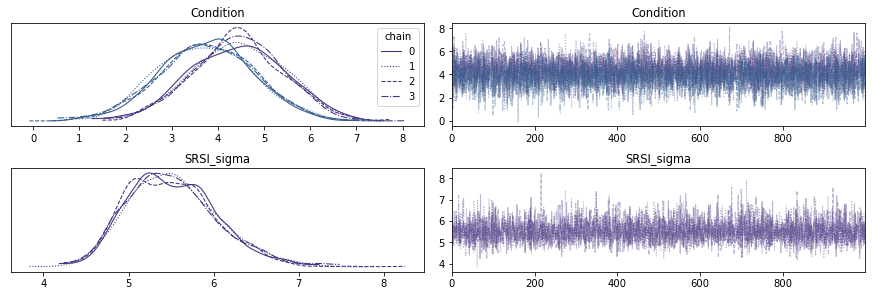

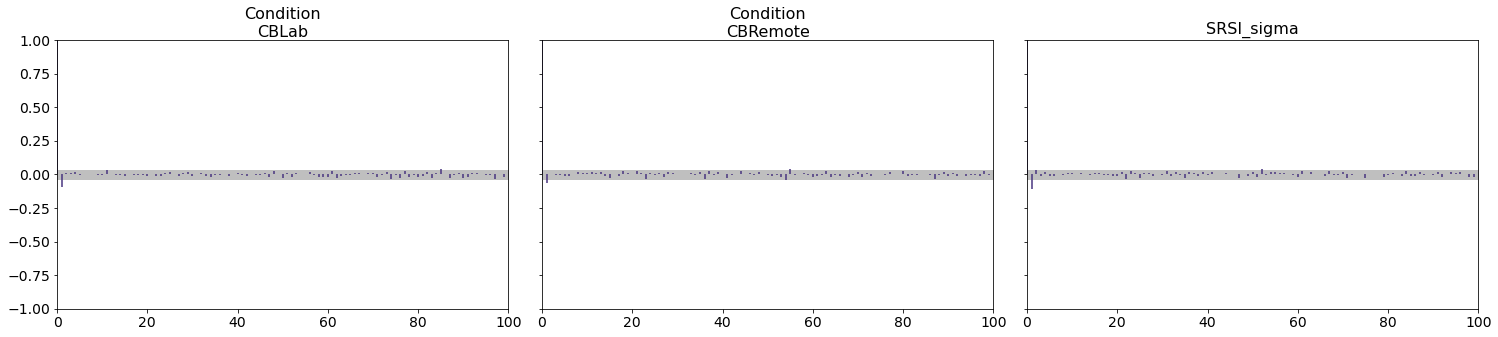

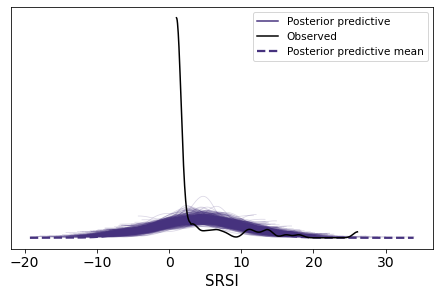

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


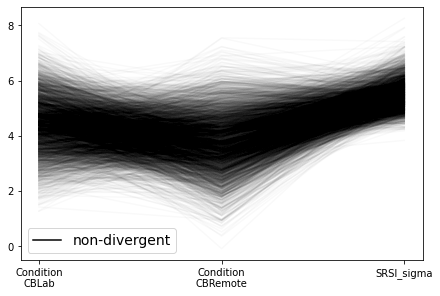

In [96]:
#Create posterior predictive
posterior_predictive = SRSI_model.posterior_predictive(SRSI_fitted,random_seed = RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(SRSI_fitted,legend=True, compact=True); #inspect trace plots 
az.plot_autocorr(SRSI_fitted, combined = True); #inspect autocorrelation
az.plot_ppc(SRSI_fitted); #inspect posterior predictive check
az.plot_parallel(SRSI_fitted, legend = True); #inspect divergencies

**Models with Gamma and Wald Function** to account for heavily skewed data
c.f. https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html

Wald model

In [97]:
#Define model
SRSI_model_wald = bmb.Model(formula="SRSI ~ 0 + Condition",
                     data=df_subjective_cb, dropna=True,
                     family = "wald", link = "log",
                     categorical="Condition")

#Fit model
SRSI_fitted_wald = SRSI_model_wald.fit(random_seed=RANDOM_SEED)

#Show model summary
az.summary(SRSI_fitted_wald)

Automatically removing 1/60 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SRSI_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The acceptance probability does not match the target. It is 0.8849684050146993, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  1.608  0.374   1.028    2.220      0.014    0.011    1665.0   
Condition[1]  1.420  0.290   0.896    1.928      0.007    0.006    2595.0   
SRSI_lam      2.179  0.414   1.457    2.995      0.008    0.006    2414.0   

              ess_tail  r_hat  
Condition[0]     878.0    1.0  
Condition[1]    1294.0    1.0  
SRSI_lam        2404.0    1.0

In [98]:
#Define model
SRSI_model_gamma = bmb.Model(formula="SRSI ~ 0 + Condition",
                     data=df_subjective_cb, dropna=True,
                     family = "gamma", link = "log",
                     categorical="Condition")
#Fit model
SRSI_fitted_gamma = SRSI_model_wald.fit(random_seed=RANDOM_SEED)

#Show model summary
az.summary(SRSI_fitted_gamma)

Automatically removing 1/60 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SRSI_lam, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
The acceptance probability does not match the target. It is 0.8849684050146993, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  1.608  0.374   1.028    2.220      0.014    0.011    1665.0   
Condition[1]  1.420  0.290   0.896    1.928      0.007    0.006    2595.0   
SRSI_lam      2.179  0.414   1.457    2.995      0.008    0.006    2414.0   

              ess_tail  r_hat  
Condition[0]     878.0    1.0  
Condition[1]    1294.0    1.0  
SRSI_lam        2404.0    1.0

Model comparison

In [99]:
#Creating dict with all models
models = {"wald": SRSI_fitted_wald, "gaussian": SRSI_fitted, "gamma": SRSI_fitted_gamma}

#Use arviz compare for model comparison
df_compare = az.compare(models)

#Output comparison
df_compare

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank         loo     p_loo      d_loo        weight         se  \
wald         0 -129.527554  2.153954   0.000000  5.000000e-01  11.695483   
gamma        1 -129.527554  2.153954   0.000000  5.000000e-01  11.695483   
gaussian     2 -187.120640  5.034504  57.593085  3.722300e-11  10.763512   

               dse  warning loo_scale  
wald      0.000000    False       log  
gamma     0.000000    False       log  
gaussian  8.807648     True       log

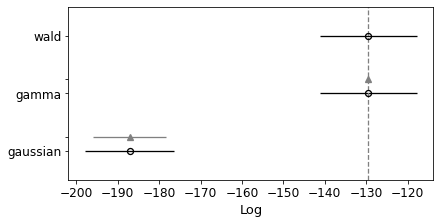

In [100]:
#Comparison plot
az.plot_compare(df_compare, insample_dev=False);

Model diagnostics

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


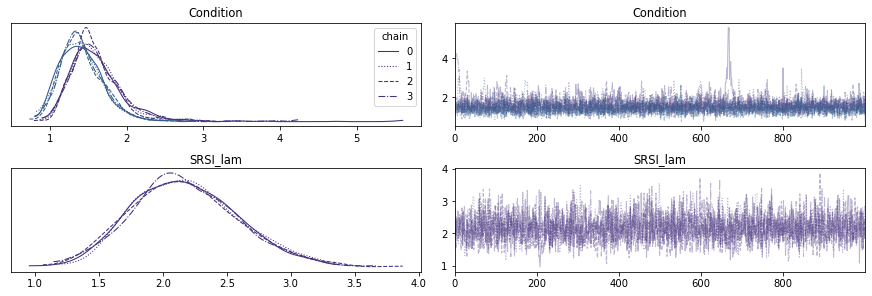

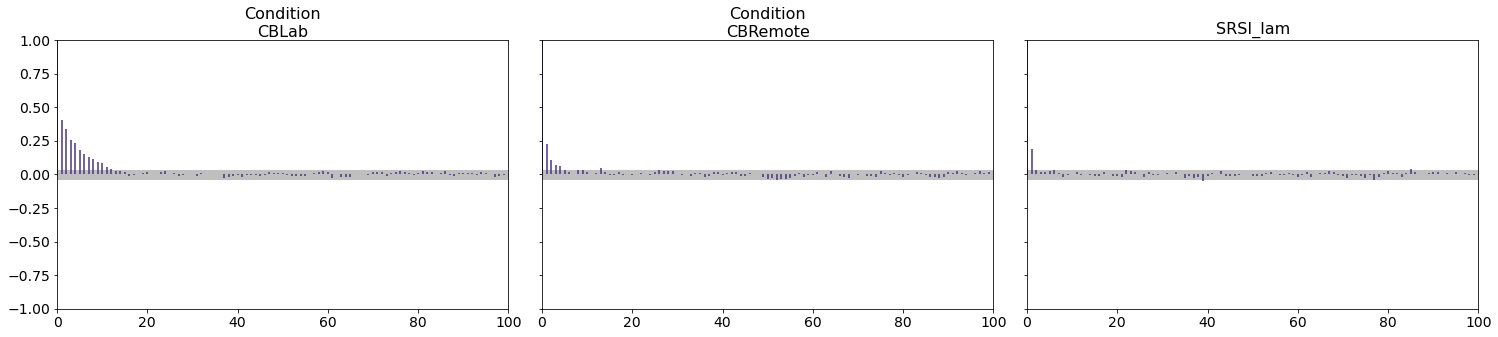

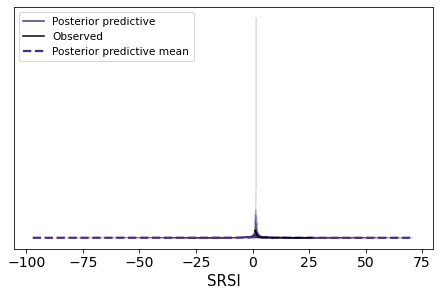

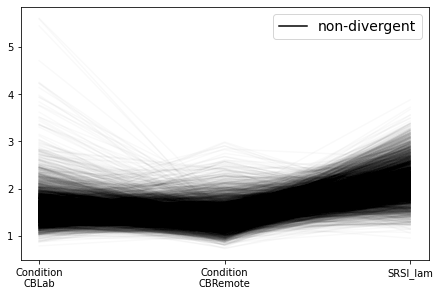

In [101]:
#Create posterior predictive
posterior_predictive = SRSI_model.posterior_predictive(SRSI_fitted_wald,random_seed = RANDOM_SEED)

#Create diagnostic plots
az.plot_trace(SRSI_fitted_wald,legend=True, compact=True); #inspect trace plots
az.plot_autocorr(SRSI_fitted_wald, combined = True); #inspect autocorrelation
az.plot_ppc(SRSI_fitted_wald); #inspect posterior predictive check
az.plot_parallel(SRSI_fitted_wald, legend = True); #inspect divergencies

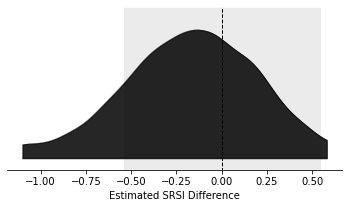

In [102]:
#Calculate posterior distributions
CBLab, CBRemote = [SRSI_fitted_wald.posterior['Condition'][:,:,x].values for x in [0,1]]

###Plot###
fig, ax = plt.subplots(figsize=(6, 3)) # Init figure
ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1) #create vertical 0 line

#Create ridgeplot
az.plot_forest(CBRemote-CBLab,
                   kind='ridgeplot',
                   model_names = ['CBRemote - CBLab'],
                   combined=True,
                   ridgeplot_overlap=5,
                   linewidth=0.25,
                   colors=colors,
                   ax = ax,
                   ridgeplot_alpha=0.85)

#Add ROPE to plot
ax.add_patch(matplotlib.patches.Rectangle((df_subjective_cb['SRSI'].std()*-0.1,-10), 
                                          df_subjective_cb['SRSI'].std()*0.2, 28, zorder=-100,color="#ebebeb"));

#Aesthetics
ax.spines['top'].set_color('white');
ax.set_yticks([]);
ax.set(xlabel='Estimated SRSI Difference');


Output values of highest density intervals (HDIs)

In [103]:
#Create dataframe
HDIs = pd.DataFrame(np.array([np.concatenate((['CBRemote - CBLab'],az.hdi(az.convert_to_dataset(CBRemote - CBLab)).x.data)),
                             ['ROPE',df_subjective_cb['SRSI'].std()*-0.1,df_subjective_cb['SRSI'].std()*0.1]]),
             columns=['Comparison', 'lowHDI', 'highHDI'])

#Set column data types
HDIs = HDIs.astype({"lowHDI": 'float',"highHDI": 'float'})

#Round and output values
HDIs.round(3)

Comparison  lowHDI  highHDI
0  CBRemote - CBLab  -1.112    0.589
1              ROPE  -0.541    0.541